In [1]:
import keras
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
from keras.callbacks import ModelCheckpoint, EarlyStopping
# %reload_ext mermaid
# import IPython
# IPython.load_ipython_extensions(["nb-mermaid/nb-mermaid"]);

Using TensorFlow backend.


In [2]:
import tensorflow  as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D,Reshape, Dropout, Dense, GlobalAveragePooling2D, \
BatchNormalization, Input, Flatten, MaxPooling2D, UpSampling2D,Lambda
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import Adadelta, SGD, Adam
from keras.utils import to_categorical
import keras.backend as K

In [3]:
tf_config = tf.ConfigProto(allow_soft_placement=False)
tf_config.gpu_options.allow_growth = True
s = tf.Session(config=tf_config)
K.set_session(s)

In [4]:
csv_data = pd.read_csv('15features.csv')

In [5]:
display(csv_data.head()), csv_data.shape

,imagename,pen_pressure,letter_spacing,size,dimension,is_lowercase,is_continuous,slantness,tilt,entry_stroke_a,staff_of_a,formation_n,staff_of_d,exit_stroke_d,word_formation,constancy
0,0968c_num1.png,2,2,2,1,2,2,3,2,1,2,2,3,2,2,1
1,0809c_num2.png,2,2,2,2,2,2,3,1,1,2,2,3,1,2,2
2,0237b_num6.png,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2
3,0069b_num2.png,2,2,2,1,2,2,1,1,1,1,1,1,1,1,1
4,0966c_num4.png,2,2,2,2,2,2,2,1,1,2,2,2,2,2,2


(None, (13570, 16))

In [6]:
train_path = 'seen-dataset/TrainingSet/'
train_images = os.listdir(train_path)
len(train_images)
val_path = 'seen-dataset/ValidationSet/'
val_images = os.listdir(val_path)
len(val_images)

952

In [7]:
input_img = Input(shape=(64, 64, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoded')(x)
# encoded = GlobalAveragePooling2D()(x)

# encoder = Model(input_img, encoded)
# encoder.summary()
# print(encoded.shape)
# encoded = Flatten()(x)
# encoded = Dense(8*8*8)(encoded)
# # model = Model(input_img,encoded)
# # print(model.summary())
# # at this point the representation is (4, 4, 8) i.e. 128-dimensional
# r = Reshape(target_shape=(8,8,8))(encoded)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same',name='output')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
__________

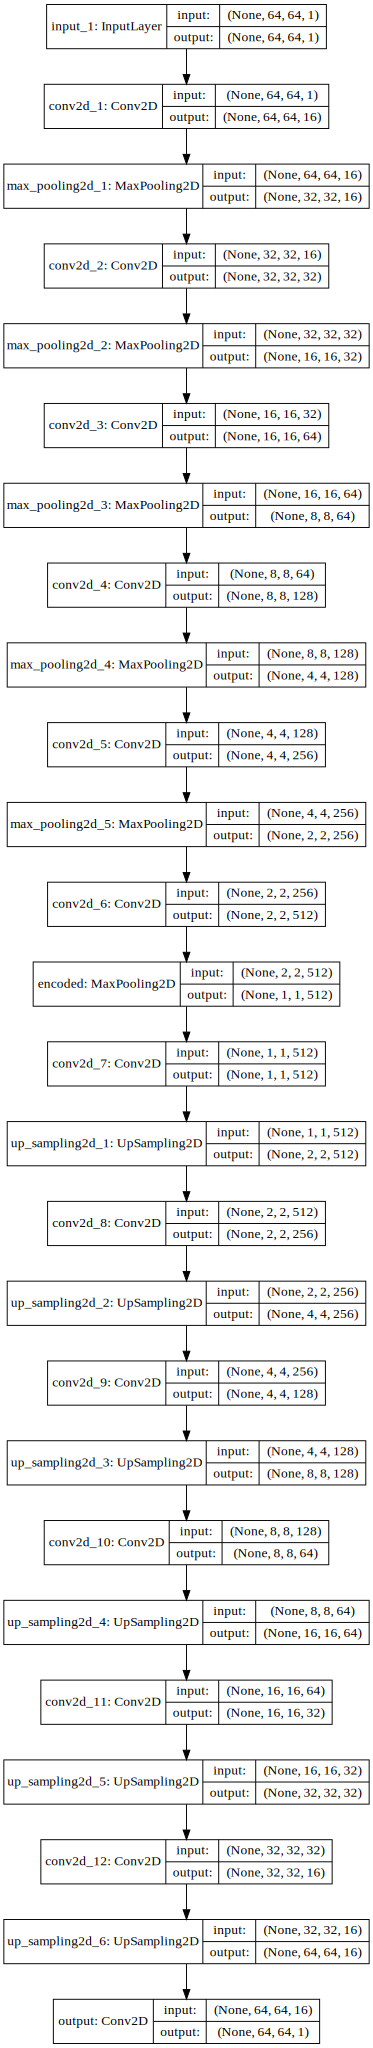

In [8]:

SVG(model_to_dot(autoencoder, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [9]:

def datagen(batch_size,image_path,list_of_writers, hshift = (-64,64) ,vis=False):
    counter = 0
    
    
    while True:
        counter = 0
        # for writer in unique_writers:
        #     print(identitycounter*100/stop_at, end='\r')
        w_ids,ids = [],[]
        writer_indexes = np.random.randint(0,len(list_of_writers),batch_size)
        x,y,writers = [],[],[]
        for writer_index in writer_indexes:
#             class_vectors = []
            writer = list_of_writers[writer_index]
#             print(writer)
#             writer_samples = list(images[images['image'].str.match(writer)]['image'])
#             print('writer:',writer,', writer_samples:',writer_samples)
#             if len(writer_samples) == 0:
#                 continue
#             writer_sample_index = np.random.randint(0,len(writer_samples))

#             #     unique_writers_count[writer] = len(writer_samples)
# #             print('writer_sample_index:',writer_sample_index)
#             csv_writer = writer_samples[writer_sample_index][:5]

    
            loaded_image = cv2.imread(os.path.join(image_path,writer),0)
            rand = np.random.randint(hshift[0],hshift[1])
            loaded_image_shifted=np.roll(axis=0,a=loaded_image,shift=rand)
#             loaded_image = np.expand_dims(loaded_image,-1)
#             loaded_image_shifted = np.expand_dims(loaded_image_shifted,-1)
#             print('csv_writer:', csv_writer, ', writer:', writer)
#             display(csv_data[csv_data['ImageId'].str.match(csv_writer)])
#             csv_discreete_features = csv_data[csv_data['ImageId'].str.match(csv_writer)].iloc[0].values[2:]
#             print(csv_writer, writer_samples[writer_sample_index])
#             print(csv_writer,csv_discreete_features)
#             for i in range(1,9):
#                 print(csv_discreete_features[i-1],end=',')
#             f_1_out.append(csv_discreete_features[0])
#             f_2_out.append(csv_discreete_features[1])
#             f_3_out.append(csv_discreete_features[2])
#             f_4_out.append(csv_discreete_features[3])
#             f_5_out.append(csv_discreete_features[4])
#             f_6_out.append(csv_discreete_features[5])
#             f_7_out.append(csv_discreete_features[6])
#             f_8_out.append(csv_discreete_features[7])
#                 class_vectors.append(to_categorical(csv_discreete_features[i-1],num_classes=feature_lengths['f'+str(i)]))
#             print("\n",len(class_vectors))
#             print('\n-----------')
            
#             print("++++++++++++++++++++++[",counter,"]+++++++++++++++++++++++")
        #     imgcounter = 0
        #     for sample in writer_samples:
        #         imagepath = os.path.join(image_path,sample)
        #         raw_img = cv2.imread(imagepath)
        #         imgcounter+=1
        #     imgcounter=0
        #     identitycounter += 1
            x.append(255.0-loaded_image_shifted.reshape((64,64,1)))
            y.append(255.0-loaded_image.reshape((64,64,1)))
            w_ids.append(writer[:4])
            writers.append(writer)
            ids.append(writer_index)
            
            counter+=1
#             print('counter:', counter, end='\r')
        if counter <= batch_size:
            if vis== True:
                yield np.array(x)/255.0,[np.array(w_ids),np.array(writers)]
            else:
                yield np.array(x)/255.0,np.array(y)/255.0
                    

In [10]:
# # unique_writers_count
# f_count = {}
train_list_of_writers = train_images
val_list_of_writers = val_images
batch_size = 64

tg = datagen(batch_size,train_path,train_list_of_writers, hshift = (-64,64))
vg = datagen(batch_size,val_path,val_list_of_writers, hshift = (-64,64))
# test_g = datagen(4,val_list_of_writers, hshift = (-12,12))

In [11]:
# images
for i in range(10):
    inputs,y = next(tg)
inputs.shape , y.shape#, o[0].shape #, o[1].shape,o[2].shape,o[3].shape,o[4].shape,o[5].shape,o[6].shape,o[7].shape

((64, 64, 64, 1), (64, 64, 64, 1))

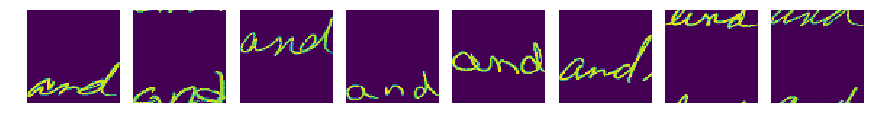

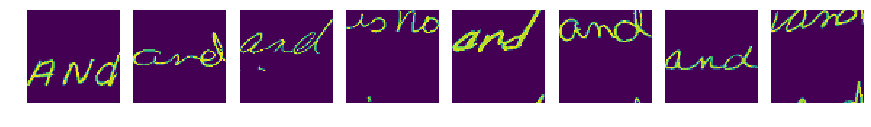

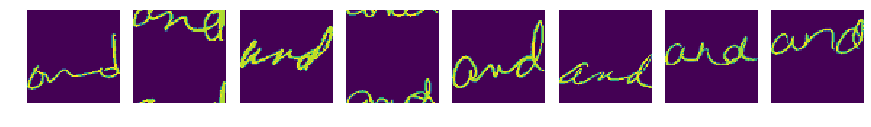

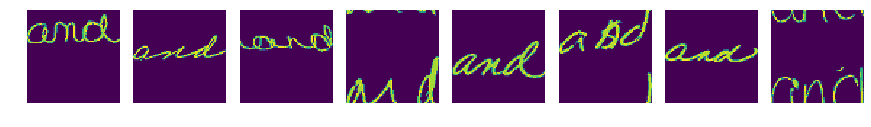

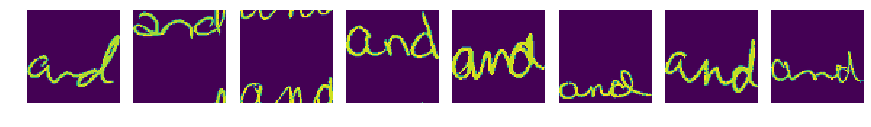

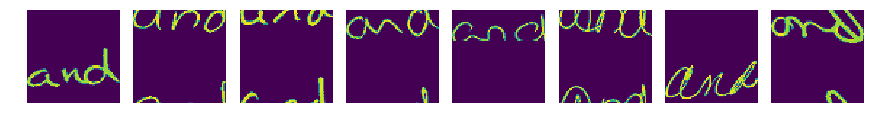

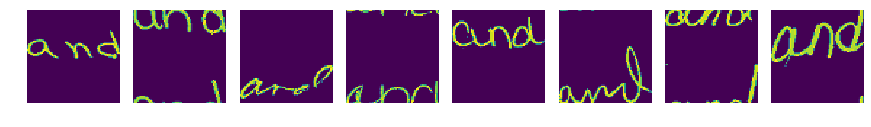

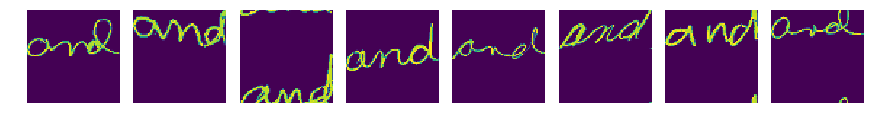

In [12]:
for r in range(8):
    f,ax = plt.subplots(1,8)
    f.subplots_adjust(hspace = .00, wspace=.15)
    f.set_size_inches(15,5)
    for c in range (8):
        ax[c].imshow(inputs[c+r*8].reshape((64,64)))
        ax[c].axis('off')

In [13]:
mc = ModelCheckpoint(filepath='simple_ae_maxpool_seen_weights_v1.h5', monitor='val_loss',period=1,save_best_only=True,save_weights_only=True,mode='auto',verbose=3)
es = EarlyStopping(patience=10000, monitor='val_loss', min_delta=0.0005, mode='auto')
autoencoder.load_weights('simple_ae_maxpool_less_weights_v3.h5')

In [14]:
EPOCHS = 50000

hist = autoencoder.fit_generator(tg, callbacks=[mc,es]
                                    , epochs=EPOCHS
                                    , steps_per_epoch = 1
                                    , validation_data = vg
                                    , validation_steps = 1
                                    , verbose = 3
                                    
                                   )

Epoch 1/50000

Epoch 00001: val_loss improved from inf to 0.13472, saving model to simple_ae_maxpool_seen_weights_v1.h5
Epoch 2/50000

Epoch 00002: val_loss did not improve from 0.13472
Epoch 3/50000

Epoch 00003: val_loss improved from 0.13472 to 0.12962, saving model to simple_ae_maxpool_seen_weights_v1.h5
Epoch 4/50000

Epoch 00004: val_loss improved from 0.12962 to 0.12934, saving model to simple_ae_maxpool_seen_weights_v1.h5
Epoch 5/50000

Epoch 00005: val_loss did not improve from 0.12934
Epoch 6/50000

Epoch 00006: val_loss improved from 0.12934 to 0.12589, saving model to simple_ae_maxpool_seen_weights_v1.h5
Epoch 7/50000

Epoch 00007: val_loss improved from 0.12589 to 0.11925, saving model to simple_ae_maxpool_seen_weights_v1.h5
Epoch 8/50000

Epoch 00008: val_loss did not improve from 0.11925
Epoch 9/50000

Epoch 00009: val_loss did not improve from 0.11925
Epoch 10/50000

Epoch 00010: val_loss did not improve from 0.11925
Epoch 11/50000

Epoch 00011: val_loss did not improve


Epoch 00118: val_loss did not improve from 0.11081
Epoch 119/50000

Epoch 00119: val_loss did not improve from 0.11081
Epoch 120/50000

Epoch 00120: val_loss did not improve from 0.11081
Epoch 121/50000

Epoch 00121: val_loss did not improve from 0.11081
Epoch 122/50000

Epoch 00122: val_loss did not improve from 0.11081
Epoch 123/50000

Epoch 00123: val_loss did not improve from 0.11081
Epoch 124/50000

Epoch 00124: val_loss did not improve from 0.11081
Epoch 125/50000

Epoch 00125: val_loss did not improve from 0.11081
Epoch 126/50000

Epoch 00126: val_loss did not improve from 0.11081
Epoch 127/50000

Epoch 00127: val_loss did not improve from 0.11081
Epoch 128/50000

Epoch 00128: val_loss did not improve from 0.11081
Epoch 129/50000

Epoch 00129: val_loss did not improve from 0.11081
Epoch 130/50000

Epoch 00130: val_loss did not improve from 0.11081
Epoch 131/50000

Epoch 00131: val_loss did not improve from 0.11081
Epoch 132/50000

Epoch 00132: val_loss did not improve from 0.11


Epoch 00244: val_loss did not improve from 0.11081
Epoch 245/50000

Epoch 00245: val_loss did not improve from 0.11081
Epoch 246/50000

Epoch 00246: val_loss did not improve from 0.11081
Epoch 247/50000

Epoch 00247: val_loss did not improve from 0.11081
Epoch 248/50000

Epoch 00248: val_loss did not improve from 0.11081
Epoch 249/50000

Epoch 00249: val_loss did not improve from 0.11081
Epoch 250/50000

Epoch 00250: val_loss did not improve from 0.11081
Epoch 251/50000

Epoch 00251: val_loss did not improve from 0.11081
Epoch 252/50000

Epoch 00252: val_loss did not improve from 0.11081
Epoch 253/50000

Epoch 00253: val_loss did not improve from 0.11081
Epoch 254/50000

Epoch 00254: val_loss did not improve from 0.11081
Epoch 255/50000

Epoch 00255: val_loss did not improve from 0.11081
Epoch 256/50000

Epoch 00256: val_loss did not improve from 0.11081
Epoch 257/50000

Epoch 00257: val_loss did not improve from 0.11081
Epoch 258/50000

Epoch 00258: val_loss did not improve from 0.11


Epoch 00369: val_loss did not improve from 0.11016
Epoch 370/50000

Epoch 00370: val_loss did not improve from 0.11016
Epoch 371/50000

Epoch 00371: val_loss did not improve from 0.11016
Epoch 372/50000

Epoch 00372: val_loss did not improve from 0.11016
Epoch 373/50000

Epoch 00373: val_loss did not improve from 0.11016
Epoch 374/50000

Epoch 00374: val_loss did not improve from 0.11016
Epoch 375/50000

Epoch 00375: val_loss did not improve from 0.11016
Epoch 376/50000

Epoch 00376: val_loss did not improve from 0.11016
Epoch 377/50000

Epoch 00377: val_loss did not improve from 0.11016
Epoch 378/50000

Epoch 00378: val_loss did not improve from 0.11016
Epoch 379/50000

Epoch 00379: val_loss did not improve from 0.11016
Epoch 380/50000

Epoch 00380: val_loss did not improve from 0.11016
Epoch 381/50000

Epoch 00381: val_loss did not improve from 0.11016
Epoch 382/50000

Epoch 00382: val_loss did not improve from 0.11016
Epoch 383/50000

Epoch 00383: val_loss did not improve from 0.11


Epoch 00492: val_loss did not improve from 0.10949
Epoch 493/50000

Epoch 00493: val_loss did not improve from 0.10949
Epoch 494/50000

Epoch 00494: val_loss did not improve from 0.10949
Epoch 495/50000

Epoch 00495: val_loss did not improve from 0.10949
Epoch 496/50000

Epoch 00496: val_loss did not improve from 0.10949
Epoch 497/50000

Epoch 00497: val_loss did not improve from 0.10949
Epoch 498/50000

Epoch 00498: val_loss did not improve from 0.10949
Epoch 499/50000

Epoch 00499: val_loss did not improve from 0.10949
Epoch 500/50000

Epoch 00500: val_loss did not improve from 0.10949
Epoch 501/50000

Epoch 00501: val_loss did not improve from 0.10949
Epoch 502/50000

Epoch 00502: val_loss did not improve from 0.10949
Epoch 503/50000

Epoch 00503: val_loss did not improve from 0.10949
Epoch 504/50000

Epoch 00504: val_loss did not improve from 0.10949
Epoch 505/50000

Epoch 00505: val_loss did not improve from 0.10949
Epoch 506/50000

Epoch 00506: val_loss did not improve from 0.10


Epoch 00618: val_loss did not improve from 0.10949
Epoch 619/50000

Epoch 00619: val_loss did not improve from 0.10949
Epoch 620/50000

Epoch 00620: val_loss did not improve from 0.10949
Epoch 621/50000

Epoch 00621: val_loss did not improve from 0.10949
Epoch 622/50000

Epoch 00622: val_loss did not improve from 0.10949
Epoch 623/50000

Epoch 00623: val_loss did not improve from 0.10949
Epoch 624/50000

Epoch 00624: val_loss did not improve from 0.10949
Epoch 625/50000

Epoch 00625: val_loss did not improve from 0.10949
Epoch 626/50000

Epoch 00626: val_loss did not improve from 0.10949
Epoch 627/50000

Epoch 00627: val_loss did not improve from 0.10949
Epoch 628/50000

Epoch 00628: val_loss did not improve from 0.10949
Epoch 629/50000

Epoch 00629: val_loss did not improve from 0.10949
Epoch 630/50000

Epoch 00630: val_loss did not improve from 0.10949
Epoch 631/50000

Epoch 00631: val_loss did not improve from 0.10949
Epoch 632/50000

Epoch 00632: val_loss did not improve from 0.10


Epoch 00744: val_loss did not improve from 0.10949
Epoch 745/50000

Epoch 00745: val_loss did not improve from 0.10949
Epoch 746/50000

Epoch 00746: val_loss did not improve from 0.10949
Epoch 747/50000

Epoch 00747: val_loss did not improve from 0.10949
Epoch 748/50000

Epoch 00748: val_loss did not improve from 0.10949
Epoch 749/50000

Epoch 00749: val_loss did not improve from 0.10949
Epoch 750/50000

Epoch 00750: val_loss did not improve from 0.10949
Epoch 751/50000

Epoch 00751: val_loss did not improve from 0.10949
Epoch 752/50000

Epoch 00752: val_loss did not improve from 0.10949
Epoch 753/50000

Epoch 00753: val_loss did not improve from 0.10949
Epoch 754/50000

Epoch 00754: val_loss did not improve from 0.10949
Epoch 755/50000

Epoch 00755: val_loss did not improve from 0.10949
Epoch 756/50000

Epoch 00756: val_loss did not improve from 0.10949
Epoch 757/50000

Epoch 00757: val_loss did not improve from 0.10949
Epoch 758/50000

Epoch 00758: val_loss did not improve from 0.10


Epoch 00868: val_loss did not improve from 0.10636
Epoch 869/50000

Epoch 00869: val_loss did not improve from 0.10636
Epoch 870/50000

Epoch 00870: val_loss did not improve from 0.10636
Epoch 871/50000

Epoch 00871: val_loss did not improve from 0.10636
Epoch 872/50000

Epoch 00872: val_loss did not improve from 0.10636
Epoch 873/50000

Epoch 00873: val_loss did not improve from 0.10636
Epoch 874/50000

Epoch 00874: val_loss did not improve from 0.10636
Epoch 875/50000

Epoch 00875: val_loss did not improve from 0.10636
Epoch 876/50000

Epoch 00876: val_loss did not improve from 0.10636
Epoch 877/50000

Epoch 00877: val_loss did not improve from 0.10636
Epoch 878/50000

Epoch 00878: val_loss did not improve from 0.10636
Epoch 879/50000

Epoch 00879: val_loss did not improve from 0.10636
Epoch 880/50000

Epoch 00880: val_loss did not improve from 0.10636
Epoch 881/50000

Epoch 00881: val_loss did not improve from 0.10636
Epoch 882/50000

Epoch 00882: val_loss did not improve from 0.10


Epoch 00994: val_loss did not improve from 0.10636
Epoch 995/50000

Epoch 00995: val_loss did not improve from 0.10636
Epoch 996/50000

Epoch 00996: val_loss did not improve from 0.10636
Epoch 997/50000

Epoch 00997: val_loss did not improve from 0.10636
Epoch 998/50000

Epoch 00998: val_loss did not improve from 0.10636
Epoch 999/50000

Epoch 00999: val_loss did not improve from 0.10636
Epoch 1000/50000

Epoch 01000: val_loss did not improve from 0.10636
Epoch 1001/50000

Epoch 01001: val_loss did not improve from 0.10636
Epoch 1002/50000

Epoch 01002: val_loss did not improve from 0.10636
Epoch 1003/50000

Epoch 01003: val_loss did not improve from 0.10636
Epoch 1004/50000

Epoch 01004: val_loss did not improve from 0.10636
Epoch 1005/50000

Epoch 01005: val_loss did not improve from 0.10636
Epoch 1006/50000

Epoch 01006: val_loss did not improve from 0.10636
Epoch 1007/50000

Epoch 01007: val_loss did not improve from 0.10636
Epoch 1008/50000

Epoch 01008: val_loss did not improve 


Epoch 01118: val_loss did not improve from 0.10430
Epoch 1119/50000

Epoch 01119: val_loss did not improve from 0.10430
Epoch 1120/50000

Epoch 01120: val_loss did not improve from 0.10430
Epoch 1121/50000

Epoch 01121: val_loss did not improve from 0.10430
Epoch 1122/50000

Epoch 01122: val_loss did not improve from 0.10430
Epoch 1123/50000

Epoch 01123: val_loss did not improve from 0.10430
Epoch 1124/50000

Epoch 01124: val_loss did not improve from 0.10430
Epoch 1125/50000

Epoch 01125: val_loss did not improve from 0.10430
Epoch 1126/50000

Epoch 01126: val_loss did not improve from 0.10430
Epoch 1127/50000

Epoch 01127: val_loss did not improve from 0.10430
Epoch 1128/50000

Epoch 01128: val_loss did not improve from 0.10430
Epoch 1129/50000

Epoch 01129: val_loss did not improve from 0.10430
Epoch 1130/50000

Epoch 01130: val_loss did not improve from 0.10430
Epoch 1131/50000

Epoch 01131: val_loss did not improve from 0.10430
Epoch 1132/50000

Epoch 01132: val_loss did not imp


Epoch 01244: val_loss did not improve from 0.10430
Epoch 1245/50000

Epoch 01245: val_loss did not improve from 0.10430
Epoch 1246/50000

Epoch 01246: val_loss did not improve from 0.10430
Epoch 1247/50000

Epoch 01247: val_loss did not improve from 0.10430
Epoch 1248/50000

Epoch 01248: val_loss did not improve from 0.10430
Epoch 1249/50000

Epoch 01249: val_loss did not improve from 0.10430
Epoch 1250/50000

Epoch 01250: val_loss did not improve from 0.10430
Epoch 1251/50000

Epoch 01251: val_loss did not improve from 0.10430
Epoch 1252/50000

Epoch 01252: val_loss did not improve from 0.10430
Epoch 1253/50000

Epoch 01253: val_loss did not improve from 0.10430
Epoch 1254/50000

Epoch 01254: val_loss did not improve from 0.10430
Epoch 1255/50000

Epoch 01255: val_loss did not improve from 0.10430
Epoch 1256/50000

Epoch 01256: val_loss did not improve from 0.10430
Epoch 1257/50000

Epoch 01257: val_loss did not improve from 0.10430
Epoch 1258/50000

Epoch 01258: val_loss did not imp


Epoch 01367: val_loss did not improve from 0.10425
Epoch 1368/50000

Epoch 01368: val_loss did not improve from 0.10425
Epoch 1369/50000

Epoch 01369: val_loss did not improve from 0.10425
Epoch 1370/50000

Epoch 01370: val_loss did not improve from 0.10425
Epoch 1371/50000

Epoch 01371: val_loss did not improve from 0.10425
Epoch 1372/50000

Epoch 01372: val_loss did not improve from 0.10425
Epoch 1373/50000

Epoch 01373: val_loss did not improve from 0.10425
Epoch 1374/50000

Epoch 01374: val_loss did not improve from 0.10425
Epoch 1375/50000

Epoch 01375: val_loss did not improve from 0.10425
Epoch 1376/50000

Epoch 01376: val_loss did not improve from 0.10425
Epoch 1377/50000

Epoch 01377: val_loss did not improve from 0.10425
Epoch 1378/50000

Epoch 01378: val_loss did not improve from 0.10425
Epoch 1379/50000

Epoch 01379: val_loss did not improve from 0.10425
Epoch 1380/50000

Epoch 01380: val_loss did not improve from 0.10425
Epoch 1381/50000

Epoch 01381: val_loss did not imp


Epoch 01493: val_loss did not improve from 0.10425
Epoch 1494/50000

Epoch 01494: val_loss did not improve from 0.10425
Epoch 1495/50000

Epoch 01495: val_loss did not improve from 0.10425
Epoch 1496/50000

Epoch 01496: val_loss did not improve from 0.10425
Epoch 1497/50000

Epoch 01497: val_loss did not improve from 0.10425
Epoch 1498/50000

Epoch 01498: val_loss did not improve from 0.10425
Epoch 1499/50000

Epoch 01499: val_loss did not improve from 0.10425
Epoch 1500/50000

Epoch 01500: val_loss did not improve from 0.10425
Epoch 1501/50000

Epoch 01501: val_loss did not improve from 0.10425
Epoch 1502/50000

Epoch 01502: val_loss did not improve from 0.10425
Epoch 1503/50000

Epoch 01503: val_loss did not improve from 0.10425
Epoch 1504/50000

Epoch 01504: val_loss did not improve from 0.10425
Epoch 1505/50000

Epoch 01505: val_loss did not improve from 0.10425
Epoch 1506/50000

Epoch 01506: val_loss did not improve from 0.10425
Epoch 1507/50000

Epoch 01507: val_loss did not imp


Epoch 01619: val_loss did not improve from 0.10425
Epoch 1620/50000

Epoch 01620: val_loss did not improve from 0.10425
Epoch 1621/50000

Epoch 01621: val_loss did not improve from 0.10425
Epoch 1622/50000

Epoch 01622: val_loss did not improve from 0.10425
Epoch 1623/50000

Epoch 01623: val_loss did not improve from 0.10425
Epoch 1624/50000

Epoch 01624: val_loss did not improve from 0.10425
Epoch 1625/50000

Epoch 01625: val_loss did not improve from 0.10425
Epoch 1626/50000

Epoch 01626: val_loss did not improve from 0.10425
Epoch 1627/50000

Epoch 01627: val_loss did not improve from 0.10425
Epoch 1628/50000

Epoch 01628: val_loss did not improve from 0.10425
Epoch 1629/50000

Epoch 01629: val_loss did not improve from 0.10425
Epoch 1630/50000

Epoch 01630: val_loss did not improve from 0.10425
Epoch 1631/50000

Epoch 01631: val_loss did not improve from 0.10425
Epoch 1632/50000

Epoch 01632: val_loss did not improve from 0.10425
Epoch 1633/50000

Epoch 01633: val_loss did not imp


Epoch 01744: val_loss did not improve from 0.10425
Epoch 1745/50000

Epoch 01745: val_loss did not improve from 0.10425
Epoch 1746/50000

Epoch 01746: val_loss did not improve from 0.10425
Epoch 1747/50000

Epoch 01747: val_loss did not improve from 0.10425
Epoch 1748/50000

Epoch 01748: val_loss did not improve from 0.10425
Epoch 1749/50000

Epoch 01749: val_loss did not improve from 0.10425
Epoch 1750/50000

Epoch 01750: val_loss did not improve from 0.10425
Epoch 1751/50000

Epoch 01751: val_loss did not improve from 0.10425
Epoch 1752/50000

Epoch 01752: val_loss did not improve from 0.10425
Epoch 1753/50000

Epoch 01753: val_loss did not improve from 0.10425
Epoch 1754/50000

Epoch 01754: val_loss did not improve from 0.10425
Epoch 1755/50000

Epoch 01755: val_loss did not improve from 0.10425
Epoch 1756/50000

Epoch 01756: val_loss did not improve from 0.10425
Epoch 1757/50000

Epoch 01757: val_loss did not improve from 0.10425
Epoch 1758/50000

Epoch 01758: val_loss did not imp


Epoch 01869: val_loss did not improve from 0.10425
Epoch 1870/50000

Epoch 01870: val_loss did not improve from 0.10425
Epoch 1871/50000

Epoch 01871: val_loss did not improve from 0.10425
Epoch 1872/50000

Epoch 01872: val_loss did not improve from 0.10425
Epoch 1873/50000

Epoch 01873: val_loss did not improve from 0.10425
Epoch 1874/50000

Epoch 01874: val_loss did not improve from 0.10425
Epoch 1875/50000

Epoch 01875: val_loss did not improve from 0.10425
Epoch 1876/50000

Epoch 01876: val_loss did not improve from 0.10425
Epoch 1877/50000

Epoch 01877: val_loss did not improve from 0.10425
Epoch 1878/50000

Epoch 01878: val_loss did not improve from 0.10425
Epoch 1879/50000

Epoch 01879: val_loss did not improve from 0.10425
Epoch 1880/50000

Epoch 01880: val_loss did not improve from 0.10425
Epoch 1881/50000

Epoch 01881: val_loss did not improve from 0.10425
Epoch 1882/50000

Epoch 01882: val_loss did not improve from 0.10425
Epoch 1883/50000

Epoch 01883: val_loss did not imp


Epoch 01995: val_loss did not improve from 0.10425
Epoch 1996/50000

Epoch 01996: val_loss did not improve from 0.10425
Epoch 1997/50000

Epoch 01997: val_loss did not improve from 0.10425
Epoch 1998/50000

Epoch 01998: val_loss did not improve from 0.10425
Epoch 1999/50000

Epoch 01999: val_loss did not improve from 0.10425
Epoch 2000/50000

Epoch 02000: val_loss did not improve from 0.10425
Epoch 2001/50000

Epoch 02001: val_loss did not improve from 0.10425
Epoch 2002/50000

Epoch 02002: val_loss did not improve from 0.10425
Epoch 2003/50000

Epoch 02003: val_loss did not improve from 0.10425
Epoch 2004/50000

Epoch 02004: val_loss did not improve from 0.10425
Epoch 2005/50000

Epoch 02005: val_loss did not improve from 0.10425
Epoch 2006/50000

Epoch 02006: val_loss did not improve from 0.10425
Epoch 2007/50000

Epoch 02007: val_loss did not improve from 0.10425
Epoch 2008/50000

Epoch 02008: val_loss did not improve from 0.10425
Epoch 2009/50000

Epoch 02009: val_loss did not imp


Epoch 02118: val_loss did not improve from 0.10421
Epoch 2119/50000

Epoch 02119: val_loss did not improve from 0.10421
Epoch 2120/50000

Epoch 02120: val_loss did not improve from 0.10421
Epoch 2121/50000

Epoch 02121: val_loss did not improve from 0.10421
Epoch 2122/50000

Epoch 02122: val_loss did not improve from 0.10421
Epoch 2123/50000

Epoch 02123: val_loss did not improve from 0.10421
Epoch 2124/50000

Epoch 02124: val_loss did not improve from 0.10421
Epoch 2125/50000

Epoch 02125: val_loss did not improve from 0.10421
Epoch 2126/50000

Epoch 02126: val_loss did not improve from 0.10421
Epoch 2127/50000

Epoch 02127: val_loss did not improve from 0.10421
Epoch 2128/50000

Epoch 02128: val_loss did not improve from 0.10421
Epoch 2129/50000

Epoch 02129: val_loss did not improve from 0.10421
Epoch 2130/50000

Epoch 02130: val_loss did not improve from 0.10421
Epoch 2131/50000

Epoch 02131: val_loss did not improve from 0.10421
Epoch 2132/50000

Epoch 02132: val_loss did not imp


Epoch 02244: val_loss did not improve from 0.10421
Epoch 2245/50000

Epoch 02245: val_loss did not improve from 0.10421
Epoch 2246/50000

Epoch 02246: val_loss did not improve from 0.10421
Epoch 2247/50000

Epoch 02247: val_loss did not improve from 0.10421
Epoch 2248/50000

Epoch 02248: val_loss did not improve from 0.10421
Epoch 2249/50000

Epoch 02249: val_loss did not improve from 0.10421
Epoch 2250/50000

Epoch 02250: val_loss did not improve from 0.10421
Epoch 2251/50000

Epoch 02251: val_loss did not improve from 0.10421
Epoch 2252/50000

Epoch 02252: val_loss did not improve from 0.10421
Epoch 2253/50000

Epoch 02253: val_loss did not improve from 0.10421
Epoch 2254/50000

Epoch 02254: val_loss did not improve from 0.10421
Epoch 2255/50000

Epoch 02255: val_loss did not improve from 0.10421
Epoch 2256/50000

Epoch 02256: val_loss did not improve from 0.10421
Epoch 2257/50000

Epoch 02257: val_loss did not improve from 0.10421
Epoch 2258/50000

Epoch 02258: val_loss did not imp


Epoch 02370: val_loss did not improve from 0.10421
Epoch 2371/50000

Epoch 02371: val_loss did not improve from 0.10421
Epoch 2372/50000

Epoch 02372: val_loss did not improve from 0.10421
Epoch 2373/50000

Epoch 02373: val_loss did not improve from 0.10421
Epoch 2374/50000

Epoch 02374: val_loss did not improve from 0.10421
Epoch 2375/50000

Epoch 02375: val_loss did not improve from 0.10421
Epoch 2376/50000

Epoch 02376: val_loss did not improve from 0.10421
Epoch 2377/50000

Epoch 02377: val_loss did not improve from 0.10421
Epoch 2378/50000

Epoch 02378: val_loss did not improve from 0.10421
Epoch 2379/50000

Epoch 02379: val_loss did not improve from 0.10421
Epoch 2380/50000

Epoch 02380: val_loss did not improve from 0.10421
Epoch 2381/50000

Epoch 02381: val_loss did not improve from 0.10421
Epoch 2382/50000

Epoch 02382: val_loss did not improve from 0.10421
Epoch 2383/50000

Epoch 02383: val_loss did not improve from 0.10421
Epoch 2384/50000

Epoch 02384: val_loss did not imp


Epoch 02496: val_loss did not improve from 0.10421
Epoch 2497/50000

Epoch 02497: val_loss did not improve from 0.10421
Epoch 2498/50000

Epoch 02498: val_loss did not improve from 0.10421
Epoch 2499/50000

Epoch 02499: val_loss did not improve from 0.10421
Epoch 2500/50000

Epoch 02500: val_loss did not improve from 0.10421
Epoch 2501/50000

Epoch 02501: val_loss did not improve from 0.10421
Epoch 2502/50000

Epoch 02502: val_loss did not improve from 0.10421
Epoch 2503/50000

Epoch 02503: val_loss did not improve from 0.10421
Epoch 2504/50000

Epoch 02504: val_loss did not improve from 0.10421
Epoch 2505/50000

Epoch 02505: val_loss did not improve from 0.10421
Epoch 2506/50000

Epoch 02506: val_loss did not improve from 0.10421
Epoch 2507/50000

Epoch 02507: val_loss did not improve from 0.10421
Epoch 2508/50000

Epoch 02508: val_loss improved from 0.10421 to 0.10368, saving model to simple_ae_maxpool_seen_weights_v1.h5
Epoch 2509/50000

Epoch 02509: val_loss did not improve from 0


Epoch 02614: val_loss did not improve from 0.10258
Epoch 2615/50000

Epoch 02615: val_loss did not improve from 0.10258
Epoch 2616/50000

Epoch 02616: val_loss did not improve from 0.10258
Epoch 2617/50000

Epoch 02617: val_loss did not improve from 0.10258
Epoch 2618/50000

Epoch 02618: val_loss did not improve from 0.10258
Epoch 2619/50000

Epoch 02619: val_loss did not improve from 0.10258
Epoch 2620/50000

Epoch 02620: val_loss did not improve from 0.10258
Epoch 2621/50000

Epoch 02621: val_loss did not improve from 0.10258
Epoch 2622/50000

Epoch 02622: val_loss did not improve from 0.10258
Epoch 2623/50000

Epoch 02623: val_loss did not improve from 0.10258
Epoch 2624/50000

Epoch 02624: val_loss did not improve from 0.10258
Epoch 2625/50000

Epoch 02625: val_loss did not improve from 0.10258
Epoch 2626/50000

Epoch 02626: val_loss did not improve from 0.10258
Epoch 2627/50000

Epoch 02627: val_loss did not improve from 0.10258
Epoch 2628/50000

Epoch 02628: val_loss did not imp


Epoch 02740: val_loss did not improve from 0.10258
Epoch 2741/50000

Epoch 02741: val_loss did not improve from 0.10258
Epoch 2742/50000

Epoch 02742: val_loss did not improve from 0.10258
Epoch 2743/50000

Epoch 02743: val_loss did not improve from 0.10258
Epoch 2744/50000

Epoch 02744: val_loss did not improve from 0.10258
Epoch 2745/50000

Epoch 02745: val_loss did not improve from 0.10258
Epoch 2746/50000

Epoch 02746: val_loss did not improve from 0.10258
Epoch 2747/50000

Epoch 02747: val_loss did not improve from 0.10258
Epoch 2748/50000

Epoch 02748: val_loss did not improve from 0.10258
Epoch 2749/50000

Epoch 02749: val_loss did not improve from 0.10258
Epoch 2750/50000

Epoch 02750: val_loss did not improve from 0.10258
Epoch 2751/50000

Epoch 02751: val_loss did not improve from 0.10258
Epoch 2752/50000

Epoch 02752: val_loss did not improve from 0.10258
Epoch 2753/50000

Epoch 02753: val_loss did not improve from 0.10258
Epoch 2754/50000

Epoch 02754: val_loss did not imp


Epoch 02864: val_loss did not improve from 0.10258
Epoch 2865/50000

Epoch 02865: val_loss did not improve from 0.10258
Epoch 2866/50000

Epoch 02866: val_loss did not improve from 0.10258
Epoch 2867/50000

Epoch 02867: val_loss did not improve from 0.10258
Epoch 2868/50000

Epoch 02868: val_loss did not improve from 0.10258
Epoch 2869/50000

Epoch 02869: val_loss did not improve from 0.10258
Epoch 2870/50000

Epoch 02870: val_loss did not improve from 0.10258
Epoch 2871/50000

Epoch 02871: val_loss did not improve from 0.10258
Epoch 2872/50000

Epoch 02872: val_loss did not improve from 0.10258
Epoch 2873/50000

Epoch 02873: val_loss did not improve from 0.10258
Epoch 2874/50000

Epoch 02874: val_loss did not improve from 0.10258
Epoch 2875/50000

Epoch 02875: val_loss did not improve from 0.10258
Epoch 2876/50000

Epoch 02876: val_loss did not improve from 0.10258
Epoch 2877/50000

Epoch 02877: val_loss did not improve from 0.10258
Epoch 2878/50000

Epoch 02878: val_loss did not imp


Epoch 02984: val_loss did not improve from 0.10258
Epoch 2985/50000

Epoch 02985: val_loss did not improve from 0.10258
Epoch 2986/50000

Epoch 02986: val_loss did not improve from 0.10258
Epoch 2987/50000

Epoch 02987: val_loss did not improve from 0.10258
Epoch 2988/50000

Epoch 02988: val_loss did not improve from 0.10258
Epoch 2989/50000

Epoch 02989: val_loss did not improve from 0.10258
Epoch 2990/50000

Epoch 02990: val_loss did not improve from 0.10258
Epoch 2991/50000

Epoch 02991: val_loss did not improve from 0.10258
Epoch 2992/50000

Epoch 02992: val_loss did not improve from 0.10258
Epoch 2993/50000

Epoch 02993: val_loss did not improve from 0.10258
Epoch 2994/50000

Epoch 02994: val_loss did not improve from 0.10258
Epoch 2995/50000

Epoch 02995: val_loss did not improve from 0.10258
Epoch 2996/50000

Epoch 02996: val_loss did not improve from 0.10258
Epoch 2997/50000

Epoch 02997: val_loss did not improve from 0.10258
Epoch 2998/50000

Epoch 02998: val_loss did not imp


Epoch 03104: val_loss did not improve from 0.10258
Epoch 3105/50000

Epoch 03105: val_loss did not improve from 0.10258
Epoch 3106/50000

Epoch 03106: val_loss did not improve from 0.10258
Epoch 3107/50000

Epoch 03107: val_loss did not improve from 0.10258
Epoch 3108/50000

Epoch 03108: val_loss did not improve from 0.10258
Epoch 3109/50000

Epoch 03109: val_loss did not improve from 0.10258
Epoch 3110/50000

Epoch 03110: val_loss did not improve from 0.10258
Epoch 3111/50000

Epoch 03111: val_loss did not improve from 0.10258
Epoch 3112/50000

Epoch 03112: val_loss did not improve from 0.10258
Epoch 3113/50000

Epoch 03113: val_loss did not improve from 0.10258
Epoch 3114/50000

Epoch 03114: val_loss did not improve from 0.10258
Epoch 3115/50000

Epoch 03115: val_loss did not improve from 0.10258
Epoch 3116/50000

Epoch 03116: val_loss did not improve from 0.10258
Epoch 3117/50000

Epoch 03117: val_loss did not improve from 0.10258
Epoch 3118/50000

Epoch 03118: val_loss did not imp


Epoch 03224: val_loss did not improve from 0.10258
Epoch 3225/50000

Epoch 03225: val_loss did not improve from 0.10258
Epoch 3226/50000

Epoch 03226: val_loss did not improve from 0.10258
Epoch 3227/50000

Epoch 03227: val_loss did not improve from 0.10258
Epoch 3228/50000

Epoch 03228: val_loss did not improve from 0.10258
Epoch 3229/50000

Epoch 03229: val_loss did not improve from 0.10258
Epoch 3230/50000

Epoch 03230: val_loss did not improve from 0.10258
Epoch 3231/50000

Epoch 03231: val_loss did not improve from 0.10258
Epoch 3232/50000

Epoch 03232: val_loss did not improve from 0.10258
Epoch 3233/50000

Epoch 03233: val_loss did not improve from 0.10258
Epoch 3234/50000

Epoch 03234: val_loss did not improve from 0.10258
Epoch 3235/50000

Epoch 03235: val_loss did not improve from 0.10258
Epoch 3236/50000

Epoch 03236: val_loss did not improve from 0.10258
Epoch 3237/50000

Epoch 03237: val_loss did not improve from 0.10258
Epoch 3238/50000

Epoch 03238: val_loss did not imp


Epoch 03344: val_loss did not improve from 0.10258
Epoch 3345/50000

Epoch 03345: val_loss did not improve from 0.10258
Epoch 3346/50000

Epoch 03346: val_loss did not improve from 0.10258
Epoch 3347/50000

Epoch 03347: val_loss did not improve from 0.10258
Epoch 3348/50000

Epoch 03348: val_loss did not improve from 0.10258
Epoch 3349/50000

Epoch 03349: val_loss did not improve from 0.10258
Epoch 3350/50000

Epoch 03350: val_loss did not improve from 0.10258
Epoch 3351/50000

Epoch 03351: val_loss did not improve from 0.10258
Epoch 3352/50000

Epoch 03352: val_loss did not improve from 0.10258
Epoch 3353/50000

Epoch 03353: val_loss did not improve from 0.10258
Epoch 3354/50000

Epoch 03354: val_loss did not improve from 0.10258
Epoch 3355/50000

Epoch 03355: val_loss did not improve from 0.10258
Epoch 3356/50000

Epoch 03356: val_loss did not improve from 0.10258
Epoch 3357/50000

Epoch 03357: val_loss did not improve from 0.10258
Epoch 3358/50000

Epoch 03358: val_loss did not imp


Epoch 03464: val_loss did not improve from 0.10258
Epoch 3465/50000

Epoch 03465: val_loss did not improve from 0.10258
Epoch 3466/50000

Epoch 03466: val_loss did not improve from 0.10258
Epoch 3467/50000

Epoch 03467: val_loss did not improve from 0.10258
Epoch 3468/50000

Epoch 03468: val_loss did not improve from 0.10258
Epoch 3469/50000

Epoch 03469: val_loss did not improve from 0.10258
Epoch 3470/50000

Epoch 03470: val_loss did not improve from 0.10258
Epoch 3471/50000

Epoch 03471: val_loss did not improve from 0.10258
Epoch 3472/50000

Epoch 03472: val_loss did not improve from 0.10258
Epoch 3473/50000

Epoch 03473: val_loss did not improve from 0.10258
Epoch 3474/50000

Epoch 03474: val_loss did not improve from 0.10258
Epoch 3475/50000

Epoch 03475: val_loss did not improve from 0.10258
Epoch 3476/50000

Epoch 03476: val_loss did not improve from 0.10258
Epoch 3477/50000

Epoch 03477: val_loss did not improve from 0.10258
Epoch 3478/50000

Epoch 03478: val_loss did not imp


Epoch 03584: val_loss did not improve from 0.10258
Epoch 3585/50000

Epoch 03585: val_loss did not improve from 0.10258
Epoch 3586/50000

Epoch 03586: val_loss did not improve from 0.10258
Epoch 3587/50000

Epoch 03587: val_loss did not improve from 0.10258
Epoch 3588/50000

Epoch 03588: val_loss did not improve from 0.10258
Epoch 3589/50000

Epoch 03589: val_loss did not improve from 0.10258
Epoch 3590/50000

Epoch 03590: val_loss did not improve from 0.10258
Epoch 3591/50000

Epoch 03591: val_loss did not improve from 0.10258
Epoch 3592/50000

Epoch 03592: val_loss did not improve from 0.10258
Epoch 3593/50000

Epoch 03593: val_loss did not improve from 0.10258
Epoch 3594/50000

Epoch 03594: val_loss did not improve from 0.10258
Epoch 3595/50000

Epoch 03595: val_loss did not improve from 0.10258
Epoch 3596/50000

Epoch 03596: val_loss did not improve from 0.10258
Epoch 3597/50000

Epoch 03597: val_loss did not improve from 0.10258
Epoch 3598/50000

Epoch 03598: val_loss did not imp


Epoch 03704: val_loss did not improve from 0.10258
Epoch 3705/50000

Epoch 03705: val_loss did not improve from 0.10258
Epoch 3706/50000

Epoch 03706: val_loss did not improve from 0.10258
Epoch 3707/50000

Epoch 03707: val_loss did not improve from 0.10258
Epoch 3708/50000

Epoch 03708: val_loss did not improve from 0.10258
Epoch 3709/50000

Epoch 03709: val_loss did not improve from 0.10258
Epoch 3710/50000

Epoch 03710: val_loss did not improve from 0.10258
Epoch 3711/50000

Epoch 03711: val_loss did not improve from 0.10258
Epoch 3712/50000

Epoch 03712: val_loss did not improve from 0.10258
Epoch 3713/50000

Epoch 03713: val_loss did not improve from 0.10258
Epoch 3714/50000

Epoch 03714: val_loss did not improve from 0.10258
Epoch 3715/50000

Epoch 03715: val_loss did not improve from 0.10258
Epoch 3716/50000

Epoch 03716: val_loss did not improve from 0.10258
Epoch 3717/50000

Epoch 03717: val_loss did not improve from 0.10258
Epoch 3718/50000

Epoch 03718: val_loss did not imp


Epoch 03829: val_loss did not improve from 0.09712
Epoch 3830/50000

Epoch 03830: val_loss did not improve from 0.09712
Epoch 3831/50000

Epoch 03831: val_loss did not improve from 0.09712
Epoch 3832/50000

Epoch 03832: val_loss did not improve from 0.09712
Epoch 3833/50000

Epoch 03833: val_loss did not improve from 0.09712
Epoch 3834/50000

Epoch 03834: val_loss did not improve from 0.09712
Epoch 3835/50000

Epoch 03835: val_loss did not improve from 0.09712
Epoch 3836/50000

Epoch 03836: val_loss did not improve from 0.09712
Epoch 3837/50000

Epoch 03837: val_loss did not improve from 0.09712
Epoch 3838/50000

Epoch 03838: val_loss did not improve from 0.09712
Epoch 3839/50000

Epoch 03839: val_loss did not improve from 0.09712
Epoch 3840/50000

Epoch 03840: val_loss did not improve from 0.09712
Epoch 3841/50000

Epoch 03841: val_loss did not improve from 0.09712
Epoch 3842/50000

Epoch 03842: val_loss did not improve from 0.09712
Epoch 3843/50000

Epoch 03843: val_loss did not imp


Epoch 03949: val_loss did not improve from 0.09712
Epoch 3950/50000

Epoch 03950: val_loss did not improve from 0.09712
Epoch 3951/50000

Epoch 03951: val_loss did not improve from 0.09712
Epoch 3952/50000

Epoch 03952: val_loss did not improve from 0.09712
Epoch 3953/50000

Epoch 03953: val_loss did not improve from 0.09712
Epoch 3954/50000

Epoch 03954: val_loss did not improve from 0.09712
Epoch 3955/50000

Epoch 03955: val_loss did not improve from 0.09712
Epoch 3956/50000

Epoch 03956: val_loss did not improve from 0.09712
Epoch 3957/50000

Epoch 03957: val_loss did not improve from 0.09712
Epoch 3958/50000

Epoch 03958: val_loss did not improve from 0.09712
Epoch 3959/50000

Epoch 03959: val_loss did not improve from 0.09712
Epoch 3960/50000

Epoch 03960: val_loss did not improve from 0.09712
Epoch 3961/50000

Epoch 03961: val_loss did not improve from 0.09712
Epoch 3962/50000

Epoch 03962: val_loss did not improve from 0.09712
Epoch 3963/50000

Epoch 03963: val_loss did not imp


Epoch 04069: val_loss did not improve from 0.09712
Epoch 4070/50000

Epoch 04070: val_loss did not improve from 0.09712
Epoch 4071/50000

Epoch 04071: val_loss did not improve from 0.09712
Epoch 4072/50000

Epoch 04072: val_loss did not improve from 0.09712
Epoch 4073/50000

Epoch 04073: val_loss did not improve from 0.09712
Epoch 4074/50000

Epoch 04074: val_loss did not improve from 0.09712
Epoch 4075/50000

Epoch 04075: val_loss did not improve from 0.09712
Epoch 4076/50000

Epoch 04076: val_loss did not improve from 0.09712
Epoch 4077/50000

Epoch 04077: val_loss did not improve from 0.09712
Epoch 4078/50000

Epoch 04078: val_loss did not improve from 0.09712
Epoch 4079/50000

Epoch 04079: val_loss did not improve from 0.09712
Epoch 4080/50000

Epoch 04080: val_loss did not improve from 0.09712
Epoch 4081/50000

Epoch 04081: val_loss did not improve from 0.09712
Epoch 4082/50000

Epoch 04082: val_loss did not improve from 0.09712
Epoch 4083/50000

Epoch 04083: val_loss did not imp


Epoch 04189: val_loss did not improve from 0.09712
Epoch 4190/50000

Epoch 04190: val_loss did not improve from 0.09712
Epoch 4191/50000

Epoch 04191: val_loss did not improve from 0.09712
Epoch 4192/50000

Epoch 04192: val_loss did not improve from 0.09712
Epoch 4193/50000

Epoch 04193: val_loss did not improve from 0.09712
Epoch 4194/50000

Epoch 04194: val_loss did not improve from 0.09712
Epoch 4195/50000

Epoch 04195: val_loss did not improve from 0.09712
Epoch 4196/50000

Epoch 04196: val_loss did not improve from 0.09712
Epoch 4197/50000

Epoch 04197: val_loss did not improve from 0.09712
Epoch 4198/50000

Epoch 04198: val_loss did not improve from 0.09712
Epoch 4199/50000

Epoch 04199: val_loss did not improve from 0.09712
Epoch 4200/50000

Epoch 04200: val_loss did not improve from 0.09712
Epoch 4201/50000

Epoch 04201: val_loss did not improve from 0.09712
Epoch 4202/50000

Epoch 04202: val_loss did not improve from 0.09712
Epoch 4203/50000

Epoch 04203: val_loss did not imp


Epoch 04309: val_loss did not improve from 0.09712
Epoch 4310/50000

Epoch 04310: val_loss did not improve from 0.09712
Epoch 4311/50000

Epoch 04311: val_loss did not improve from 0.09712
Epoch 4312/50000

Epoch 04312: val_loss did not improve from 0.09712
Epoch 4313/50000

Epoch 04313: val_loss did not improve from 0.09712
Epoch 4314/50000

Epoch 04314: val_loss did not improve from 0.09712
Epoch 4315/50000

Epoch 04315: val_loss did not improve from 0.09712
Epoch 4316/50000

Epoch 04316: val_loss did not improve from 0.09712
Epoch 4317/50000

Epoch 04317: val_loss did not improve from 0.09712
Epoch 4318/50000

Epoch 04318: val_loss did not improve from 0.09712
Epoch 4319/50000

Epoch 04319: val_loss did not improve from 0.09712
Epoch 4320/50000

Epoch 04320: val_loss did not improve from 0.09712
Epoch 4321/50000

Epoch 04321: val_loss did not improve from 0.09712
Epoch 4322/50000

Epoch 04322: val_loss did not improve from 0.09712
Epoch 4323/50000

Epoch 04323: val_loss did not imp


Epoch 04429: val_loss did not improve from 0.09712
Epoch 4430/50000

Epoch 04430: val_loss did not improve from 0.09712
Epoch 4431/50000

Epoch 04431: val_loss did not improve from 0.09712
Epoch 4432/50000

Epoch 04432: val_loss did not improve from 0.09712
Epoch 4433/50000

Epoch 04433: val_loss did not improve from 0.09712
Epoch 4434/50000

Epoch 04434: val_loss did not improve from 0.09712
Epoch 4435/50000

Epoch 04435: val_loss did not improve from 0.09712
Epoch 4436/50000

Epoch 04436: val_loss did not improve from 0.09712
Epoch 4437/50000

Epoch 04437: val_loss did not improve from 0.09712
Epoch 4438/50000

Epoch 04438: val_loss did not improve from 0.09712
Epoch 4439/50000

Epoch 04439: val_loss did not improve from 0.09712
Epoch 4440/50000

Epoch 04440: val_loss did not improve from 0.09712
Epoch 4441/50000

Epoch 04441: val_loss did not improve from 0.09712
Epoch 4442/50000

Epoch 04442: val_loss did not improve from 0.09712
Epoch 4443/50000

Epoch 04443: val_loss did not imp


Epoch 04549: val_loss did not improve from 0.09712
Epoch 4550/50000

Epoch 04550: val_loss did not improve from 0.09712
Epoch 4551/50000

Epoch 04551: val_loss did not improve from 0.09712
Epoch 4552/50000

Epoch 04552: val_loss did not improve from 0.09712
Epoch 4553/50000

Epoch 04553: val_loss did not improve from 0.09712
Epoch 4554/50000

Epoch 04554: val_loss did not improve from 0.09712
Epoch 4555/50000

Epoch 04555: val_loss did not improve from 0.09712
Epoch 4556/50000

Epoch 04556: val_loss did not improve from 0.09712
Epoch 4557/50000

Epoch 04557: val_loss did not improve from 0.09712
Epoch 4558/50000

Epoch 04558: val_loss did not improve from 0.09712
Epoch 4559/50000

Epoch 04559: val_loss did not improve from 0.09712
Epoch 4560/50000

Epoch 04560: val_loss did not improve from 0.09712
Epoch 4561/50000

Epoch 04561: val_loss did not improve from 0.09712
Epoch 4562/50000

Epoch 04562: val_loss did not improve from 0.09712
Epoch 4563/50000

Epoch 04563: val_loss did not imp


Epoch 04669: val_loss did not improve from 0.09712
Epoch 4670/50000

Epoch 04670: val_loss did not improve from 0.09712
Epoch 4671/50000

Epoch 04671: val_loss did not improve from 0.09712
Epoch 4672/50000

Epoch 04672: val_loss did not improve from 0.09712
Epoch 4673/50000

Epoch 04673: val_loss did not improve from 0.09712
Epoch 4674/50000

Epoch 04674: val_loss did not improve from 0.09712
Epoch 4675/50000

Epoch 04675: val_loss did not improve from 0.09712
Epoch 4676/50000

Epoch 04676: val_loss did not improve from 0.09712
Epoch 4677/50000

Epoch 04677: val_loss did not improve from 0.09712
Epoch 4678/50000

Epoch 04678: val_loss did not improve from 0.09712
Epoch 4679/50000

Epoch 04679: val_loss did not improve from 0.09712
Epoch 4680/50000

Epoch 04680: val_loss did not improve from 0.09712
Epoch 4681/50000

Epoch 04681: val_loss did not improve from 0.09712
Epoch 4682/50000

Epoch 04682: val_loss did not improve from 0.09712
Epoch 4683/50000

Epoch 04683: val_loss did not imp


Epoch 04789: val_loss did not improve from 0.09712
Epoch 4790/50000

Epoch 04790: val_loss did not improve from 0.09712
Epoch 4791/50000

Epoch 04791: val_loss did not improve from 0.09712
Epoch 4792/50000

Epoch 04792: val_loss did not improve from 0.09712
Epoch 4793/50000

Epoch 04793: val_loss did not improve from 0.09712
Epoch 4794/50000

Epoch 04794: val_loss did not improve from 0.09712
Epoch 4795/50000

Epoch 04795: val_loss did not improve from 0.09712
Epoch 4796/50000

Epoch 04796: val_loss did not improve from 0.09712
Epoch 4797/50000

Epoch 04797: val_loss did not improve from 0.09712
Epoch 4798/50000

Epoch 04798: val_loss did not improve from 0.09712
Epoch 4799/50000

Epoch 04799: val_loss did not improve from 0.09712
Epoch 4800/50000

Epoch 04800: val_loss did not improve from 0.09712
Epoch 4801/50000

Epoch 04801: val_loss did not improve from 0.09712
Epoch 4802/50000

Epoch 04802: val_loss did not improve from 0.09712
Epoch 4803/50000

Epoch 04803: val_loss did not imp


Epoch 04909: val_loss did not improve from 0.09712
Epoch 4910/50000

Epoch 04910: val_loss did not improve from 0.09712
Epoch 4911/50000

Epoch 04911: val_loss did not improve from 0.09712
Epoch 4912/50000

Epoch 04912: val_loss did not improve from 0.09712
Epoch 4913/50000

Epoch 04913: val_loss did not improve from 0.09712
Epoch 4914/50000

Epoch 04914: val_loss did not improve from 0.09712
Epoch 4915/50000

Epoch 04915: val_loss did not improve from 0.09712
Epoch 4916/50000

Epoch 04916: val_loss did not improve from 0.09712
Epoch 4917/50000

Epoch 04917: val_loss did not improve from 0.09712
Epoch 4918/50000

Epoch 04918: val_loss did not improve from 0.09712
Epoch 4919/50000

Epoch 04919: val_loss did not improve from 0.09712
Epoch 4920/50000

Epoch 04920: val_loss did not improve from 0.09712
Epoch 4921/50000

Epoch 04921: val_loss did not improve from 0.09712
Epoch 4922/50000

Epoch 04922: val_loss did not improve from 0.09712
Epoch 4923/50000

Epoch 04923: val_loss did not imp


Epoch 05029: val_loss did not improve from 0.09712
Epoch 5030/50000

Epoch 05030: val_loss did not improve from 0.09712
Epoch 5031/50000

Epoch 05031: val_loss did not improve from 0.09712
Epoch 5032/50000

Epoch 05032: val_loss did not improve from 0.09712
Epoch 5033/50000

Epoch 05033: val_loss did not improve from 0.09712
Epoch 5034/50000

Epoch 05034: val_loss did not improve from 0.09712
Epoch 5035/50000

Epoch 05035: val_loss did not improve from 0.09712
Epoch 5036/50000

Epoch 05036: val_loss did not improve from 0.09712
Epoch 5037/50000

Epoch 05037: val_loss did not improve from 0.09712
Epoch 5038/50000

Epoch 05038: val_loss did not improve from 0.09712
Epoch 5039/50000

Epoch 05039: val_loss did not improve from 0.09712
Epoch 5040/50000

Epoch 05040: val_loss did not improve from 0.09712
Epoch 5041/50000

Epoch 05041: val_loss did not improve from 0.09712
Epoch 5042/50000

Epoch 05042: val_loss did not improve from 0.09712
Epoch 5043/50000

Epoch 05043: val_loss did not imp


Epoch 05149: val_loss did not improve from 0.09712
Epoch 5150/50000

Epoch 05150: val_loss did not improve from 0.09712
Epoch 5151/50000

Epoch 05151: val_loss did not improve from 0.09712
Epoch 5152/50000

Epoch 05152: val_loss did not improve from 0.09712
Epoch 5153/50000

Epoch 05153: val_loss did not improve from 0.09712
Epoch 5154/50000

Epoch 05154: val_loss did not improve from 0.09712
Epoch 5155/50000

Epoch 05155: val_loss did not improve from 0.09712
Epoch 5156/50000

Epoch 05156: val_loss did not improve from 0.09712
Epoch 5157/50000

Epoch 05157: val_loss did not improve from 0.09712
Epoch 5158/50000

Epoch 05158: val_loss did not improve from 0.09712
Epoch 5159/50000

Epoch 05159: val_loss did not improve from 0.09712
Epoch 5160/50000

Epoch 05160: val_loss did not improve from 0.09712
Epoch 5161/50000

Epoch 05161: val_loss did not improve from 0.09712
Epoch 5162/50000

Epoch 05162: val_loss did not improve from 0.09712
Epoch 5163/50000

Epoch 05163: val_loss did not imp


Epoch 05269: val_loss did not improve from 0.09712
Epoch 5270/50000

Epoch 05270: val_loss did not improve from 0.09712
Epoch 5271/50000

Epoch 05271: val_loss did not improve from 0.09712
Epoch 5272/50000

Epoch 05272: val_loss did not improve from 0.09712
Epoch 5273/50000

Epoch 05273: val_loss did not improve from 0.09712
Epoch 5274/50000

Epoch 05274: val_loss did not improve from 0.09712
Epoch 5275/50000

Epoch 05275: val_loss did not improve from 0.09712
Epoch 5276/50000

Epoch 05276: val_loss did not improve from 0.09712
Epoch 5277/50000

Epoch 05277: val_loss did not improve from 0.09712
Epoch 5278/50000

Epoch 05278: val_loss did not improve from 0.09712
Epoch 5279/50000

Epoch 05279: val_loss did not improve from 0.09712
Epoch 5280/50000

Epoch 05280: val_loss did not improve from 0.09712
Epoch 5281/50000

Epoch 05281: val_loss did not improve from 0.09712
Epoch 5282/50000

Epoch 05282: val_loss did not improve from 0.09712
Epoch 5283/50000

Epoch 05283: val_loss did not imp


Epoch 05388: val_loss did not improve from 0.09712
Epoch 5389/50000

Epoch 05389: val_loss did not improve from 0.09712
Epoch 5390/50000

Epoch 05390: val_loss did not improve from 0.09712
Epoch 5391/50000

Epoch 05391: val_loss did not improve from 0.09712
Epoch 5392/50000

Epoch 05392: val_loss did not improve from 0.09712
Epoch 5393/50000

Epoch 05393: val_loss did not improve from 0.09712
Epoch 5394/50000

Epoch 05394: val_loss did not improve from 0.09712
Epoch 5395/50000

Epoch 05395: val_loss did not improve from 0.09712
Epoch 5396/50000

Epoch 05396: val_loss did not improve from 0.09712
Epoch 5397/50000

Epoch 05397: val_loss did not improve from 0.09712
Epoch 5398/50000

Epoch 05398: val_loss did not improve from 0.09712
Epoch 5399/50000

Epoch 05399: val_loss did not improve from 0.09712
Epoch 5400/50000

Epoch 05400: val_loss did not improve from 0.09712
Epoch 5401/50000

Epoch 05401: val_loss did not improve from 0.09712
Epoch 5402/50000

Epoch 05402: val_loss did not imp


Epoch 05508: val_loss did not improve from 0.09712
Epoch 5509/50000

Epoch 05509: val_loss did not improve from 0.09712
Epoch 5510/50000

Epoch 05510: val_loss did not improve from 0.09712
Epoch 5511/50000

Epoch 05511: val_loss did not improve from 0.09712
Epoch 5512/50000

Epoch 05512: val_loss did not improve from 0.09712
Epoch 5513/50000

Epoch 05513: val_loss did not improve from 0.09712
Epoch 5514/50000

Epoch 05514: val_loss did not improve from 0.09712
Epoch 5515/50000

Epoch 05515: val_loss did not improve from 0.09712
Epoch 5516/50000

Epoch 05516: val_loss did not improve from 0.09712
Epoch 5517/50000

Epoch 05517: val_loss did not improve from 0.09712
Epoch 5518/50000

Epoch 05518: val_loss did not improve from 0.09712
Epoch 5519/50000

Epoch 05519: val_loss did not improve from 0.09712
Epoch 5520/50000

Epoch 05520: val_loss did not improve from 0.09712
Epoch 5521/50000

Epoch 05521: val_loss did not improve from 0.09712
Epoch 5522/50000

Epoch 05522: val_loss did not imp


Epoch 05628: val_loss did not improve from 0.09712
Epoch 5629/50000

Epoch 05629: val_loss did not improve from 0.09712
Epoch 5630/50000

Epoch 05630: val_loss did not improve from 0.09712
Epoch 5631/50000

Epoch 05631: val_loss did not improve from 0.09712
Epoch 5632/50000

Epoch 05632: val_loss did not improve from 0.09712
Epoch 5633/50000

Epoch 05633: val_loss did not improve from 0.09712
Epoch 5634/50000

Epoch 05634: val_loss did not improve from 0.09712
Epoch 5635/50000

Epoch 05635: val_loss did not improve from 0.09712
Epoch 5636/50000

Epoch 05636: val_loss did not improve from 0.09712
Epoch 5637/50000

Epoch 05637: val_loss did not improve from 0.09712
Epoch 5638/50000

Epoch 05638: val_loss did not improve from 0.09712
Epoch 5639/50000

Epoch 05639: val_loss did not improve from 0.09712
Epoch 5640/50000

Epoch 05640: val_loss did not improve from 0.09712
Epoch 5641/50000

Epoch 05641: val_loss did not improve from 0.09712
Epoch 5642/50000

Epoch 05642: val_loss did not imp


Epoch 05748: val_loss did not improve from 0.09712
Epoch 5749/50000

Epoch 05749: val_loss did not improve from 0.09712
Epoch 5750/50000

Epoch 05750: val_loss did not improve from 0.09712
Epoch 5751/50000

Epoch 05751: val_loss did not improve from 0.09712
Epoch 5752/50000

Epoch 05752: val_loss did not improve from 0.09712
Epoch 5753/50000

Epoch 05753: val_loss did not improve from 0.09712
Epoch 5754/50000

Epoch 05754: val_loss did not improve from 0.09712
Epoch 5755/50000

Epoch 05755: val_loss did not improve from 0.09712
Epoch 5756/50000

Epoch 05756: val_loss did not improve from 0.09712
Epoch 5757/50000

Epoch 05757: val_loss did not improve from 0.09712
Epoch 5758/50000

Epoch 05758: val_loss did not improve from 0.09712
Epoch 5759/50000

Epoch 05759: val_loss did not improve from 0.09712
Epoch 5760/50000

Epoch 05760: val_loss did not improve from 0.09712
Epoch 5761/50000

Epoch 05761: val_loss did not improve from 0.09712
Epoch 5762/50000

Epoch 05762: val_loss did not imp


Epoch 05868: val_loss did not improve from 0.09712
Epoch 5869/50000

Epoch 05869: val_loss did not improve from 0.09712
Epoch 5870/50000

Epoch 05870: val_loss did not improve from 0.09712
Epoch 5871/50000

Epoch 05871: val_loss did not improve from 0.09712
Epoch 5872/50000

Epoch 05872: val_loss did not improve from 0.09712
Epoch 5873/50000

Epoch 05873: val_loss did not improve from 0.09712
Epoch 5874/50000

Epoch 05874: val_loss did not improve from 0.09712
Epoch 5875/50000

Epoch 05875: val_loss did not improve from 0.09712
Epoch 5876/50000

Epoch 05876: val_loss did not improve from 0.09712
Epoch 5877/50000

Epoch 05877: val_loss did not improve from 0.09712
Epoch 5878/50000

Epoch 05878: val_loss did not improve from 0.09712
Epoch 5879/50000

Epoch 05879: val_loss did not improve from 0.09712
Epoch 5880/50000

Epoch 05880: val_loss did not improve from 0.09712
Epoch 5881/50000

Epoch 05881: val_loss did not improve from 0.09712
Epoch 5882/50000

Epoch 05882: val_loss did not imp


Epoch 05988: val_loss did not improve from 0.09712
Epoch 5989/50000

Epoch 05989: val_loss did not improve from 0.09712
Epoch 5990/50000

Epoch 05990: val_loss did not improve from 0.09712
Epoch 5991/50000

Epoch 05991: val_loss did not improve from 0.09712
Epoch 5992/50000

Epoch 05992: val_loss did not improve from 0.09712
Epoch 5993/50000

Epoch 05993: val_loss did not improve from 0.09712
Epoch 5994/50000

Epoch 05994: val_loss did not improve from 0.09712
Epoch 5995/50000

Epoch 05995: val_loss did not improve from 0.09712
Epoch 5996/50000

Epoch 05996: val_loss did not improve from 0.09712
Epoch 5997/50000

Epoch 05997: val_loss did not improve from 0.09712
Epoch 5998/50000

Epoch 05998: val_loss did not improve from 0.09712
Epoch 5999/50000

Epoch 05999: val_loss did not improve from 0.09712
Epoch 6000/50000

Epoch 06000: val_loss did not improve from 0.09712
Epoch 6001/50000

Epoch 06001: val_loss did not improve from 0.09712
Epoch 6002/50000

Epoch 06002: val_loss did not imp


Epoch 06108: val_loss did not improve from 0.09712
Epoch 6109/50000

Epoch 06109: val_loss did not improve from 0.09712
Epoch 6110/50000

Epoch 06110: val_loss did not improve from 0.09712
Epoch 6111/50000

Epoch 06111: val_loss did not improve from 0.09712
Epoch 6112/50000

Epoch 06112: val_loss did not improve from 0.09712
Epoch 6113/50000

Epoch 06113: val_loss did not improve from 0.09712
Epoch 6114/50000

Epoch 06114: val_loss did not improve from 0.09712
Epoch 6115/50000

Epoch 06115: val_loss did not improve from 0.09712
Epoch 6116/50000

Epoch 06116: val_loss did not improve from 0.09712
Epoch 6117/50000

Epoch 06117: val_loss did not improve from 0.09712
Epoch 6118/50000

Epoch 06118: val_loss did not improve from 0.09712
Epoch 6119/50000

Epoch 06119: val_loss did not improve from 0.09712
Epoch 6120/50000

Epoch 06120: val_loss did not improve from 0.09712
Epoch 6121/50000

Epoch 06121: val_loss did not improve from 0.09712
Epoch 6122/50000

Epoch 06122: val_loss did not imp


Epoch 06228: val_loss did not improve from 0.09712
Epoch 6229/50000

Epoch 06229: val_loss did not improve from 0.09712
Epoch 6230/50000

Epoch 06230: val_loss did not improve from 0.09712
Epoch 6231/50000

Epoch 06231: val_loss did not improve from 0.09712
Epoch 6232/50000

Epoch 06232: val_loss did not improve from 0.09712
Epoch 6233/50000

Epoch 06233: val_loss did not improve from 0.09712
Epoch 6234/50000

Epoch 06234: val_loss did not improve from 0.09712
Epoch 6235/50000

Epoch 06235: val_loss did not improve from 0.09712
Epoch 6236/50000

Epoch 06236: val_loss did not improve from 0.09712
Epoch 6237/50000

Epoch 06237: val_loss did not improve from 0.09712
Epoch 6238/50000

Epoch 06238: val_loss did not improve from 0.09712
Epoch 6239/50000

Epoch 06239: val_loss did not improve from 0.09712
Epoch 6240/50000

Epoch 06240: val_loss did not improve from 0.09712
Epoch 6241/50000

Epoch 06241: val_loss did not improve from 0.09712
Epoch 6242/50000

Epoch 06242: val_loss did not imp


Epoch 06348: val_loss did not improve from 0.09712
Epoch 6349/50000

Epoch 06349: val_loss did not improve from 0.09712
Epoch 6350/50000

Epoch 06350: val_loss did not improve from 0.09712
Epoch 6351/50000

Epoch 06351: val_loss did not improve from 0.09712
Epoch 6352/50000

Epoch 06352: val_loss did not improve from 0.09712
Epoch 6353/50000

Epoch 06353: val_loss did not improve from 0.09712
Epoch 6354/50000

Epoch 06354: val_loss did not improve from 0.09712
Epoch 6355/50000

Epoch 06355: val_loss did not improve from 0.09712
Epoch 6356/50000

Epoch 06356: val_loss did not improve from 0.09712
Epoch 6357/50000

Epoch 06357: val_loss did not improve from 0.09712
Epoch 6358/50000

Epoch 06358: val_loss did not improve from 0.09712
Epoch 6359/50000

Epoch 06359: val_loss did not improve from 0.09712
Epoch 6360/50000

Epoch 06360: val_loss did not improve from 0.09712
Epoch 6361/50000

Epoch 06361: val_loss did not improve from 0.09712
Epoch 6362/50000

Epoch 06362: val_loss did not imp


Epoch 06468: val_loss did not improve from 0.09712
Epoch 6469/50000

Epoch 06469: val_loss did not improve from 0.09712
Epoch 6470/50000

Epoch 06470: val_loss did not improve from 0.09712
Epoch 6471/50000

Epoch 06471: val_loss did not improve from 0.09712
Epoch 6472/50000

Epoch 06472: val_loss did not improve from 0.09712
Epoch 6473/50000

Epoch 06473: val_loss did not improve from 0.09712
Epoch 6474/50000

Epoch 06474: val_loss did not improve from 0.09712
Epoch 6475/50000

Epoch 06475: val_loss did not improve from 0.09712
Epoch 6476/50000

Epoch 06476: val_loss did not improve from 0.09712
Epoch 6477/50000

Epoch 06477: val_loss did not improve from 0.09712
Epoch 6478/50000

Epoch 06478: val_loss did not improve from 0.09712
Epoch 6479/50000

Epoch 06479: val_loss did not improve from 0.09712
Epoch 6480/50000

Epoch 06480: val_loss did not improve from 0.09712
Epoch 6481/50000

Epoch 06481: val_loss did not improve from 0.09712
Epoch 6482/50000

Epoch 06482: val_loss did not imp


Epoch 06588: val_loss did not improve from 0.09712
Epoch 6589/50000

Epoch 06589: val_loss did not improve from 0.09712
Epoch 6590/50000

Epoch 06590: val_loss did not improve from 0.09712
Epoch 6591/50000

Epoch 06591: val_loss did not improve from 0.09712
Epoch 6592/50000

Epoch 06592: val_loss did not improve from 0.09712
Epoch 6593/50000

Epoch 06593: val_loss did not improve from 0.09712
Epoch 6594/50000

Epoch 06594: val_loss did not improve from 0.09712
Epoch 6595/50000

Epoch 06595: val_loss did not improve from 0.09712
Epoch 6596/50000

Epoch 06596: val_loss did not improve from 0.09712
Epoch 6597/50000

Epoch 06597: val_loss did not improve from 0.09712
Epoch 6598/50000

Epoch 06598: val_loss did not improve from 0.09712
Epoch 6599/50000

Epoch 06599: val_loss did not improve from 0.09712
Epoch 6600/50000

Epoch 06600: val_loss did not improve from 0.09712
Epoch 6601/50000

Epoch 06601: val_loss did not improve from 0.09712
Epoch 6602/50000

Epoch 06602: val_loss did not imp


Epoch 06708: val_loss did not improve from 0.09712
Epoch 6709/50000

Epoch 06709: val_loss did not improve from 0.09712
Epoch 6710/50000

Epoch 06710: val_loss did not improve from 0.09712
Epoch 6711/50000

Epoch 06711: val_loss did not improve from 0.09712
Epoch 6712/50000

Epoch 06712: val_loss did not improve from 0.09712
Epoch 6713/50000

Epoch 06713: val_loss did not improve from 0.09712
Epoch 6714/50000

Epoch 06714: val_loss did not improve from 0.09712
Epoch 6715/50000

Epoch 06715: val_loss did not improve from 0.09712
Epoch 6716/50000

Epoch 06716: val_loss did not improve from 0.09712
Epoch 6717/50000

Epoch 06717: val_loss did not improve from 0.09712
Epoch 6718/50000

Epoch 06718: val_loss did not improve from 0.09712
Epoch 6719/50000

Epoch 06719: val_loss did not improve from 0.09712
Epoch 6720/50000

Epoch 06720: val_loss did not improve from 0.09712
Epoch 6721/50000

Epoch 06721: val_loss did not improve from 0.09712
Epoch 6722/50000

Epoch 06722: val_loss did not imp


Epoch 06828: val_loss did not improve from 0.09712
Epoch 6829/50000

Epoch 06829: val_loss did not improve from 0.09712
Epoch 6830/50000

Epoch 06830: val_loss did not improve from 0.09712
Epoch 6831/50000

Epoch 06831: val_loss did not improve from 0.09712
Epoch 6832/50000

Epoch 06832: val_loss did not improve from 0.09712
Epoch 6833/50000

Epoch 06833: val_loss did not improve from 0.09712
Epoch 6834/50000

Epoch 06834: val_loss did not improve from 0.09712
Epoch 6835/50000

Epoch 06835: val_loss did not improve from 0.09712
Epoch 6836/50000

Epoch 06836: val_loss did not improve from 0.09712
Epoch 6837/50000

Epoch 06837: val_loss did not improve from 0.09712
Epoch 6838/50000

Epoch 06838: val_loss did not improve from 0.09712
Epoch 6839/50000

Epoch 06839: val_loss did not improve from 0.09712
Epoch 6840/50000

Epoch 06840: val_loss did not improve from 0.09712
Epoch 6841/50000

Epoch 06841: val_loss did not improve from 0.09712
Epoch 6842/50000

Epoch 06842: val_loss did not imp


Epoch 06948: val_loss did not improve from 0.09712
Epoch 6949/50000

Epoch 06949: val_loss did not improve from 0.09712
Epoch 6950/50000

Epoch 06950: val_loss did not improve from 0.09712
Epoch 6951/50000

Epoch 06951: val_loss did not improve from 0.09712
Epoch 6952/50000

Epoch 06952: val_loss did not improve from 0.09712
Epoch 6953/50000

Epoch 06953: val_loss did not improve from 0.09712
Epoch 6954/50000

Epoch 06954: val_loss did not improve from 0.09712
Epoch 6955/50000

Epoch 06955: val_loss did not improve from 0.09712
Epoch 6956/50000

Epoch 06956: val_loss did not improve from 0.09712
Epoch 6957/50000

Epoch 06957: val_loss did not improve from 0.09712
Epoch 6958/50000

Epoch 06958: val_loss did not improve from 0.09712
Epoch 6959/50000

Epoch 06959: val_loss did not improve from 0.09712
Epoch 6960/50000

Epoch 06960: val_loss did not improve from 0.09712
Epoch 6961/50000

Epoch 06961: val_loss did not improve from 0.09712
Epoch 6962/50000

Epoch 06962: val_loss did not imp


Epoch 07068: val_loss did not improve from 0.09712
Epoch 7069/50000

Epoch 07069: val_loss did not improve from 0.09712
Epoch 7070/50000

Epoch 07070: val_loss did not improve from 0.09712
Epoch 7071/50000

Epoch 07071: val_loss did not improve from 0.09712
Epoch 7072/50000

Epoch 07072: val_loss did not improve from 0.09712
Epoch 7073/50000

Epoch 07073: val_loss did not improve from 0.09712
Epoch 7074/50000

Epoch 07074: val_loss did not improve from 0.09712
Epoch 7075/50000

Epoch 07075: val_loss did not improve from 0.09712
Epoch 7076/50000

Epoch 07076: val_loss did not improve from 0.09712
Epoch 7077/50000

Epoch 07077: val_loss did not improve from 0.09712
Epoch 7078/50000

Epoch 07078: val_loss did not improve from 0.09712
Epoch 7079/50000

Epoch 07079: val_loss did not improve from 0.09712
Epoch 7080/50000

Epoch 07080: val_loss did not improve from 0.09712
Epoch 7081/50000

Epoch 07081: val_loss did not improve from 0.09712
Epoch 7082/50000

Epoch 07082: val_loss did not imp


Epoch 07188: val_loss did not improve from 0.09712
Epoch 7189/50000

Epoch 07189: val_loss did not improve from 0.09712
Epoch 7190/50000

Epoch 07190: val_loss did not improve from 0.09712
Epoch 7191/50000

Epoch 07191: val_loss did not improve from 0.09712
Epoch 7192/50000

Epoch 07192: val_loss did not improve from 0.09712
Epoch 7193/50000

Epoch 07193: val_loss did not improve from 0.09712
Epoch 7194/50000

Epoch 07194: val_loss did not improve from 0.09712
Epoch 7195/50000

Epoch 07195: val_loss did not improve from 0.09712
Epoch 7196/50000

Epoch 07196: val_loss did not improve from 0.09712
Epoch 7197/50000

Epoch 07197: val_loss did not improve from 0.09712
Epoch 7198/50000

Epoch 07198: val_loss did not improve from 0.09712
Epoch 7199/50000

Epoch 07199: val_loss did not improve from 0.09712
Epoch 7200/50000

Epoch 07200: val_loss did not improve from 0.09712
Epoch 7201/50000

Epoch 07201: val_loss did not improve from 0.09712
Epoch 7202/50000

Epoch 07202: val_loss did not imp


Epoch 07308: val_loss did not improve from 0.09712
Epoch 7309/50000

Epoch 07309: val_loss did not improve from 0.09712
Epoch 7310/50000

Epoch 07310: val_loss did not improve from 0.09712
Epoch 7311/50000

Epoch 07311: val_loss did not improve from 0.09712
Epoch 7312/50000

Epoch 07312: val_loss did not improve from 0.09712
Epoch 7313/50000

Epoch 07313: val_loss did not improve from 0.09712
Epoch 7314/50000

Epoch 07314: val_loss did not improve from 0.09712
Epoch 7315/50000

Epoch 07315: val_loss did not improve from 0.09712
Epoch 7316/50000

Epoch 07316: val_loss did not improve from 0.09712
Epoch 7317/50000

Epoch 07317: val_loss did not improve from 0.09712
Epoch 7318/50000

Epoch 07318: val_loss did not improve from 0.09712
Epoch 7319/50000

Epoch 07319: val_loss did not improve from 0.09712
Epoch 7320/50000

Epoch 07320: val_loss did not improve from 0.09712
Epoch 7321/50000

Epoch 07321: val_loss did not improve from 0.09712
Epoch 7322/50000

Epoch 07322: val_loss did not imp


Epoch 07428: val_loss did not improve from 0.09712
Epoch 7429/50000

Epoch 07429: val_loss did not improve from 0.09712
Epoch 7430/50000

Epoch 07430: val_loss did not improve from 0.09712
Epoch 7431/50000

Epoch 07431: val_loss did not improve from 0.09712
Epoch 7432/50000

Epoch 07432: val_loss did not improve from 0.09712
Epoch 7433/50000

Epoch 07433: val_loss did not improve from 0.09712
Epoch 7434/50000

Epoch 07434: val_loss did not improve from 0.09712
Epoch 7435/50000

Epoch 07435: val_loss did not improve from 0.09712
Epoch 7436/50000

Epoch 07436: val_loss did not improve from 0.09712
Epoch 7437/50000

Epoch 07437: val_loss did not improve from 0.09712
Epoch 7438/50000

Epoch 07438: val_loss did not improve from 0.09712
Epoch 7439/50000

Epoch 07439: val_loss did not improve from 0.09712
Epoch 7440/50000

Epoch 07440: val_loss did not improve from 0.09712
Epoch 7441/50000

Epoch 07441: val_loss did not improve from 0.09712
Epoch 7442/50000

Epoch 07442: val_loss did not imp


Epoch 07548: val_loss did not improve from 0.09712
Epoch 7549/50000

Epoch 07549: val_loss did not improve from 0.09712
Epoch 7550/50000

Epoch 07550: val_loss did not improve from 0.09712
Epoch 7551/50000

Epoch 07551: val_loss did not improve from 0.09712
Epoch 7552/50000

Epoch 07552: val_loss did not improve from 0.09712
Epoch 7553/50000

Epoch 07553: val_loss did not improve from 0.09712
Epoch 7554/50000

Epoch 07554: val_loss did not improve from 0.09712
Epoch 7555/50000

Epoch 07555: val_loss did not improve from 0.09712
Epoch 7556/50000

Epoch 07556: val_loss did not improve from 0.09712
Epoch 7557/50000

Epoch 07557: val_loss did not improve from 0.09712
Epoch 7558/50000

Epoch 07558: val_loss did not improve from 0.09712
Epoch 7559/50000

Epoch 07559: val_loss did not improve from 0.09712
Epoch 7560/50000

Epoch 07560: val_loss did not improve from 0.09712
Epoch 7561/50000

Epoch 07561: val_loss did not improve from 0.09712
Epoch 7562/50000

Epoch 07562: val_loss did not imp


Epoch 07668: val_loss did not improve from 0.09712
Epoch 7669/50000

Epoch 07669: val_loss did not improve from 0.09712
Epoch 7670/50000

Epoch 07670: val_loss did not improve from 0.09712
Epoch 7671/50000

Epoch 07671: val_loss did not improve from 0.09712
Epoch 7672/50000

Epoch 07672: val_loss did not improve from 0.09712
Epoch 7673/50000

Epoch 07673: val_loss did not improve from 0.09712
Epoch 7674/50000

Epoch 07674: val_loss did not improve from 0.09712
Epoch 7675/50000

Epoch 07675: val_loss did not improve from 0.09712
Epoch 7676/50000

Epoch 07676: val_loss did not improve from 0.09712
Epoch 7677/50000

Epoch 07677: val_loss did not improve from 0.09712
Epoch 7678/50000

Epoch 07678: val_loss did not improve from 0.09712
Epoch 7679/50000

Epoch 07679: val_loss did not improve from 0.09712
Epoch 7680/50000

Epoch 07680: val_loss did not improve from 0.09712
Epoch 7681/50000

Epoch 07681: val_loss did not improve from 0.09712
Epoch 7682/50000

Epoch 07682: val_loss did not imp


Epoch 07788: val_loss did not improve from 0.09712
Epoch 7789/50000

Epoch 07789: val_loss did not improve from 0.09712
Epoch 7790/50000

Epoch 07790: val_loss did not improve from 0.09712
Epoch 7791/50000

Epoch 07791: val_loss did not improve from 0.09712
Epoch 7792/50000

Epoch 07792: val_loss did not improve from 0.09712
Epoch 7793/50000

Epoch 07793: val_loss did not improve from 0.09712
Epoch 7794/50000

Epoch 07794: val_loss did not improve from 0.09712
Epoch 7795/50000

Epoch 07795: val_loss did not improve from 0.09712
Epoch 7796/50000

Epoch 07796: val_loss did not improve from 0.09712
Epoch 7797/50000

Epoch 07797: val_loss did not improve from 0.09712
Epoch 7798/50000

Epoch 07798: val_loss did not improve from 0.09712
Epoch 7799/50000

Epoch 07799: val_loss did not improve from 0.09712
Epoch 7800/50000

Epoch 07800: val_loss did not improve from 0.09712
Epoch 7801/50000

Epoch 07801: val_loss did not improve from 0.09712
Epoch 7802/50000

Epoch 07802: val_loss did not imp

Epoch 07907: val_loss did not improve from 0.09712
Epoch 7908/50000

Epoch 07908: val_loss did not improve from 0.09712
Epoch 7909/50000

Epoch 07909: val_loss did not improve from 0.09712
Epoch 7910/50000

Epoch 07910: val_loss did not improve from 0.09712
Epoch 7911/50000

Epoch 07911: val_loss did not improve from 0.09712
Epoch 7912/50000

Epoch 07912: val_loss did not improve from 0.09712
Epoch 7913/50000

Epoch 07913: val_loss did not improve from 0.09712
Epoch 7914/50000

Epoch 07914: val_loss did not improve from 0.09712
Epoch 7915/50000

Epoch 07915: val_loss did not improve from 0.09712
Epoch 7916/50000

Epoch 07916: val_loss did not improve from 0.09712
Epoch 7917/50000

Epoch 07917: val_loss did not improve from 0.09712
Epoch 7918/50000

Epoch 07918: val_loss did not improve from 0.09712
Epoch 7919/50000

Epoch 07919: val_loss did not improve from 0.09712
Epoch 7920/50000

Epoch 07920: val_loss did not improve from 0.09712
Epoch 7921/50000

Epoch 07921: val_loss did not impr


Epoch 08027: val_loss did not improve from 0.09712
Epoch 8028/50000

Epoch 08028: val_loss did not improve from 0.09712
Epoch 8029/50000

Epoch 08029: val_loss did not improve from 0.09712
Epoch 8030/50000

Epoch 08030: val_loss did not improve from 0.09712
Epoch 8031/50000

Epoch 08031: val_loss did not improve from 0.09712
Epoch 8032/50000

Epoch 08032: val_loss did not improve from 0.09712
Epoch 8033/50000

Epoch 08033: val_loss did not improve from 0.09712
Epoch 8034/50000

Epoch 08034: val_loss did not improve from 0.09712
Epoch 8035/50000

Epoch 08035: val_loss did not improve from 0.09712
Epoch 8036/50000

Epoch 08036: val_loss did not improve from 0.09712
Epoch 8037/50000

Epoch 08037: val_loss did not improve from 0.09712
Epoch 8038/50000

Epoch 08038: val_loss did not improve from 0.09712
Epoch 8039/50000

Epoch 08039: val_loss did not improve from 0.09712
Epoch 8040/50000

Epoch 08040: val_loss did not improve from 0.09712
Epoch 8041/50000

Epoch 08041: val_loss did not imp


Epoch 08147: val_loss did not improve from 0.09712
Epoch 8148/50000

Epoch 08148: val_loss did not improve from 0.09712
Epoch 8149/50000

Epoch 08149: val_loss did not improve from 0.09712
Epoch 8150/50000

Epoch 08150: val_loss did not improve from 0.09712
Epoch 8151/50000

Epoch 08151: val_loss did not improve from 0.09712
Epoch 8152/50000

Epoch 08152: val_loss did not improve from 0.09712
Epoch 8153/50000

Epoch 08153: val_loss did not improve from 0.09712
Epoch 8154/50000

Epoch 08154: val_loss did not improve from 0.09712
Epoch 8155/50000

Epoch 08155: val_loss did not improve from 0.09712
Epoch 8156/50000

Epoch 08156: val_loss did not improve from 0.09712
Epoch 8157/50000

Epoch 08157: val_loss did not improve from 0.09712
Epoch 8158/50000

Epoch 08158: val_loss did not improve from 0.09712
Epoch 8159/50000

Epoch 08159: val_loss did not improve from 0.09712
Epoch 8160/50000

Epoch 08160: val_loss did not improve from 0.09712
Epoch 8161/50000

Epoch 08161: val_loss did not imp


Epoch 08265: val_loss did not improve from 0.09692
Epoch 8266/50000

Epoch 08266: val_loss did not improve from 0.09692
Epoch 8267/50000

Epoch 08267: val_loss did not improve from 0.09692
Epoch 8268/50000

Epoch 08268: val_loss did not improve from 0.09692
Epoch 8269/50000

Epoch 08269: val_loss did not improve from 0.09692
Epoch 8270/50000

Epoch 08270: val_loss did not improve from 0.09692
Epoch 8271/50000

Epoch 08271: val_loss did not improve from 0.09692
Epoch 8272/50000

Epoch 08272: val_loss did not improve from 0.09692
Epoch 8273/50000

Epoch 08273: val_loss did not improve from 0.09692
Epoch 8274/50000

Epoch 08274: val_loss did not improve from 0.09692
Epoch 8275/50000

Epoch 08275: val_loss did not improve from 0.09692
Epoch 8276/50000

Epoch 08276: val_loss did not improve from 0.09692
Epoch 8277/50000

Epoch 08277: val_loss did not improve from 0.09692
Epoch 8278/50000

Epoch 08278: val_loss did not improve from 0.09692
Epoch 8279/50000

Epoch 08279: val_loss did not imp


Epoch 08386: val_loss did not improve from 0.09692
Epoch 8387/50000

Epoch 08387: val_loss did not improve from 0.09692
Epoch 8388/50000

Epoch 08388: val_loss did not improve from 0.09692
Epoch 8389/50000

Epoch 08389: val_loss did not improve from 0.09692
Epoch 8390/50000

Epoch 08390: val_loss did not improve from 0.09692
Epoch 8391/50000

Epoch 08391: val_loss did not improve from 0.09692
Epoch 8392/50000

Epoch 08392: val_loss did not improve from 0.09692
Epoch 8393/50000

Epoch 08393: val_loss did not improve from 0.09692
Epoch 8394/50000

Epoch 08394: val_loss did not improve from 0.09692
Epoch 8395/50000

Epoch 08395: val_loss did not improve from 0.09692
Epoch 8396/50000

Epoch 08396: val_loss did not improve from 0.09692
Epoch 8397/50000

Epoch 08397: val_loss did not improve from 0.09692
Epoch 8398/50000

Epoch 08398: val_loss did not improve from 0.09692
Epoch 8399/50000

Epoch 08399: val_loss did not improve from 0.09692
Epoch 8400/50000

Epoch 08400: val_loss did not imp


Epoch 08506: val_loss did not improve from 0.09692
Epoch 8507/50000

Epoch 08507: val_loss did not improve from 0.09692
Epoch 8508/50000

Epoch 08508: val_loss did not improve from 0.09692
Epoch 8509/50000

Epoch 08509: val_loss did not improve from 0.09692
Epoch 8510/50000

Epoch 08510: val_loss did not improve from 0.09692
Epoch 8511/50000

Epoch 08511: val_loss did not improve from 0.09692
Epoch 8512/50000

Epoch 08512: val_loss did not improve from 0.09692
Epoch 8513/50000

Epoch 08513: val_loss did not improve from 0.09692
Epoch 8514/50000

Epoch 08514: val_loss did not improve from 0.09692
Epoch 8515/50000

Epoch 08515: val_loss did not improve from 0.09692
Epoch 8516/50000

Epoch 08516: val_loss did not improve from 0.09692
Epoch 8517/50000

Epoch 08517: val_loss did not improve from 0.09692
Epoch 8518/50000

Epoch 08518: val_loss did not improve from 0.09692
Epoch 8519/50000

Epoch 08519: val_loss did not improve from 0.09692
Epoch 8520/50000

Epoch 08520: val_loss did not imp


Epoch 08626: val_loss did not improve from 0.09692
Epoch 8627/50000

Epoch 08627: val_loss did not improve from 0.09692
Epoch 8628/50000

Epoch 08628: val_loss did not improve from 0.09692
Epoch 8629/50000

Epoch 08629: val_loss did not improve from 0.09692
Epoch 8630/50000

Epoch 08630: val_loss did not improve from 0.09692
Epoch 8631/50000

Epoch 08631: val_loss did not improve from 0.09692
Epoch 8632/50000

Epoch 08632: val_loss did not improve from 0.09692
Epoch 8633/50000

Epoch 08633: val_loss did not improve from 0.09692
Epoch 8634/50000

Epoch 08634: val_loss did not improve from 0.09692
Epoch 8635/50000

Epoch 08635: val_loss did not improve from 0.09692
Epoch 8636/50000

Epoch 08636: val_loss did not improve from 0.09692
Epoch 8637/50000

Epoch 08637: val_loss did not improve from 0.09692
Epoch 8638/50000

Epoch 08638: val_loss did not improve from 0.09692
Epoch 8639/50000

Epoch 08639: val_loss did not improve from 0.09692
Epoch 8640/50000

Epoch 08640: val_loss did not imp


Epoch 08744: val_loss did not improve from 0.09566
Epoch 8745/50000

Epoch 08745: val_loss did not improve from 0.09566
Epoch 8746/50000

Epoch 08746: val_loss did not improve from 0.09566
Epoch 8747/50000

Epoch 08747: val_loss did not improve from 0.09566
Epoch 8748/50000

Epoch 08748: val_loss did not improve from 0.09566
Epoch 8749/50000

Epoch 08749: val_loss did not improve from 0.09566
Epoch 8750/50000

Epoch 08750: val_loss did not improve from 0.09566
Epoch 8751/50000

Epoch 08751: val_loss did not improve from 0.09566
Epoch 8752/50000

Epoch 08752: val_loss did not improve from 0.09566
Epoch 8753/50000

Epoch 08753: val_loss did not improve from 0.09566
Epoch 8754/50000

Epoch 08754: val_loss did not improve from 0.09566
Epoch 8755/50000

Epoch 08755: val_loss did not improve from 0.09566
Epoch 8756/50000

Epoch 08756: val_loss did not improve from 0.09566
Epoch 8757/50000

Epoch 08757: val_loss did not improve from 0.09566
Epoch 8758/50000

Epoch 08758: val_loss did not imp


Epoch 08864: val_loss did not improve from 0.09566
Epoch 8865/50000

Epoch 08865: val_loss did not improve from 0.09566
Epoch 8866/50000

Epoch 08866: val_loss did not improve from 0.09566
Epoch 8867/50000

Epoch 08867: val_loss did not improve from 0.09566
Epoch 8868/50000

Epoch 08868: val_loss did not improve from 0.09566
Epoch 8869/50000

Epoch 08869: val_loss did not improve from 0.09566
Epoch 8870/50000

Epoch 08870: val_loss did not improve from 0.09566
Epoch 8871/50000

Epoch 08871: val_loss did not improve from 0.09566
Epoch 8872/50000

Epoch 08872: val_loss did not improve from 0.09566
Epoch 8873/50000

Epoch 08873: val_loss did not improve from 0.09566
Epoch 8874/50000

Epoch 08874: val_loss did not improve from 0.09566
Epoch 8875/50000

Epoch 08875: val_loss did not improve from 0.09566
Epoch 8876/50000

Epoch 08876: val_loss did not improve from 0.09566
Epoch 8877/50000

Epoch 08877: val_loss did not improve from 0.09566
Epoch 8878/50000

Epoch 08878: val_loss did not imp


Epoch 08984: val_loss did not improve from 0.09566
Epoch 8985/50000

Epoch 08985: val_loss did not improve from 0.09566
Epoch 8986/50000

Epoch 08986: val_loss did not improve from 0.09566
Epoch 8987/50000

Epoch 08987: val_loss did not improve from 0.09566
Epoch 8988/50000

Epoch 08988: val_loss did not improve from 0.09566
Epoch 8989/50000

Epoch 08989: val_loss did not improve from 0.09566
Epoch 8990/50000

Epoch 08990: val_loss did not improve from 0.09566
Epoch 8991/50000

Epoch 08991: val_loss did not improve from 0.09566
Epoch 8992/50000

Epoch 08992: val_loss did not improve from 0.09566
Epoch 8993/50000

Epoch 08993: val_loss did not improve from 0.09566
Epoch 8994/50000

Epoch 08994: val_loss did not improve from 0.09566
Epoch 8995/50000

Epoch 08995: val_loss did not improve from 0.09566
Epoch 8996/50000

Epoch 08996: val_loss did not improve from 0.09566
Epoch 8997/50000

Epoch 08997: val_loss did not improve from 0.09566
Epoch 8998/50000

Epoch 08998: val_loss did not imp


Epoch 09104: val_loss did not improve from 0.09566
Epoch 9105/50000

Epoch 09105: val_loss did not improve from 0.09566
Epoch 9106/50000

Epoch 09106: val_loss did not improve from 0.09566
Epoch 9107/50000

Epoch 09107: val_loss did not improve from 0.09566
Epoch 9108/50000

Epoch 09108: val_loss did not improve from 0.09566
Epoch 9109/50000

Epoch 09109: val_loss did not improve from 0.09566
Epoch 9110/50000

Epoch 09110: val_loss did not improve from 0.09566
Epoch 9111/50000

Epoch 09111: val_loss did not improve from 0.09566
Epoch 9112/50000

Epoch 09112: val_loss did not improve from 0.09566
Epoch 9113/50000

Epoch 09113: val_loss did not improve from 0.09566
Epoch 9114/50000

Epoch 09114: val_loss did not improve from 0.09566
Epoch 9115/50000

Epoch 09115: val_loss did not improve from 0.09566
Epoch 9116/50000

Epoch 09116: val_loss did not improve from 0.09566
Epoch 9117/50000

Epoch 09117: val_loss did not improve from 0.09566
Epoch 9118/50000

Epoch 09118: val_loss did not imp


Epoch 09224: val_loss did not improve from 0.09566
Epoch 9225/50000

Epoch 09225: val_loss did not improve from 0.09566
Epoch 9226/50000

Epoch 09226: val_loss did not improve from 0.09566
Epoch 9227/50000

Epoch 09227: val_loss did not improve from 0.09566
Epoch 9228/50000

Epoch 09228: val_loss did not improve from 0.09566
Epoch 9229/50000

Epoch 09229: val_loss did not improve from 0.09566
Epoch 9230/50000

Epoch 09230: val_loss did not improve from 0.09566
Epoch 9231/50000

Epoch 09231: val_loss did not improve from 0.09566
Epoch 9232/50000

Epoch 09232: val_loss did not improve from 0.09566
Epoch 9233/50000

Epoch 09233: val_loss did not improve from 0.09566
Epoch 9234/50000

Epoch 09234: val_loss did not improve from 0.09566
Epoch 9235/50000

Epoch 09235: val_loss did not improve from 0.09566
Epoch 9236/50000

Epoch 09236: val_loss did not improve from 0.09566
Epoch 9237/50000

Epoch 09237: val_loss did not improve from 0.09566
Epoch 9238/50000

Epoch 09238: val_loss did not imp


Epoch 09344: val_loss did not improve from 0.09566
Epoch 9345/50000

Epoch 09345: val_loss did not improve from 0.09566
Epoch 9346/50000

Epoch 09346: val_loss did not improve from 0.09566
Epoch 9347/50000

Epoch 09347: val_loss did not improve from 0.09566
Epoch 9348/50000

Epoch 09348: val_loss did not improve from 0.09566
Epoch 9349/50000

Epoch 09349: val_loss did not improve from 0.09566
Epoch 9350/50000

Epoch 09350: val_loss did not improve from 0.09566
Epoch 9351/50000

Epoch 09351: val_loss did not improve from 0.09566
Epoch 9352/50000

Epoch 09352: val_loss did not improve from 0.09566
Epoch 9353/50000

Epoch 09353: val_loss did not improve from 0.09566
Epoch 9354/50000

Epoch 09354: val_loss did not improve from 0.09566
Epoch 9355/50000

Epoch 09355: val_loss did not improve from 0.09566
Epoch 9356/50000

Epoch 09356: val_loss did not improve from 0.09566
Epoch 9357/50000

Epoch 09357: val_loss did not improve from 0.09566
Epoch 9358/50000

Epoch 09358: val_loss did not imp


Epoch 09469: val_loss did not improve from 0.09545
Epoch 9470/50000

Epoch 09470: val_loss did not improve from 0.09545
Epoch 9471/50000

Epoch 09471: val_loss did not improve from 0.09545
Epoch 9472/50000

Epoch 09472: val_loss did not improve from 0.09545
Epoch 9473/50000

Epoch 09473: val_loss did not improve from 0.09545
Epoch 9474/50000

Epoch 09474: val_loss did not improve from 0.09545
Epoch 9475/50000

Epoch 09475: val_loss did not improve from 0.09545
Epoch 9476/50000

Epoch 09476: val_loss did not improve from 0.09545
Epoch 9477/50000

Epoch 09477: val_loss did not improve from 0.09545
Epoch 9478/50000

Epoch 09478: val_loss did not improve from 0.09545
Epoch 9479/50000

Epoch 09479: val_loss did not improve from 0.09545
Epoch 9480/50000

Epoch 09480: val_loss did not improve from 0.09545
Epoch 9481/50000

Epoch 09481: val_loss did not improve from 0.09545
Epoch 9482/50000

Epoch 09482: val_loss did not improve from 0.09545
Epoch 9483/50000

Epoch 09483: val_loss did not imp


Epoch 09589: val_loss did not improve from 0.09545
Epoch 9590/50000

Epoch 09590: val_loss did not improve from 0.09545
Epoch 9591/50000

Epoch 09591: val_loss did not improve from 0.09545
Epoch 9592/50000

Epoch 09592: val_loss did not improve from 0.09545
Epoch 9593/50000

Epoch 09593: val_loss did not improve from 0.09545
Epoch 9594/50000

Epoch 09594: val_loss did not improve from 0.09545
Epoch 9595/50000

Epoch 09595: val_loss did not improve from 0.09545
Epoch 9596/50000

Epoch 09596: val_loss did not improve from 0.09545
Epoch 9597/50000

Epoch 09597: val_loss did not improve from 0.09545
Epoch 9598/50000

Epoch 09598: val_loss did not improve from 0.09545
Epoch 9599/50000

Epoch 09599: val_loss did not improve from 0.09545
Epoch 9600/50000

Epoch 09600: val_loss did not improve from 0.09545
Epoch 9601/50000

Epoch 09601: val_loss did not improve from 0.09545
Epoch 9602/50000

Epoch 09602: val_loss did not improve from 0.09545
Epoch 9603/50000

Epoch 09603: val_loss did not imp


Epoch 09709: val_loss did not improve from 0.09545
Epoch 9710/50000

Epoch 09710: val_loss did not improve from 0.09545
Epoch 9711/50000

Epoch 09711: val_loss did not improve from 0.09545
Epoch 9712/50000

Epoch 09712: val_loss did not improve from 0.09545
Epoch 9713/50000

Epoch 09713: val_loss did not improve from 0.09545
Epoch 9714/50000

Epoch 09714: val_loss did not improve from 0.09545
Epoch 9715/50000

Epoch 09715: val_loss did not improve from 0.09545
Epoch 9716/50000

Epoch 09716: val_loss did not improve from 0.09545
Epoch 9717/50000

Epoch 09717: val_loss did not improve from 0.09545
Epoch 9718/50000

Epoch 09718: val_loss did not improve from 0.09545
Epoch 9719/50000

Epoch 09719: val_loss did not improve from 0.09545
Epoch 9720/50000

Epoch 09720: val_loss did not improve from 0.09545
Epoch 9721/50000

Epoch 09721: val_loss did not improve from 0.09545
Epoch 9722/50000

Epoch 09722: val_loss did not improve from 0.09545
Epoch 9723/50000

Epoch 09723: val_loss did not imp


Epoch 09829: val_loss did not improve from 0.09545
Epoch 9830/50000

Epoch 09830: val_loss did not improve from 0.09545
Epoch 9831/50000

Epoch 09831: val_loss did not improve from 0.09545
Epoch 9832/50000

Epoch 09832: val_loss did not improve from 0.09545
Epoch 9833/50000

Epoch 09833: val_loss did not improve from 0.09545
Epoch 9834/50000

Epoch 09834: val_loss did not improve from 0.09545
Epoch 9835/50000

Epoch 09835: val_loss did not improve from 0.09545
Epoch 9836/50000

Epoch 09836: val_loss did not improve from 0.09545
Epoch 9837/50000

Epoch 09837: val_loss did not improve from 0.09545
Epoch 9838/50000

Epoch 09838: val_loss did not improve from 0.09545
Epoch 9839/50000

Epoch 09839: val_loss did not improve from 0.09545
Epoch 9840/50000

Epoch 09840: val_loss did not improve from 0.09545
Epoch 9841/50000

Epoch 09841: val_loss did not improve from 0.09545
Epoch 9842/50000

Epoch 09842: val_loss did not improve from 0.09545
Epoch 9843/50000

Epoch 09843: val_loss did not imp


Epoch 09949: val_loss did not improve from 0.09545
Epoch 9950/50000

Epoch 09950: val_loss did not improve from 0.09545
Epoch 9951/50000

Epoch 09951: val_loss did not improve from 0.09545
Epoch 9952/50000

Epoch 09952: val_loss did not improve from 0.09545
Epoch 9953/50000

Epoch 09953: val_loss did not improve from 0.09545
Epoch 9954/50000

Epoch 09954: val_loss did not improve from 0.09545
Epoch 9955/50000

Epoch 09955: val_loss did not improve from 0.09545
Epoch 9956/50000

Epoch 09956: val_loss did not improve from 0.09545
Epoch 9957/50000

Epoch 09957: val_loss did not improve from 0.09545
Epoch 9958/50000

Epoch 09958: val_loss did not improve from 0.09545
Epoch 9959/50000

Epoch 09959: val_loss did not improve from 0.09545
Epoch 9960/50000

Epoch 09960: val_loss did not improve from 0.09545
Epoch 9961/50000

Epoch 09961: val_loss did not improve from 0.09545
Epoch 9962/50000

Epoch 09962: val_loss did not improve from 0.09545
Epoch 9963/50000

Epoch 09963: val_loss did not imp


Epoch 10069: val_loss did not improve from 0.09545
Epoch 10070/50000

Epoch 10070: val_loss did not improve from 0.09545
Epoch 10071/50000

Epoch 10071: val_loss did not improve from 0.09545
Epoch 10072/50000

Epoch 10072: val_loss did not improve from 0.09545
Epoch 10073/50000

Epoch 10073: val_loss did not improve from 0.09545
Epoch 10074/50000

Epoch 10074: val_loss did not improve from 0.09545
Epoch 10075/50000

Epoch 10075: val_loss did not improve from 0.09545
Epoch 10076/50000

Epoch 10076: val_loss did not improve from 0.09545
Epoch 10077/50000

Epoch 10077: val_loss did not improve from 0.09545
Epoch 10078/50000

Epoch 10078: val_loss did not improve from 0.09545
Epoch 10079/50000

Epoch 10079: val_loss did not improve from 0.09545
Epoch 10080/50000

Epoch 10080: val_loss did not improve from 0.09545
Epoch 10081/50000

Epoch 10081: val_loss did not improve from 0.09545
Epoch 10082/50000

Epoch 10082: val_loss did not improve from 0.09545
Epoch 10083/50000

Epoch 10083: val_lo


Epoch 10189: val_loss did not improve from 0.09545
Epoch 10190/50000

Epoch 10190: val_loss did not improve from 0.09545
Epoch 10191/50000

Epoch 10191: val_loss did not improve from 0.09545
Epoch 10192/50000

Epoch 10192: val_loss did not improve from 0.09545
Epoch 10193/50000

Epoch 10193: val_loss did not improve from 0.09545
Epoch 10194/50000

Epoch 10194: val_loss did not improve from 0.09545
Epoch 10195/50000

Epoch 10195: val_loss did not improve from 0.09545
Epoch 10196/50000

Epoch 10196: val_loss did not improve from 0.09545
Epoch 10197/50000

Epoch 10197: val_loss did not improve from 0.09545
Epoch 10198/50000

Epoch 10198: val_loss did not improve from 0.09545
Epoch 10199/50000

Epoch 10199: val_loss did not improve from 0.09545
Epoch 10200/50000

Epoch 10200: val_loss did not improve from 0.09545
Epoch 10201/50000

Epoch 10201: val_loss did not improve from 0.09545
Epoch 10202/50000

Epoch 10202: val_loss did not improve from 0.09545
Epoch 10203/50000

Epoch 10203: val_lo


Epoch 10309: val_loss did not improve from 0.09545
Epoch 10310/50000

Epoch 10310: val_loss did not improve from 0.09545
Epoch 10311/50000

Epoch 10311: val_loss did not improve from 0.09545
Epoch 10312/50000

Epoch 10312: val_loss did not improve from 0.09545
Epoch 10313/50000

Epoch 10313: val_loss did not improve from 0.09545
Epoch 10314/50000

Epoch 10314: val_loss did not improve from 0.09545
Epoch 10315/50000

Epoch 10315: val_loss did not improve from 0.09545
Epoch 10316/50000

Epoch 10316: val_loss did not improve from 0.09545
Epoch 10317/50000

Epoch 10317: val_loss did not improve from 0.09545
Epoch 10318/50000

Epoch 10318: val_loss did not improve from 0.09545
Epoch 10319/50000

Epoch 10319: val_loss did not improve from 0.09545
Epoch 10320/50000

Epoch 10320: val_loss did not improve from 0.09545
Epoch 10321/50000

Epoch 10321: val_loss did not improve from 0.09545
Epoch 10322/50000

Epoch 10322: val_loss did not improve from 0.09545
Epoch 10323/50000

Epoch 10323: val_lo


Epoch 10429: val_loss did not improve from 0.09545
Epoch 10430/50000

Epoch 10430: val_loss did not improve from 0.09545
Epoch 10431/50000

Epoch 10431: val_loss did not improve from 0.09545
Epoch 10432/50000

Epoch 10432: val_loss did not improve from 0.09545
Epoch 10433/50000

Epoch 10433: val_loss did not improve from 0.09545
Epoch 10434/50000

Epoch 10434: val_loss did not improve from 0.09545
Epoch 10435/50000

Epoch 10435: val_loss did not improve from 0.09545
Epoch 10436/50000

Epoch 10436: val_loss did not improve from 0.09545
Epoch 10437/50000

Epoch 10437: val_loss did not improve from 0.09545
Epoch 10438/50000

Epoch 10438: val_loss did not improve from 0.09545
Epoch 10439/50000

Epoch 10439: val_loss did not improve from 0.09545
Epoch 10440/50000

Epoch 10440: val_loss did not improve from 0.09545
Epoch 10441/50000

Epoch 10441: val_loss did not improve from 0.09545
Epoch 10442/50000

Epoch 10442: val_loss did not improve from 0.09545
Epoch 10443/50000

Epoch 10443: val_lo


Epoch 10549: val_loss did not improve from 0.09545
Epoch 10550/50000

Epoch 10550: val_loss did not improve from 0.09545
Epoch 10551/50000

Epoch 10551: val_loss did not improve from 0.09545
Epoch 10552/50000

Epoch 10552: val_loss did not improve from 0.09545
Epoch 10553/50000

Epoch 10553: val_loss did not improve from 0.09545
Epoch 10554/50000

Epoch 10554: val_loss did not improve from 0.09545
Epoch 10555/50000

Epoch 10555: val_loss did not improve from 0.09545
Epoch 10556/50000

Epoch 10556: val_loss did not improve from 0.09545
Epoch 10557/50000

Epoch 10557: val_loss did not improve from 0.09545
Epoch 10558/50000

Epoch 10558: val_loss did not improve from 0.09545
Epoch 10559/50000

Epoch 10559: val_loss did not improve from 0.09545
Epoch 10560/50000

Epoch 10560: val_loss did not improve from 0.09545
Epoch 10561/50000

Epoch 10561: val_loss did not improve from 0.09545
Epoch 10562/50000

Epoch 10562: val_loss did not improve from 0.09545
Epoch 10563/50000

Epoch 10563: val_lo


Epoch 10669: val_loss did not improve from 0.09545
Epoch 10670/50000

Epoch 10670: val_loss did not improve from 0.09545
Epoch 10671/50000

Epoch 10671: val_loss did not improve from 0.09545
Epoch 10672/50000

Epoch 10672: val_loss did not improve from 0.09545
Epoch 10673/50000

Epoch 10673: val_loss did not improve from 0.09545
Epoch 10674/50000

Epoch 10674: val_loss did not improve from 0.09545
Epoch 10675/50000

Epoch 10675: val_loss did not improve from 0.09545
Epoch 10676/50000

Epoch 10676: val_loss did not improve from 0.09545
Epoch 10677/50000

Epoch 10677: val_loss did not improve from 0.09545
Epoch 10678/50000

Epoch 10678: val_loss did not improve from 0.09545
Epoch 10679/50000

Epoch 10679: val_loss did not improve from 0.09545
Epoch 10680/50000

Epoch 10680: val_loss did not improve from 0.09545
Epoch 10681/50000

Epoch 10681: val_loss did not improve from 0.09545
Epoch 10682/50000

Epoch 10682: val_loss did not improve from 0.09545
Epoch 10683/50000

Epoch 10683: val_lo


Epoch 10789: val_loss did not improve from 0.09545
Epoch 10790/50000

Epoch 10790: val_loss did not improve from 0.09545
Epoch 10791/50000

Epoch 10791: val_loss did not improve from 0.09545
Epoch 10792/50000

Epoch 10792: val_loss did not improve from 0.09545
Epoch 10793/50000

Epoch 10793: val_loss did not improve from 0.09545
Epoch 10794/50000

Epoch 10794: val_loss did not improve from 0.09545
Epoch 10795/50000

Epoch 10795: val_loss did not improve from 0.09545
Epoch 10796/50000

Epoch 10796: val_loss did not improve from 0.09545
Epoch 10797/50000

Epoch 10797: val_loss did not improve from 0.09545
Epoch 10798/50000

Epoch 10798: val_loss did not improve from 0.09545
Epoch 10799/50000

Epoch 10799: val_loss did not improve from 0.09545
Epoch 10800/50000

Epoch 10800: val_loss did not improve from 0.09545
Epoch 10801/50000

Epoch 10801: val_loss did not improve from 0.09545
Epoch 10802/50000

Epoch 10802: val_loss did not improve from 0.09545
Epoch 10803/50000

Epoch 10803: val_lo


Epoch 10909: val_loss did not improve from 0.09545
Epoch 10910/50000

Epoch 10910: val_loss did not improve from 0.09545
Epoch 10911/50000

Epoch 10911: val_loss did not improve from 0.09545
Epoch 10912/50000

Epoch 10912: val_loss did not improve from 0.09545
Epoch 10913/50000

Epoch 10913: val_loss improved from 0.09545 to 0.09520, saving model to simple_ae_maxpool_seen_weights_v1.h5
Epoch 10914/50000

Epoch 10914: val_loss did not improve from 0.09520
Epoch 10915/50000

Epoch 10915: val_loss did not improve from 0.09520
Epoch 10916/50000

Epoch 10916: val_loss did not improve from 0.09520
Epoch 10917/50000

Epoch 10917: val_loss did not improve from 0.09520
Epoch 10918/50000

Epoch 10918: val_loss did not improve from 0.09520
Epoch 10919/50000

Epoch 10919: val_loss did not improve from 0.09520
Epoch 10920/50000

Epoch 10920: val_loss did not improve from 0.09520
Epoch 10921/50000

Epoch 10921: val_loss did not improve from 0.09520
Epoch 10922/50000

Epoch 10922: val_loss did not i


Epoch 11028: val_loss did not improve from 0.09429
Epoch 11029/50000

Epoch 11029: val_loss did not improve from 0.09429
Epoch 11030/50000

Epoch 11030: val_loss did not improve from 0.09429
Epoch 11031/50000

Epoch 11031: val_loss did not improve from 0.09429
Epoch 11032/50000

Epoch 11032: val_loss did not improve from 0.09429
Epoch 11033/50000

Epoch 11033: val_loss did not improve from 0.09429
Epoch 11034/50000

Epoch 11034: val_loss did not improve from 0.09429
Epoch 11035/50000

Epoch 11035: val_loss did not improve from 0.09429
Epoch 11036/50000

Epoch 11036: val_loss did not improve from 0.09429
Epoch 11037/50000

Epoch 11037: val_loss did not improve from 0.09429
Epoch 11038/50000

Epoch 11038: val_loss did not improve from 0.09429
Epoch 11039/50000

Epoch 11039: val_loss did not improve from 0.09429
Epoch 11040/50000

Epoch 11040: val_loss did not improve from 0.09429
Epoch 11041/50000

Epoch 11041: val_loss did not improve from 0.09429
Epoch 11042/50000

Epoch 11042: val_lo


Epoch 11148: val_loss did not improve from 0.09429
Epoch 11149/50000

Epoch 11149: val_loss did not improve from 0.09429
Epoch 11150/50000

Epoch 11150: val_loss did not improve from 0.09429
Epoch 11151/50000

Epoch 11151: val_loss did not improve from 0.09429
Epoch 11152/50000

Epoch 11152: val_loss did not improve from 0.09429
Epoch 11153/50000

Epoch 11153: val_loss did not improve from 0.09429
Epoch 11154/50000

Epoch 11154: val_loss did not improve from 0.09429
Epoch 11155/50000

Epoch 11155: val_loss did not improve from 0.09429
Epoch 11156/50000

Epoch 11156: val_loss did not improve from 0.09429
Epoch 11157/50000

Epoch 11157: val_loss did not improve from 0.09429
Epoch 11158/50000

Epoch 11158: val_loss did not improve from 0.09429
Epoch 11159/50000

Epoch 11159: val_loss did not improve from 0.09429
Epoch 11160/50000

Epoch 11160: val_loss did not improve from 0.09429
Epoch 11161/50000

Epoch 11161: val_loss did not improve from 0.09429
Epoch 11162/50000

Epoch 11162: val_lo


Epoch 11268: val_loss did not improve from 0.09429
Epoch 11269/50000

Epoch 11269: val_loss did not improve from 0.09429
Epoch 11270/50000

Epoch 11270: val_loss did not improve from 0.09429
Epoch 11271/50000

Epoch 11271: val_loss did not improve from 0.09429
Epoch 11272/50000

Epoch 11272: val_loss did not improve from 0.09429
Epoch 11273/50000

Epoch 11273: val_loss did not improve from 0.09429
Epoch 11274/50000

Epoch 11274: val_loss did not improve from 0.09429
Epoch 11275/50000

Epoch 11275: val_loss did not improve from 0.09429
Epoch 11276/50000

Epoch 11276: val_loss did not improve from 0.09429
Epoch 11277/50000

Epoch 11277: val_loss did not improve from 0.09429
Epoch 11278/50000

Epoch 11278: val_loss did not improve from 0.09429
Epoch 11279/50000

Epoch 11279: val_loss did not improve from 0.09429
Epoch 11280/50000

Epoch 11280: val_loss did not improve from 0.09429
Epoch 11281/50000

Epoch 11281: val_loss did not improve from 0.09429
Epoch 11282/50000

Epoch 11282: val_lo


Epoch 11388: val_loss did not improve from 0.09429
Epoch 11389/50000

Epoch 11389: val_loss did not improve from 0.09429
Epoch 11390/50000

Epoch 11390: val_loss did not improve from 0.09429
Epoch 11391/50000

Epoch 11391: val_loss did not improve from 0.09429
Epoch 11392/50000

Epoch 11392: val_loss did not improve from 0.09429
Epoch 11393/50000

Epoch 11393: val_loss did not improve from 0.09429
Epoch 11394/50000

Epoch 11394: val_loss did not improve from 0.09429
Epoch 11395/50000

Epoch 11395: val_loss did not improve from 0.09429
Epoch 11396/50000

Epoch 11396: val_loss did not improve from 0.09429
Epoch 11397/50000

Epoch 11397: val_loss did not improve from 0.09429
Epoch 11398/50000

Epoch 11398: val_loss did not improve from 0.09429
Epoch 11399/50000

Epoch 11399: val_loss did not improve from 0.09429
Epoch 11400/50000

Epoch 11400: val_loss did not improve from 0.09429
Epoch 11401/50000

Epoch 11401: val_loss did not improve from 0.09429
Epoch 11402/50000

Epoch 11402: val_lo


Epoch 11508: val_loss did not improve from 0.09429
Epoch 11509/50000

Epoch 11509: val_loss did not improve from 0.09429
Epoch 11510/50000

Epoch 11510: val_loss did not improve from 0.09429
Epoch 11511/50000

Epoch 11511: val_loss did not improve from 0.09429
Epoch 11512/50000

Epoch 11512: val_loss did not improve from 0.09429
Epoch 11513/50000

Epoch 11513: val_loss did not improve from 0.09429
Epoch 11514/50000

Epoch 11514: val_loss did not improve from 0.09429
Epoch 11515/50000

Epoch 11515: val_loss did not improve from 0.09429
Epoch 11516/50000

Epoch 11516: val_loss did not improve from 0.09429
Epoch 11517/50000

Epoch 11517: val_loss did not improve from 0.09429
Epoch 11518/50000

Epoch 11518: val_loss did not improve from 0.09429
Epoch 11519/50000

Epoch 11519: val_loss did not improve from 0.09429
Epoch 11520/50000

Epoch 11520: val_loss did not improve from 0.09429
Epoch 11521/50000

Epoch 11521: val_loss did not improve from 0.09429
Epoch 11522/50000

Epoch 11522: val_lo


Epoch 11628: val_loss did not improve from 0.09429
Epoch 11629/50000

Epoch 11629: val_loss did not improve from 0.09429
Epoch 11630/50000

Epoch 11630: val_loss did not improve from 0.09429
Epoch 11631/50000

Epoch 11631: val_loss did not improve from 0.09429
Epoch 11632/50000

Epoch 11632: val_loss did not improve from 0.09429
Epoch 11633/50000

Epoch 11633: val_loss did not improve from 0.09429
Epoch 11634/50000

Epoch 11634: val_loss did not improve from 0.09429
Epoch 11635/50000

Epoch 11635: val_loss did not improve from 0.09429
Epoch 11636/50000

Epoch 11636: val_loss did not improve from 0.09429
Epoch 11637/50000

Epoch 11637: val_loss did not improve from 0.09429
Epoch 11638/50000

Epoch 11638: val_loss did not improve from 0.09429
Epoch 11639/50000

Epoch 11639: val_loss did not improve from 0.09429
Epoch 11640/50000

Epoch 11640: val_loss did not improve from 0.09429
Epoch 11641/50000

Epoch 11641: val_loss did not improve from 0.09429
Epoch 11642/50000

Epoch 11642: val_lo


Epoch 11748: val_loss did not improve from 0.09429
Epoch 11749/50000

Epoch 11749: val_loss did not improve from 0.09429
Epoch 11750/50000

Epoch 11750: val_loss did not improve from 0.09429
Epoch 11751/50000

Epoch 11751: val_loss did not improve from 0.09429
Epoch 11752/50000

Epoch 11752: val_loss did not improve from 0.09429
Epoch 11753/50000

Epoch 11753: val_loss did not improve from 0.09429
Epoch 11754/50000

Epoch 11754: val_loss did not improve from 0.09429
Epoch 11755/50000

Epoch 11755: val_loss did not improve from 0.09429
Epoch 11756/50000

Epoch 11756: val_loss did not improve from 0.09429
Epoch 11757/50000

Epoch 11757: val_loss did not improve from 0.09429
Epoch 11758/50000

Epoch 11758: val_loss did not improve from 0.09429
Epoch 11759/50000

Epoch 11759: val_loss did not improve from 0.09429
Epoch 11760/50000

Epoch 11760: val_loss did not improve from 0.09429
Epoch 11761/50000

Epoch 11761: val_loss did not improve from 0.09429
Epoch 11762/50000

Epoch 11762: val_lo


Epoch 11868: val_loss did not improve from 0.09429
Epoch 11869/50000

Epoch 11869: val_loss did not improve from 0.09429
Epoch 11870/50000

Epoch 11870: val_loss did not improve from 0.09429
Epoch 11871/50000

Epoch 11871: val_loss did not improve from 0.09429
Epoch 11872/50000

Epoch 11872: val_loss did not improve from 0.09429
Epoch 11873/50000

Epoch 11873: val_loss did not improve from 0.09429
Epoch 11874/50000

Epoch 11874: val_loss did not improve from 0.09429
Epoch 11875/50000

Epoch 11875: val_loss did not improve from 0.09429
Epoch 11876/50000

Epoch 11876: val_loss did not improve from 0.09429
Epoch 11877/50000

Epoch 11877: val_loss did not improve from 0.09429
Epoch 11878/50000

Epoch 11878: val_loss did not improve from 0.09429
Epoch 11879/50000

Epoch 11879: val_loss did not improve from 0.09429
Epoch 11880/50000

Epoch 11880: val_loss did not improve from 0.09429
Epoch 11881/50000

Epoch 11881: val_loss did not improve from 0.09429
Epoch 11882/50000

Epoch 11882: val_lo


Epoch 11988: val_loss did not improve from 0.09429
Epoch 11989/50000

Epoch 11989: val_loss did not improve from 0.09429
Epoch 11990/50000

Epoch 11990: val_loss did not improve from 0.09429
Epoch 11991/50000

Epoch 11991: val_loss did not improve from 0.09429
Epoch 11992/50000

Epoch 11992: val_loss did not improve from 0.09429
Epoch 11993/50000

Epoch 11993: val_loss did not improve from 0.09429
Epoch 11994/50000

Epoch 11994: val_loss did not improve from 0.09429
Epoch 11995/50000

Epoch 11995: val_loss did not improve from 0.09429
Epoch 11996/50000

Epoch 11996: val_loss did not improve from 0.09429
Epoch 11997/50000

Epoch 11997: val_loss did not improve from 0.09429
Epoch 11998/50000

Epoch 11998: val_loss did not improve from 0.09429
Epoch 11999/50000

Epoch 11999: val_loss did not improve from 0.09429
Epoch 12000/50000

Epoch 12000: val_loss did not improve from 0.09429
Epoch 12001/50000

Epoch 12001: val_loss did not improve from 0.09429
Epoch 12002/50000

Epoch 12002: val_lo


Epoch 12108: val_loss did not improve from 0.09429
Epoch 12109/50000

Epoch 12109: val_loss did not improve from 0.09429
Epoch 12110/50000

Epoch 12110: val_loss did not improve from 0.09429
Epoch 12111/50000

Epoch 12111: val_loss did not improve from 0.09429
Epoch 12112/50000

Epoch 12112: val_loss did not improve from 0.09429
Epoch 12113/50000

Epoch 12113: val_loss did not improve from 0.09429
Epoch 12114/50000

Epoch 12114: val_loss did not improve from 0.09429
Epoch 12115/50000

Epoch 12115: val_loss did not improve from 0.09429
Epoch 12116/50000

Epoch 12116: val_loss did not improve from 0.09429
Epoch 12117/50000

Epoch 12117: val_loss did not improve from 0.09429
Epoch 12118/50000

Epoch 12118: val_loss did not improve from 0.09429
Epoch 12119/50000

Epoch 12119: val_loss did not improve from 0.09429
Epoch 12120/50000

Epoch 12120: val_loss did not improve from 0.09429
Epoch 12121/50000

Epoch 12121: val_loss did not improve from 0.09429
Epoch 12122/50000

Epoch 12122: val_lo


Epoch 12228: val_loss did not improve from 0.09429
Epoch 12229/50000

Epoch 12229: val_loss did not improve from 0.09429
Epoch 12230/50000

Epoch 12230: val_loss did not improve from 0.09429
Epoch 12231/50000

Epoch 12231: val_loss did not improve from 0.09429
Epoch 12232/50000

Epoch 12232: val_loss did not improve from 0.09429
Epoch 12233/50000

Epoch 12233: val_loss did not improve from 0.09429
Epoch 12234/50000

Epoch 12234: val_loss did not improve from 0.09429
Epoch 12235/50000

Epoch 12235: val_loss did not improve from 0.09429
Epoch 12236/50000

Epoch 12236: val_loss did not improve from 0.09429
Epoch 12237/50000

Epoch 12237: val_loss did not improve from 0.09429
Epoch 12238/50000

Epoch 12238: val_loss did not improve from 0.09429
Epoch 12239/50000

Epoch 12239: val_loss did not improve from 0.09429
Epoch 12240/50000

Epoch 12240: val_loss did not improve from 0.09429
Epoch 12241/50000

Epoch 12241: val_loss did not improve from 0.09429
Epoch 12242/50000

Epoch 12242: val_lo


Epoch 12348: val_loss did not improve from 0.09429
Epoch 12349/50000

Epoch 12349: val_loss did not improve from 0.09429
Epoch 12350/50000

Epoch 12350: val_loss did not improve from 0.09429
Epoch 12351/50000

Epoch 12351: val_loss did not improve from 0.09429
Epoch 12352/50000

Epoch 12352: val_loss did not improve from 0.09429
Epoch 12353/50000

Epoch 12353: val_loss did not improve from 0.09429
Epoch 12354/50000

Epoch 12354: val_loss did not improve from 0.09429
Epoch 12355/50000

Epoch 12355: val_loss did not improve from 0.09429
Epoch 12356/50000

Epoch 12356: val_loss did not improve from 0.09429
Epoch 12357/50000

Epoch 12357: val_loss did not improve from 0.09429
Epoch 12358/50000

Epoch 12358: val_loss did not improve from 0.09429
Epoch 12359/50000

Epoch 12359: val_loss did not improve from 0.09429
Epoch 12360/50000

Epoch 12360: val_loss did not improve from 0.09429
Epoch 12361/50000

Epoch 12361: val_loss did not improve from 0.09429
Epoch 12362/50000

Epoch 12362: val_lo


Epoch 12468: val_loss did not improve from 0.09429
Epoch 12469/50000

Epoch 12469: val_loss did not improve from 0.09429
Epoch 12470/50000

Epoch 12470: val_loss did not improve from 0.09429
Epoch 12471/50000

Epoch 12471: val_loss did not improve from 0.09429
Epoch 12472/50000

Epoch 12472: val_loss did not improve from 0.09429
Epoch 12473/50000

Epoch 12473: val_loss did not improve from 0.09429
Epoch 12474/50000

Epoch 12474: val_loss did not improve from 0.09429
Epoch 12475/50000

Epoch 12475: val_loss did not improve from 0.09429
Epoch 12476/50000

Epoch 12476: val_loss did not improve from 0.09429
Epoch 12477/50000

Epoch 12477: val_loss did not improve from 0.09429
Epoch 12478/50000

Epoch 12478: val_loss did not improve from 0.09429
Epoch 12479/50000

Epoch 12479: val_loss did not improve from 0.09429
Epoch 12480/50000

Epoch 12480: val_loss did not improve from 0.09429
Epoch 12481/50000

Epoch 12481: val_loss did not improve from 0.09429
Epoch 12482/50000

Epoch 12482: val_lo


Epoch 12588: val_loss did not improve from 0.09429
Epoch 12589/50000

Epoch 12589: val_loss did not improve from 0.09429
Epoch 12590/50000

Epoch 12590: val_loss did not improve from 0.09429
Epoch 12591/50000

Epoch 12591: val_loss did not improve from 0.09429
Epoch 12592/50000

Epoch 12592: val_loss did not improve from 0.09429
Epoch 12593/50000

Epoch 12593: val_loss did not improve from 0.09429
Epoch 12594/50000

Epoch 12594: val_loss did not improve from 0.09429
Epoch 12595/50000

Epoch 12595: val_loss did not improve from 0.09429
Epoch 12596/50000

Epoch 12596: val_loss did not improve from 0.09429
Epoch 12597/50000

Epoch 12597: val_loss did not improve from 0.09429
Epoch 12598/50000

Epoch 12598: val_loss did not improve from 0.09429
Epoch 12599/50000

Epoch 12599: val_loss did not improve from 0.09429
Epoch 12600/50000

Epoch 12600: val_loss did not improve from 0.09429
Epoch 12601/50000

Epoch 12601: val_loss did not improve from 0.09429
Epoch 12602/50000

Epoch 12602: val_lo


Epoch 12708: val_loss did not improve from 0.09429
Epoch 12709/50000

Epoch 12709: val_loss did not improve from 0.09429
Epoch 12710/50000

Epoch 12710: val_loss did not improve from 0.09429
Epoch 12711/50000

Epoch 12711: val_loss did not improve from 0.09429
Epoch 12712/50000

Epoch 12712: val_loss did not improve from 0.09429
Epoch 12713/50000

Epoch 12713: val_loss did not improve from 0.09429
Epoch 12714/50000

Epoch 12714: val_loss did not improve from 0.09429
Epoch 12715/50000

Epoch 12715: val_loss did not improve from 0.09429
Epoch 12716/50000

Epoch 12716: val_loss did not improve from 0.09429
Epoch 12717/50000

Epoch 12717: val_loss did not improve from 0.09429
Epoch 12718/50000

Epoch 12718: val_loss did not improve from 0.09429
Epoch 12719/50000

Epoch 12719: val_loss did not improve from 0.09429
Epoch 12720/50000

Epoch 12720: val_loss did not improve from 0.09429
Epoch 12721/50000

Epoch 12721: val_loss did not improve from 0.09429
Epoch 12722/50000

Epoch 12722: val_lo


Epoch 12828: val_loss did not improve from 0.09429
Epoch 12829/50000

Epoch 12829: val_loss did not improve from 0.09429
Epoch 12830/50000

Epoch 12830: val_loss did not improve from 0.09429
Epoch 12831/50000

Epoch 12831: val_loss did not improve from 0.09429
Epoch 12832/50000

Epoch 12832: val_loss did not improve from 0.09429
Epoch 12833/50000

Epoch 12833: val_loss did not improve from 0.09429
Epoch 12834/50000

Epoch 12834: val_loss did not improve from 0.09429
Epoch 12835/50000

Epoch 12835: val_loss did not improve from 0.09429
Epoch 12836/50000

Epoch 12836: val_loss did not improve from 0.09429
Epoch 12837/50000

Epoch 12837: val_loss did not improve from 0.09429
Epoch 12838/50000

Epoch 12838: val_loss did not improve from 0.09429
Epoch 12839/50000

Epoch 12839: val_loss did not improve from 0.09429
Epoch 12840/50000

Epoch 12840: val_loss did not improve from 0.09429
Epoch 12841/50000

Epoch 12841: val_loss did not improve from 0.09429
Epoch 12842/50000

Epoch 12842: val_lo


Epoch 12948: val_loss did not improve from 0.09429
Epoch 12949/50000

Epoch 12949: val_loss did not improve from 0.09429
Epoch 12950/50000

Epoch 12950: val_loss did not improve from 0.09429
Epoch 12951/50000

Epoch 12951: val_loss did not improve from 0.09429
Epoch 12952/50000

Epoch 12952: val_loss did not improve from 0.09429
Epoch 12953/50000

Epoch 12953: val_loss did not improve from 0.09429
Epoch 12954/50000

Epoch 12954: val_loss did not improve from 0.09429
Epoch 12955/50000

Epoch 12955: val_loss did not improve from 0.09429
Epoch 12956/50000

Epoch 12956: val_loss did not improve from 0.09429
Epoch 12957/50000

Epoch 12957: val_loss did not improve from 0.09429
Epoch 12958/50000

Epoch 12958: val_loss did not improve from 0.09429
Epoch 12959/50000

Epoch 12959: val_loss did not improve from 0.09429
Epoch 12960/50000

Epoch 12960: val_loss did not improve from 0.09429
Epoch 12961/50000

Epoch 12961: val_loss did not improve from 0.09429
Epoch 12962/50000

Epoch 12962: val_lo


Epoch 13068: val_loss did not improve from 0.09429
Epoch 13069/50000

Epoch 13069: val_loss did not improve from 0.09429
Epoch 13070/50000

Epoch 13070: val_loss did not improve from 0.09429
Epoch 13071/50000

Epoch 13071: val_loss did not improve from 0.09429
Epoch 13072/50000

Epoch 13072: val_loss did not improve from 0.09429
Epoch 13073/50000

Epoch 13073: val_loss did not improve from 0.09429
Epoch 13074/50000

Epoch 13074: val_loss did not improve from 0.09429
Epoch 13075/50000

Epoch 13075: val_loss did not improve from 0.09429
Epoch 13076/50000

Epoch 13076: val_loss did not improve from 0.09429
Epoch 13077/50000

Epoch 13077: val_loss did not improve from 0.09429
Epoch 13078/50000

Epoch 13078: val_loss did not improve from 0.09429
Epoch 13079/50000

Epoch 13079: val_loss did not improve from 0.09429
Epoch 13080/50000

Epoch 13080: val_loss did not improve from 0.09429
Epoch 13081/50000

Epoch 13081: val_loss did not improve from 0.09429
Epoch 13082/50000

Epoch 13082: val_lo


Epoch 13188: val_loss did not improve from 0.09429
Epoch 13189/50000

Epoch 13189: val_loss did not improve from 0.09429
Epoch 13190/50000

Epoch 13190: val_loss did not improve from 0.09429
Epoch 13191/50000

Epoch 13191: val_loss did not improve from 0.09429
Epoch 13192/50000

Epoch 13192: val_loss did not improve from 0.09429
Epoch 13193/50000

Epoch 13193: val_loss did not improve from 0.09429
Epoch 13194/50000

Epoch 13194: val_loss did not improve from 0.09429
Epoch 13195/50000

Epoch 13195: val_loss did not improve from 0.09429
Epoch 13196/50000

Epoch 13196: val_loss did not improve from 0.09429
Epoch 13197/50000

Epoch 13197: val_loss did not improve from 0.09429
Epoch 13198/50000

Epoch 13198: val_loss did not improve from 0.09429
Epoch 13199/50000

Epoch 13199: val_loss did not improve from 0.09429
Epoch 13200/50000

Epoch 13200: val_loss did not improve from 0.09429
Epoch 13201/50000

Epoch 13201: val_loss did not improve from 0.09429
Epoch 13202/50000

Epoch 13202: val_lo


Epoch 13308: val_loss did not improve from 0.09429
Epoch 13309/50000

Epoch 13309: val_loss did not improve from 0.09429
Epoch 13310/50000

Epoch 13310: val_loss did not improve from 0.09429
Epoch 13311/50000

Epoch 13311: val_loss did not improve from 0.09429
Epoch 13312/50000

Epoch 13312: val_loss did not improve from 0.09429
Epoch 13313/50000

Epoch 13313: val_loss did not improve from 0.09429
Epoch 13314/50000

Epoch 13314: val_loss did not improve from 0.09429
Epoch 13315/50000

Epoch 13315: val_loss did not improve from 0.09429
Epoch 13316/50000

Epoch 13316: val_loss did not improve from 0.09429
Epoch 13317/50000

Epoch 13317: val_loss did not improve from 0.09429
Epoch 13318/50000

Epoch 13318: val_loss did not improve from 0.09429
Epoch 13319/50000

Epoch 13319: val_loss did not improve from 0.09429
Epoch 13320/50000

Epoch 13320: val_loss did not improve from 0.09429
Epoch 13321/50000

Epoch 13321: val_loss did not improve from 0.09429
Epoch 13322/50000

Epoch 13322: val_lo


Epoch 13428: val_loss did not improve from 0.09429
Epoch 13429/50000

Epoch 13429: val_loss did not improve from 0.09429
Epoch 13430/50000

Epoch 13430: val_loss did not improve from 0.09429
Epoch 13431/50000

Epoch 13431: val_loss did not improve from 0.09429
Epoch 13432/50000

Epoch 13432: val_loss did not improve from 0.09429
Epoch 13433/50000

Epoch 13433: val_loss did not improve from 0.09429
Epoch 13434/50000

Epoch 13434: val_loss did not improve from 0.09429
Epoch 13435/50000

Epoch 13435: val_loss did not improve from 0.09429
Epoch 13436/50000

Epoch 13436: val_loss did not improve from 0.09429
Epoch 13437/50000

Epoch 13437: val_loss did not improve from 0.09429
Epoch 13438/50000

Epoch 13438: val_loss did not improve from 0.09429
Epoch 13439/50000

Epoch 13439: val_loss did not improve from 0.09429
Epoch 13440/50000

Epoch 13440: val_loss did not improve from 0.09429
Epoch 13441/50000

Epoch 13441: val_loss did not improve from 0.09429
Epoch 13442/50000

Epoch 13442: val_lo


Epoch 13548: val_loss did not improve from 0.09429
Epoch 13549/50000

Epoch 13549: val_loss did not improve from 0.09429
Epoch 13550/50000

Epoch 13550: val_loss did not improve from 0.09429
Epoch 13551/50000

Epoch 13551: val_loss did not improve from 0.09429
Epoch 13552/50000

Epoch 13552: val_loss did not improve from 0.09429
Epoch 13553/50000

Epoch 13553: val_loss did not improve from 0.09429
Epoch 13554/50000

Epoch 13554: val_loss did not improve from 0.09429
Epoch 13555/50000

Epoch 13555: val_loss did not improve from 0.09429
Epoch 13556/50000

Epoch 13556: val_loss did not improve from 0.09429
Epoch 13557/50000

Epoch 13557: val_loss did not improve from 0.09429
Epoch 13558/50000

Epoch 13558: val_loss did not improve from 0.09429
Epoch 13559/50000

Epoch 13559: val_loss did not improve from 0.09429
Epoch 13560/50000

Epoch 13560: val_loss did not improve from 0.09429
Epoch 13561/50000

Epoch 13561: val_loss did not improve from 0.09429
Epoch 13562/50000

Epoch 13562: val_lo


Epoch 13668: val_loss did not improve from 0.09429
Epoch 13669/50000

Epoch 13669: val_loss did not improve from 0.09429
Epoch 13670/50000

Epoch 13670: val_loss did not improve from 0.09429
Epoch 13671/50000

Epoch 13671: val_loss did not improve from 0.09429
Epoch 13672/50000

Epoch 13672: val_loss did not improve from 0.09429
Epoch 13673/50000

Epoch 13673: val_loss did not improve from 0.09429
Epoch 13674/50000

Epoch 13674: val_loss did not improve from 0.09429
Epoch 13675/50000

Epoch 13675: val_loss did not improve from 0.09429
Epoch 13676/50000

Epoch 13676: val_loss did not improve from 0.09429
Epoch 13677/50000

Epoch 13677: val_loss did not improve from 0.09429
Epoch 13678/50000

Epoch 13678: val_loss did not improve from 0.09429
Epoch 13679/50000

Epoch 13679: val_loss did not improve from 0.09429
Epoch 13680/50000

Epoch 13680: val_loss did not improve from 0.09429
Epoch 13681/50000

Epoch 13681: val_loss did not improve from 0.09429
Epoch 13682/50000

Epoch 13682: val_lo


Epoch 13788: val_loss did not improve from 0.09429
Epoch 13789/50000

Epoch 13789: val_loss did not improve from 0.09429
Epoch 13790/50000

Epoch 13790: val_loss did not improve from 0.09429
Epoch 13791/50000

Epoch 13791: val_loss did not improve from 0.09429
Epoch 13792/50000

Epoch 13792: val_loss did not improve from 0.09429
Epoch 13793/50000

Epoch 13793: val_loss did not improve from 0.09429
Epoch 13794/50000

Epoch 13794: val_loss did not improve from 0.09429
Epoch 13795/50000

Epoch 13795: val_loss did not improve from 0.09429
Epoch 13796/50000

Epoch 13796: val_loss did not improve from 0.09429
Epoch 13797/50000

Epoch 13797: val_loss did not improve from 0.09429
Epoch 13798/50000

Epoch 13798: val_loss did not improve from 0.09429
Epoch 13799/50000

Epoch 13799: val_loss did not improve from 0.09429
Epoch 13800/50000

Epoch 13800: val_loss did not improve from 0.09429
Epoch 13801/50000

Epoch 13801: val_loss did not improve from 0.09429
Epoch 13802/50000

Epoch 13802: val_lo


Epoch 13908: val_loss did not improve from 0.09429
Epoch 13909/50000

Epoch 13909: val_loss did not improve from 0.09429
Epoch 13910/50000

Epoch 13910: val_loss did not improve from 0.09429
Epoch 13911/50000

Epoch 13911: val_loss did not improve from 0.09429
Epoch 13912/50000

Epoch 13912: val_loss did not improve from 0.09429
Epoch 13913/50000

Epoch 13913: val_loss did not improve from 0.09429
Epoch 13914/50000

Epoch 13914: val_loss did not improve from 0.09429
Epoch 13915/50000

Epoch 13915: val_loss did not improve from 0.09429
Epoch 13916/50000

Epoch 13916: val_loss did not improve from 0.09429
Epoch 13917/50000

Epoch 13917: val_loss did not improve from 0.09429
Epoch 13918/50000

Epoch 13918: val_loss did not improve from 0.09429
Epoch 13919/50000

Epoch 13919: val_loss did not improve from 0.09429
Epoch 13920/50000

Epoch 13920: val_loss did not improve from 0.09429
Epoch 13921/50000

Epoch 13921: val_loss did not improve from 0.09429
Epoch 13922/50000

Epoch 13922: val_lo


Epoch 14028: val_loss did not improve from 0.09429
Epoch 14029/50000

Epoch 14029: val_loss did not improve from 0.09429
Epoch 14030/50000

Epoch 14030: val_loss did not improve from 0.09429
Epoch 14031/50000

Epoch 14031: val_loss did not improve from 0.09429
Epoch 14032/50000

Epoch 14032: val_loss did not improve from 0.09429
Epoch 14033/50000

Epoch 14033: val_loss did not improve from 0.09429
Epoch 14034/50000

Epoch 14034: val_loss did not improve from 0.09429
Epoch 14035/50000

Epoch 14035: val_loss did not improve from 0.09429
Epoch 14036/50000

Epoch 14036: val_loss did not improve from 0.09429
Epoch 14037/50000

Epoch 14037: val_loss did not improve from 0.09429
Epoch 14038/50000

Epoch 14038: val_loss did not improve from 0.09429
Epoch 14039/50000

Epoch 14039: val_loss did not improve from 0.09429
Epoch 14040/50000

Epoch 14040: val_loss did not improve from 0.09429
Epoch 14041/50000

Epoch 14041: val_loss did not improve from 0.09429
Epoch 14042/50000

Epoch 14042: val_lo


Epoch 14148: val_loss did not improve from 0.09429
Epoch 14149/50000

Epoch 14149: val_loss did not improve from 0.09429
Epoch 14150/50000

Epoch 14150: val_loss did not improve from 0.09429
Epoch 14151/50000

Epoch 14151: val_loss did not improve from 0.09429
Epoch 14152/50000

Epoch 14152: val_loss did not improve from 0.09429
Epoch 14153/50000

Epoch 14153: val_loss did not improve from 0.09429
Epoch 14154/50000

Epoch 14154: val_loss did not improve from 0.09429
Epoch 14155/50000

Epoch 14155: val_loss did not improve from 0.09429
Epoch 14156/50000

Epoch 14156: val_loss did not improve from 0.09429
Epoch 14157/50000

Epoch 14157: val_loss did not improve from 0.09429
Epoch 14158/50000

Epoch 14158: val_loss did not improve from 0.09429
Epoch 14159/50000

Epoch 14159: val_loss did not improve from 0.09429
Epoch 14160/50000

Epoch 14160: val_loss did not improve from 0.09429
Epoch 14161/50000

Epoch 14161: val_loss did not improve from 0.09429
Epoch 14162/50000

Epoch 14162: val_lo


Epoch 14268: val_loss did not improve from 0.09429
Epoch 14269/50000

Epoch 14269: val_loss did not improve from 0.09429
Epoch 14270/50000

Epoch 14270: val_loss did not improve from 0.09429
Epoch 14271/50000

Epoch 14271: val_loss did not improve from 0.09429
Epoch 14272/50000

Epoch 14272: val_loss did not improve from 0.09429
Epoch 14273/50000

Epoch 14273: val_loss did not improve from 0.09429
Epoch 14274/50000

Epoch 14274: val_loss did not improve from 0.09429
Epoch 14275/50000

Epoch 14275: val_loss did not improve from 0.09429
Epoch 14276/50000

Epoch 14276: val_loss did not improve from 0.09429
Epoch 14277/50000

Epoch 14277: val_loss did not improve from 0.09429
Epoch 14278/50000

Epoch 14278: val_loss did not improve from 0.09429
Epoch 14279/50000

Epoch 14279: val_loss did not improve from 0.09429
Epoch 14280/50000

Epoch 14280: val_loss did not improve from 0.09429
Epoch 14281/50000

Epoch 14281: val_loss did not improve from 0.09429
Epoch 14282/50000

Epoch 14282: val_lo


Epoch 14385: val_loss did not improve from 0.09406
Epoch 14386/50000

Epoch 14386: val_loss did not improve from 0.09406
Epoch 14387/50000

Epoch 14387: val_loss did not improve from 0.09406
Epoch 14388/50000

Epoch 14388: val_loss did not improve from 0.09406
Epoch 14389/50000

Epoch 14389: val_loss did not improve from 0.09406
Epoch 14390/50000

Epoch 14390: val_loss did not improve from 0.09406
Epoch 14391/50000

Epoch 14391: val_loss did not improve from 0.09406
Epoch 14392/50000

Epoch 14392: val_loss did not improve from 0.09406
Epoch 14393/50000

Epoch 14393: val_loss did not improve from 0.09406
Epoch 14394/50000

Epoch 14394: val_loss did not improve from 0.09406
Epoch 14395/50000

Epoch 14395: val_loss did not improve from 0.09406
Epoch 14396/50000

Epoch 14396: val_loss did not improve from 0.09406
Epoch 14397/50000

Epoch 14397: val_loss did not improve from 0.09406
Epoch 14398/50000

Epoch 14398: val_loss did not improve from 0.09406
Epoch 14399/50000

Epoch 14399: val_lo


Epoch 14505: val_loss did not improve from 0.09406
Epoch 14506/50000

Epoch 14506: val_loss did not improve from 0.09406
Epoch 14507/50000

Epoch 14507: val_loss did not improve from 0.09406
Epoch 14508/50000

Epoch 14508: val_loss did not improve from 0.09406
Epoch 14509/50000

Epoch 14509: val_loss did not improve from 0.09406
Epoch 14510/50000

Epoch 14510: val_loss did not improve from 0.09406
Epoch 14511/50000

Epoch 14511: val_loss did not improve from 0.09406
Epoch 14512/50000

Epoch 14512: val_loss did not improve from 0.09406
Epoch 14513/50000

Epoch 14513: val_loss did not improve from 0.09406
Epoch 14514/50000

Epoch 14514: val_loss did not improve from 0.09406
Epoch 14515/50000

Epoch 14515: val_loss did not improve from 0.09406
Epoch 14516/50000

Epoch 14516: val_loss did not improve from 0.09406
Epoch 14517/50000

Epoch 14517: val_loss did not improve from 0.09406
Epoch 14518/50000

Epoch 14518: val_loss did not improve from 0.09406
Epoch 14519/50000

Epoch 14519: val_lo


Epoch 14625: val_loss did not improve from 0.09406
Epoch 14626/50000

Epoch 14626: val_loss did not improve from 0.09406
Epoch 14627/50000

Epoch 14627: val_loss did not improve from 0.09406
Epoch 14628/50000

Epoch 14628: val_loss did not improve from 0.09406
Epoch 14629/50000

Epoch 14629: val_loss did not improve from 0.09406
Epoch 14630/50000

Epoch 14630: val_loss did not improve from 0.09406
Epoch 14631/50000

Epoch 14631: val_loss did not improve from 0.09406
Epoch 14632/50000

Epoch 14632: val_loss did not improve from 0.09406
Epoch 14633/50000

Epoch 14633: val_loss did not improve from 0.09406
Epoch 14634/50000

Epoch 14634: val_loss did not improve from 0.09406
Epoch 14635/50000

Epoch 14635: val_loss did not improve from 0.09406
Epoch 14636/50000

Epoch 14636: val_loss did not improve from 0.09406
Epoch 14637/50000

Epoch 14637: val_loss did not improve from 0.09406
Epoch 14638/50000

Epoch 14638: val_loss did not improve from 0.09406
Epoch 14639/50000

Epoch 14639: val_lo


Epoch 14745: val_loss did not improve from 0.09406
Epoch 14746/50000

Epoch 14746: val_loss did not improve from 0.09406
Epoch 14747/50000

Epoch 14747: val_loss did not improve from 0.09406
Epoch 14748/50000

Epoch 14748: val_loss did not improve from 0.09406
Epoch 14749/50000

Epoch 14749: val_loss did not improve from 0.09406
Epoch 14750/50000

Epoch 14750: val_loss did not improve from 0.09406
Epoch 14751/50000

Epoch 14751: val_loss did not improve from 0.09406
Epoch 14752/50000

Epoch 14752: val_loss did not improve from 0.09406
Epoch 14753/50000

Epoch 14753: val_loss did not improve from 0.09406
Epoch 14754/50000

Epoch 14754: val_loss did not improve from 0.09406
Epoch 14755/50000

Epoch 14755: val_loss did not improve from 0.09406
Epoch 14756/50000

Epoch 14756: val_loss did not improve from 0.09406
Epoch 14757/50000

Epoch 14757: val_loss did not improve from 0.09406
Epoch 14758/50000

Epoch 14758: val_loss did not improve from 0.09406
Epoch 14759/50000

Epoch 14759: val_lo


Epoch 14865: val_loss did not improve from 0.09406
Epoch 14866/50000

Epoch 14866: val_loss did not improve from 0.09406
Epoch 14867/50000

Epoch 14867: val_loss did not improve from 0.09406
Epoch 14868/50000

Epoch 14868: val_loss did not improve from 0.09406
Epoch 14869/50000

Epoch 14869: val_loss did not improve from 0.09406
Epoch 14870/50000

Epoch 14870: val_loss did not improve from 0.09406
Epoch 14871/50000

Epoch 14871: val_loss did not improve from 0.09406
Epoch 14872/50000

Epoch 14872: val_loss did not improve from 0.09406
Epoch 14873/50000

Epoch 14873: val_loss did not improve from 0.09406
Epoch 14874/50000

Epoch 14874: val_loss did not improve from 0.09406
Epoch 14875/50000

Epoch 14875: val_loss did not improve from 0.09406
Epoch 14876/50000

Epoch 14876: val_loss did not improve from 0.09406
Epoch 14877/50000

Epoch 14877: val_loss did not improve from 0.09406
Epoch 14878/50000

Epoch 14878: val_loss did not improve from 0.09406
Epoch 14879/50000

Epoch 14879: val_lo


Epoch 14985: val_loss did not improve from 0.09406
Epoch 14986/50000

Epoch 14986: val_loss did not improve from 0.09406
Epoch 14987/50000

Epoch 14987: val_loss did not improve from 0.09406
Epoch 14988/50000

Epoch 14988: val_loss did not improve from 0.09406
Epoch 14989/50000

Epoch 14989: val_loss did not improve from 0.09406
Epoch 14990/50000

Epoch 14990: val_loss did not improve from 0.09406
Epoch 14991/50000

Epoch 14991: val_loss did not improve from 0.09406
Epoch 14992/50000

Epoch 14992: val_loss did not improve from 0.09406
Epoch 14993/50000

Epoch 14993: val_loss did not improve from 0.09406
Epoch 14994/50000

Epoch 14994: val_loss did not improve from 0.09406
Epoch 14995/50000

Epoch 14995: val_loss did not improve from 0.09406
Epoch 14996/50000

Epoch 14996: val_loss did not improve from 0.09406
Epoch 14997/50000

Epoch 14997: val_loss did not improve from 0.09406
Epoch 14998/50000

Epoch 14998: val_loss did not improve from 0.09406
Epoch 14999/50000

Epoch 14999: val_lo


Epoch 15105: val_loss did not improve from 0.09406
Epoch 15106/50000

Epoch 15106: val_loss did not improve from 0.09406
Epoch 15107/50000

Epoch 15107: val_loss did not improve from 0.09406
Epoch 15108/50000

Epoch 15108: val_loss did not improve from 0.09406
Epoch 15109/50000

Epoch 15109: val_loss did not improve from 0.09406
Epoch 15110/50000

Epoch 15110: val_loss did not improve from 0.09406
Epoch 15111/50000

Epoch 15111: val_loss did not improve from 0.09406
Epoch 15112/50000

Epoch 15112: val_loss did not improve from 0.09406
Epoch 15113/50000

Epoch 15113: val_loss did not improve from 0.09406
Epoch 15114/50000

Epoch 15114: val_loss did not improve from 0.09406
Epoch 15115/50000

Epoch 15115: val_loss did not improve from 0.09406
Epoch 15116/50000

Epoch 15116: val_loss did not improve from 0.09406
Epoch 15117/50000

Epoch 15117: val_loss did not improve from 0.09406
Epoch 15118/50000

Epoch 15118: val_loss did not improve from 0.09406
Epoch 15119/50000

Epoch 15119: val_lo


Epoch 15225: val_loss did not improve from 0.09406
Epoch 15226/50000

Epoch 15226: val_loss did not improve from 0.09406
Epoch 15227/50000

Epoch 15227: val_loss did not improve from 0.09406
Epoch 15228/50000

Epoch 15228: val_loss did not improve from 0.09406
Epoch 15229/50000

Epoch 15229: val_loss did not improve from 0.09406
Epoch 15230/50000

Epoch 15230: val_loss did not improve from 0.09406
Epoch 15231/50000

Epoch 15231: val_loss did not improve from 0.09406
Epoch 15232/50000

Epoch 15232: val_loss did not improve from 0.09406
Epoch 15233/50000

Epoch 15233: val_loss did not improve from 0.09406
Epoch 15234/50000

Epoch 15234: val_loss did not improve from 0.09406
Epoch 15235/50000

Epoch 15235: val_loss did not improve from 0.09406
Epoch 15236/50000

Epoch 15236: val_loss did not improve from 0.09406
Epoch 15237/50000

Epoch 15237: val_loss did not improve from 0.09406
Epoch 15238/50000

Epoch 15238: val_loss did not improve from 0.09406
Epoch 15239/50000

Epoch 15239: val_lo


Epoch 15345: val_loss did not improve from 0.09406
Epoch 15346/50000

Epoch 15346: val_loss did not improve from 0.09406
Epoch 15347/50000

Epoch 15347: val_loss did not improve from 0.09406
Epoch 15348/50000

Epoch 15348: val_loss did not improve from 0.09406
Epoch 15349/50000

Epoch 15349: val_loss did not improve from 0.09406
Epoch 15350/50000

Epoch 15350: val_loss did not improve from 0.09406
Epoch 15351/50000

Epoch 15351: val_loss did not improve from 0.09406
Epoch 15352/50000

Epoch 15352: val_loss did not improve from 0.09406
Epoch 15353/50000

Epoch 15353: val_loss did not improve from 0.09406
Epoch 15354/50000

Epoch 15354: val_loss did not improve from 0.09406
Epoch 15355/50000

Epoch 15355: val_loss did not improve from 0.09406
Epoch 15356/50000

Epoch 15356: val_loss did not improve from 0.09406
Epoch 15357/50000

Epoch 15357: val_loss did not improve from 0.09406
Epoch 15358/50000

Epoch 15358: val_loss did not improve from 0.09406
Epoch 15359/50000

Epoch 15359: val_lo


Epoch 15465: val_loss did not improve from 0.09406
Epoch 15466/50000

Epoch 15466: val_loss did not improve from 0.09406
Epoch 15467/50000

Epoch 15467: val_loss did not improve from 0.09406
Epoch 15468/50000

Epoch 15468: val_loss did not improve from 0.09406
Epoch 15469/50000

Epoch 15469: val_loss did not improve from 0.09406
Epoch 15470/50000

Epoch 15470: val_loss did not improve from 0.09406
Epoch 15471/50000

Epoch 15471: val_loss did not improve from 0.09406
Epoch 15472/50000

Epoch 15472: val_loss did not improve from 0.09406
Epoch 15473/50000

Epoch 15473: val_loss did not improve from 0.09406
Epoch 15474/50000

Epoch 15474: val_loss did not improve from 0.09406
Epoch 15475/50000

Epoch 15475: val_loss did not improve from 0.09406
Epoch 15476/50000

Epoch 15476: val_loss did not improve from 0.09406
Epoch 15477/50000

Epoch 15477: val_loss did not improve from 0.09406
Epoch 15478/50000

Epoch 15478: val_loss did not improve from 0.09406
Epoch 15479/50000

Epoch 15479: val_lo


Epoch 15585: val_loss did not improve from 0.09406
Epoch 15586/50000

Epoch 15586: val_loss did not improve from 0.09406
Epoch 15587/50000

Epoch 15587: val_loss did not improve from 0.09406
Epoch 15588/50000

Epoch 15588: val_loss did not improve from 0.09406
Epoch 15589/50000

Epoch 15589: val_loss did not improve from 0.09406
Epoch 15590/50000

Epoch 15590: val_loss did not improve from 0.09406
Epoch 15591/50000

Epoch 15591: val_loss did not improve from 0.09406
Epoch 15592/50000

Epoch 15592: val_loss did not improve from 0.09406
Epoch 15593/50000

Epoch 15593: val_loss did not improve from 0.09406
Epoch 15594/50000

Epoch 15594: val_loss did not improve from 0.09406
Epoch 15595/50000

Epoch 15595: val_loss did not improve from 0.09406
Epoch 15596/50000

Epoch 15596: val_loss did not improve from 0.09406
Epoch 15597/50000

Epoch 15597: val_loss did not improve from 0.09406
Epoch 15598/50000

Epoch 15598: val_loss did not improve from 0.09406
Epoch 15599/50000

Epoch 15599: val_lo


Epoch 15705: val_loss did not improve from 0.09406
Epoch 15706/50000

Epoch 15706: val_loss did not improve from 0.09406
Epoch 15707/50000

Epoch 15707: val_loss did not improve from 0.09406
Epoch 15708/50000

Epoch 15708: val_loss did not improve from 0.09406
Epoch 15709/50000

Epoch 15709: val_loss did not improve from 0.09406
Epoch 15710/50000

Epoch 15710: val_loss did not improve from 0.09406
Epoch 15711/50000

Epoch 15711: val_loss did not improve from 0.09406
Epoch 15712/50000

Epoch 15712: val_loss did not improve from 0.09406
Epoch 15713/50000

Epoch 15713: val_loss did not improve from 0.09406
Epoch 15714/50000

Epoch 15714: val_loss did not improve from 0.09406
Epoch 15715/50000

Epoch 15715: val_loss did not improve from 0.09406
Epoch 15716/50000

Epoch 15716: val_loss did not improve from 0.09406
Epoch 15717/50000

Epoch 15717: val_loss did not improve from 0.09406
Epoch 15718/50000

Epoch 15718: val_loss did not improve from 0.09406
Epoch 15719/50000

Epoch 15719: val_lo


Epoch 15825: val_loss did not improve from 0.09406
Epoch 15826/50000

Epoch 15826: val_loss did not improve from 0.09406
Epoch 15827/50000

Epoch 15827: val_loss did not improve from 0.09406
Epoch 15828/50000

Epoch 15828: val_loss did not improve from 0.09406
Epoch 15829/50000

Epoch 15829: val_loss did not improve from 0.09406
Epoch 15830/50000

Epoch 15830: val_loss did not improve from 0.09406
Epoch 15831/50000

Epoch 15831: val_loss did not improve from 0.09406
Epoch 15832/50000

Epoch 15832: val_loss did not improve from 0.09406
Epoch 15833/50000

Epoch 15833: val_loss did not improve from 0.09406
Epoch 15834/50000

Epoch 15834: val_loss did not improve from 0.09406
Epoch 15835/50000

Epoch 15835: val_loss did not improve from 0.09406
Epoch 15836/50000

Epoch 15836: val_loss did not improve from 0.09406
Epoch 15837/50000

Epoch 15837: val_loss did not improve from 0.09406
Epoch 15838/50000

Epoch 15838: val_loss did not improve from 0.09406
Epoch 15839/50000

Epoch 15839: val_lo


Epoch 15945: val_loss did not improve from 0.09406
Epoch 15946/50000

Epoch 15946: val_loss did not improve from 0.09406
Epoch 15947/50000

Epoch 15947: val_loss did not improve from 0.09406
Epoch 15948/50000

Epoch 15948: val_loss did not improve from 0.09406
Epoch 15949/50000

Epoch 15949: val_loss did not improve from 0.09406
Epoch 15950/50000

Epoch 15950: val_loss did not improve from 0.09406
Epoch 15951/50000

Epoch 15951: val_loss did not improve from 0.09406
Epoch 15952/50000

Epoch 15952: val_loss did not improve from 0.09406
Epoch 15953/50000

Epoch 15953: val_loss did not improve from 0.09406
Epoch 15954/50000

Epoch 15954: val_loss did not improve from 0.09406
Epoch 15955/50000

Epoch 15955: val_loss did not improve from 0.09406
Epoch 15956/50000

Epoch 15956: val_loss did not improve from 0.09406
Epoch 15957/50000

Epoch 15957: val_loss did not improve from 0.09406
Epoch 15958/50000

Epoch 15958: val_loss did not improve from 0.09406
Epoch 15959/50000

Epoch 15959: val_lo


Epoch 16065: val_loss did not improve from 0.09406
Epoch 16066/50000

Epoch 16066: val_loss did not improve from 0.09406
Epoch 16067/50000

Epoch 16067: val_loss did not improve from 0.09406
Epoch 16068/50000

Epoch 16068: val_loss did not improve from 0.09406
Epoch 16069/50000

Epoch 16069: val_loss did not improve from 0.09406
Epoch 16070/50000

Epoch 16070: val_loss did not improve from 0.09406
Epoch 16071/50000

Epoch 16071: val_loss did not improve from 0.09406
Epoch 16072/50000

Epoch 16072: val_loss did not improve from 0.09406
Epoch 16073/50000

Epoch 16073: val_loss did not improve from 0.09406
Epoch 16074/50000

Epoch 16074: val_loss did not improve from 0.09406
Epoch 16075/50000

Epoch 16075: val_loss did not improve from 0.09406
Epoch 16076/50000

Epoch 16076: val_loss did not improve from 0.09406
Epoch 16077/50000

Epoch 16077: val_loss did not improve from 0.09406
Epoch 16078/50000

Epoch 16078: val_loss did not improve from 0.09406
Epoch 16079/50000

Epoch 16079: val_lo


Epoch 16185: val_loss did not improve from 0.09406
Epoch 16186/50000

Epoch 16186: val_loss did not improve from 0.09406
Epoch 16187/50000

Epoch 16187: val_loss did not improve from 0.09406
Epoch 16188/50000

Epoch 16188: val_loss did not improve from 0.09406
Epoch 16189/50000

Epoch 16189: val_loss did not improve from 0.09406
Epoch 16190/50000

Epoch 16190: val_loss did not improve from 0.09406
Epoch 16191/50000

Epoch 16191: val_loss did not improve from 0.09406
Epoch 16192/50000

Epoch 16192: val_loss did not improve from 0.09406
Epoch 16193/50000

Epoch 16193: val_loss did not improve from 0.09406
Epoch 16194/50000

Epoch 16194: val_loss did not improve from 0.09406
Epoch 16195/50000

Epoch 16195: val_loss did not improve from 0.09406
Epoch 16196/50000

Epoch 16196: val_loss did not improve from 0.09406
Epoch 16197/50000

Epoch 16197: val_loss did not improve from 0.09406
Epoch 16198/50000

Epoch 16198: val_loss did not improve from 0.09406
Epoch 16199/50000

Epoch 16199: val_lo


Epoch 16305: val_loss did not improve from 0.09406
Epoch 16306/50000

Epoch 16306: val_loss did not improve from 0.09406
Epoch 16307/50000

Epoch 16307: val_loss did not improve from 0.09406
Epoch 16308/50000

Epoch 16308: val_loss did not improve from 0.09406
Epoch 16309/50000

Epoch 16309: val_loss did not improve from 0.09406
Epoch 16310/50000

Epoch 16310: val_loss did not improve from 0.09406
Epoch 16311/50000

Epoch 16311: val_loss did not improve from 0.09406
Epoch 16312/50000

Epoch 16312: val_loss did not improve from 0.09406
Epoch 16313/50000

Epoch 16313: val_loss did not improve from 0.09406
Epoch 16314/50000

Epoch 16314: val_loss did not improve from 0.09406
Epoch 16315/50000

Epoch 16315: val_loss did not improve from 0.09406
Epoch 16316/50000

Epoch 16316: val_loss did not improve from 0.09406
Epoch 16317/50000

Epoch 16317: val_loss did not improve from 0.09406
Epoch 16318/50000

Epoch 16318: val_loss did not improve from 0.09406
Epoch 16319/50000

Epoch 16319: val_lo


Epoch 16425: val_loss did not improve from 0.09406
Epoch 16426/50000

Epoch 16426: val_loss did not improve from 0.09406
Epoch 16427/50000

Epoch 16427: val_loss did not improve from 0.09406
Epoch 16428/50000

Epoch 16428: val_loss did not improve from 0.09406
Epoch 16429/50000

Epoch 16429: val_loss did not improve from 0.09406
Epoch 16430/50000

Epoch 16430: val_loss did not improve from 0.09406
Epoch 16431/50000

Epoch 16431: val_loss did not improve from 0.09406
Epoch 16432/50000

Epoch 16432: val_loss did not improve from 0.09406
Epoch 16433/50000

Epoch 16433: val_loss did not improve from 0.09406
Epoch 16434/50000

Epoch 16434: val_loss did not improve from 0.09406
Epoch 16435/50000

Epoch 16435: val_loss did not improve from 0.09406
Epoch 16436/50000

Epoch 16436: val_loss did not improve from 0.09406
Epoch 16437/50000

Epoch 16437: val_loss did not improve from 0.09406
Epoch 16438/50000

Epoch 16438: val_loss did not improve from 0.09406
Epoch 16439/50000

Epoch 16439: val_lo


Epoch 16545: val_loss did not improve from 0.09406
Epoch 16546/50000

Epoch 16546: val_loss did not improve from 0.09406
Epoch 16547/50000

Epoch 16547: val_loss did not improve from 0.09406
Epoch 16548/50000

Epoch 16548: val_loss did not improve from 0.09406
Epoch 16549/50000

Epoch 16549: val_loss did not improve from 0.09406
Epoch 16550/50000

Epoch 16550: val_loss did not improve from 0.09406
Epoch 16551/50000

Epoch 16551: val_loss did not improve from 0.09406
Epoch 16552/50000

Epoch 16552: val_loss did not improve from 0.09406
Epoch 16553/50000

Epoch 16553: val_loss did not improve from 0.09406
Epoch 16554/50000

Epoch 16554: val_loss did not improve from 0.09406
Epoch 16555/50000

Epoch 16555: val_loss did not improve from 0.09406
Epoch 16556/50000

Epoch 16556: val_loss did not improve from 0.09406
Epoch 16557/50000

Epoch 16557: val_loss did not improve from 0.09406
Epoch 16558/50000

Epoch 16558: val_loss did not improve from 0.09406
Epoch 16559/50000

Epoch 16559: val_lo


Epoch 16665: val_loss did not improve from 0.09406
Epoch 16666/50000

Epoch 16666: val_loss did not improve from 0.09406
Epoch 16667/50000

Epoch 16667: val_loss did not improve from 0.09406
Epoch 16668/50000

Epoch 16668: val_loss did not improve from 0.09406
Epoch 16669/50000

Epoch 16669: val_loss did not improve from 0.09406
Epoch 16670/50000

Epoch 16670: val_loss did not improve from 0.09406
Epoch 16671/50000

Epoch 16671: val_loss did not improve from 0.09406
Epoch 16672/50000

Epoch 16672: val_loss did not improve from 0.09406
Epoch 16673/50000

Epoch 16673: val_loss did not improve from 0.09406
Epoch 16674/50000

Epoch 16674: val_loss did not improve from 0.09406
Epoch 16675/50000

Epoch 16675: val_loss did not improve from 0.09406
Epoch 16676/50000

Epoch 16676: val_loss did not improve from 0.09406
Epoch 16677/50000

Epoch 16677: val_loss did not improve from 0.09406
Epoch 16678/50000

Epoch 16678: val_loss did not improve from 0.09406
Epoch 16679/50000

Epoch 16679: val_lo


Epoch 16785: val_loss did not improve from 0.09406
Epoch 16786/50000

Epoch 16786: val_loss did not improve from 0.09406
Epoch 16787/50000

Epoch 16787: val_loss did not improve from 0.09406
Epoch 16788/50000

Epoch 16788: val_loss did not improve from 0.09406
Epoch 16789/50000

Epoch 16789: val_loss did not improve from 0.09406
Epoch 16790/50000

Epoch 16790: val_loss did not improve from 0.09406
Epoch 16791/50000

Epoch 16791: val_loss did not improve from 0.09406
Epoch 16792/50000

Epoch 16792: val_loss did not improve from 0.09406
Epoch 16793/50000

Epoch 16793: val_loss did not improve from 0.09406
Epoch 16794/50000

Epoch 16794: val_loss did not improve from 0.09406
Epoch 16795/50000

Epoch 16795: val_loss did not improve from 0.09406
Epoch 16796/50000

Epoch 16796: val_loss did not improve from 0.09406
Epoch 16797/50000

Epoch 16797: val_loss did not improve from 0.09406
Epoch 16798/50000

Epoch 16798: val_loss did not improve from 0.09406
Epoch 16799/50000

Epoch 16799: val_lo


Epoch 16905: val_loss did not improve from 0.09406
Epoch 16906/50000

Epoch 16906: val_loss did not improve from 0.09406
Epoch 16907/50000

Epoch 16907: val_loss did not improve from 0.09406
Epoch 16908/50000

Epoch 16908: val_loss did not improve from 0.09406
Epoch 16909/50000

Epoch 16909: val_loss did not improve from 0.09406
Epoch 16910/50000

Epoch 16910: val_loss did not improve from 0.09406
Epoch 16911/50000

Epoch 16911: val_loss did not improve from 0.09406
Epoch 16912/50000

Epoch 16912: val_loss did not improve from 0.09406
Epoch 16913/50000

Epoch 16913: val_loss did not improve from 0.09406
Epoch 16914/50000

Epoch 16914: val_loss did not improve from 0.09406
Epoch 16915/50000

Epoch 16915: val_loss did not improve from 0.09406
Epoch 16916/50000

Epoch 16916: val_loss did not improve from 0.09406
Epoch 16917/50000

Epoch 16917: val_loss did not improve from 0.09406
Epoch 16918/50000

Epoch 16918: val_loss did not improve from 0.09406
Epoch 16919/50000

Epoch 16919: val_lo


Epoch 17025: val_loss did not improve from 0.09406
Epoch 17026/50000

Epoch 17026: val_loss did not improve from 0.09406
Epoch 17027/50000

Epoch 17027: val_loss did not improve from 0.09406
Epoch 17028/50000

Epoch 17028: val_loss did not improve from 0.09406
Epoch 17029/50000

Epoch 17029: val_loss did not improve from 0.09406
Epoch 17030/50000

Epoch 17030: val_loss did not improve from 0.09406
Epoch 17031/50000

Epoch 17031: val_loss did not improve from 0.09406
Epoch 17032/50000

Epoch 17032: val_loss did not improve from 0.09406
Epoch 17033/50000

Epoch 17033: val_loss did not improve from 0.09406
Epoch 17034/50000

Epoch 17034: val_loss did not improve from 0.09406
Epoch 17035/50000

Epoch 17035: val_loss did not improve from 0.09406
Epoch 17036/50000

Epoch 17036: val_loss did not improve from 0.09406
Epoch 17037/50000

Epoch 17037: val_loss did not improve from 0.09406
Epoch 17038/50000

Epoch 17038: val_loss did not improve from 0.09406
Epoch 17039/50000

Epoch 17039: val_lo


Epoch 17145: val_loss did not improve from 0.09406
Epoch 17146/50000

Epoch 17146: val_loss did not improve from 0.09406
Epoch 17147/50000

Epoch 17147: val_loss did not improve from 0.09406
Epoch 17148/50000

Epoch 17148: val_loss did not improve from 0.09406
Epoch 17149/50000

Epoch 17149: val_loss did not improve from 0.09406
Epoch 17150/50000

Epoch 17150: val_loss did not improve from 0.09406
Epoch 17151/50000

Epoch 17151: val_loss did not improve from 0.09406
Epoch 17152/50000

Epoch 17152: val_loss did not improve from 0.09406
Epoch 17153/50000

Epoch 17153: val_loss did not improve from 0.09406
Epoch 17154/50000

Epoch 17154: val_loss did not improve from 0.09406
Epoch 17155/50000

Epoch 17155: val_loss did not improve from 0.09406
Epoch 17156/50000

Epoch 17156: val_loss did not improve from 0.09406
Epoch 17157/50000

Epoch 17157: val_loss did not improve from 0.09406
Epoch 17158/50000

Epoch 17158: val_loss did not improve from 0.09406
Epoch 17159/50000

Epoch 17159: val_lo


Epoch 17265: val_loss did not improve from 0.09406
Epoch 17266/50000

Epoch 17266: val_loss did not improve from 0.09406
Epoch 17267/50000

Epoch 17267: val_loss did not improve from 0.09406
Epoch 17268/50000

Epoch 17268: val_loss did not improve from 0.09406
Epoch 17269/50000

Epoch 17269: val_loss did not improve from 0.09406
Epoch 17270/50000

Epoch 17270: val_loss did not improve from 0.09406
Epoch 17271/50000

Epoch 17271: val_loss did not improve from 0.09406
Epoch 17272/50000

Epoch 17272: val_loss did not improve from 0.09406
Epoch 17273/50000

Epoch 17273: val_loss did not improve from 0.09406
Epoch 17274/50000

Epoch 17274: val_loss did not improve from 0.09406
Epoch 17275/50000

Epoch 17275: val_loss did not improve from 0.09406
Epoch 17276/50000

Epoch 17276: val_loss did not improve from 0.09406
Epoch 17277/50000

Epoch 17277: val_loss did not improve from 0.09406
Epoch 17278/50000

Epoch 17278: val_loss did not improve from 0.09406
Epoch 17279/50000

Epoch 17279: val_lo


Epoch 17383: val_loss did not improve from 0.09299
Epoch 17384/50000

Epoch 17384: val_loss did not improve from 0.09299
Epoch 17385/50000

Epoch 17385: val_loss did not improve from 0.09299
Epoch 17386/50000

Epoch 17386: val_loss did not improve from 0.09299
Epoch 17387/50000

Epoch 17387: val_loss did not improve from 0.09299
Epoch 17388/50000

Epoch 17388: val_loss did not improve from 0.09299
Epoch 17389/50000

Epoch 17389: val_loss did not improve from 0.09299
Epoch 17390/50000

Epoch 17390: val_loss did not improve from 0.09299
Epoch 17391/50000

Epoch 17391: val_loss did not improve from 0.09299
Epoch 17392/50000

Epoch 17392: val_loss did not improve from 0.09299
Epoch 17393/50000

Epoch 17393: val_loss did not improve from 0.09299
Epoch 17394/50000

Epoch 17394: val_loss did not improve from 0.09299
Epoch 17395/50000

Epoch 17395: val_loss did not improve from 0.09299
Epoch 17396/50000

Epoch 17396: val_loss did not improve from 0.09299
Epoch 17397/50000

Epoch 17397: val_lo


Epoch 17503: val_loss did not improve from 0.09299
Epoch 17504/50000

Epoch 17504: val_loss did not improve from 0.09299
Epoch 17505/50000

Epoch 17505: val_loss did not improve from 0.09299
Epoch 17506/50000

Epoch 17506: val_loss did not improve from 0.09299
Epoch 17507/50000

Epoch 17507: val_loss did not improve from 0.09299
Epoch 17508/50000

Epoch 17508: val_loss did not improve from 0.09299
Epoch 17509/50000

Epoch 17509: val_loss did not improve from 0.09299
Epoch 17510/50000

Epoch 17510: val_loss did not improve from 0.09299
Epoch 17511/50000

Epoch 17511: val_loss did not improve from 0.09299
Epoch 17512/50000

Epoch 17512: val_loss did not improve from 0.09299
Epoch 17513/50000

Epoch 17513: val_loss did not improve from 0.09299
Epoch 17514/50000

Epoch 17514: val_loss did not improve from 0.09299
Epoch 17515/50000

Epoch 17515: val_loss did not improve from 0.09299
Epoch 17516/50000

Epoch 17516: val_loss did not improve from 0.09299
Epoch 17517/50000

Epoch 17517: val_lo


Epoch 17623: val_loss did not improve from 0.09299
Epoch 17624/50000

Epoch 17624: val_loss did not improve from 0.09299
Epoch 17625/50000

Epoch 17625: val_loss did not improve from 0.09299
Epoch 17626/50000

Epoch 17626: val_loss did not improve from 0.09299
Epoch 17627/50000

Epoch 17627: val_loss did not improve from 0.09299
Epoch 17628/50000

Epoch 17628: val_loss did not improve from 0.09299
Epoch 17629/50000

Epoch 17629: val_loss did not improve from 0.09299
Epoch 17630/50000

Epoch 17630: val_loss did not improve from 0.09299
Epoch 17631/50000

Epoch 17631: val_loss did not improve from 0.09299
Epoch 17632/50000

Epoch 17632: val_loss did not improve from 0.09299
Epoch 17633/50000

Epoch 17633: val_loss did not improve from 0.09299
Epoch 17634/50000

Epoch 17634: val_loss did not improve from 0.09299
Epoch 17635/50000

Epoch 17635: val_loss did not improve from 0.09299
Epoch 17636/50000

Epoch 17636: val_loss did not improve from 0.09299
Epoch 17637/50000

Epoch 17637: val_lo


Epoch 17742: val_loss did not improve from 0.09100
Epoch 17743/50000

Epoch 17743: val_loss did not improve from 0.09100
Epoch 17744/50000

Epoch 17744: val_loss did not improve from 0.09100
Epoch 17745/50000

Epoch 17745: val_loss did not improve from 0.09100
Epoch 17746/50000

Epoch 17746: val_loss did not improve from 0.09100
Epoch 17747/50000

Epoch 17747: val_loss did not improve from 0.09100
Epoch 17748/50000

Epoch 17748: val_loss did not improve from 0.09100
Epoch 17749/50000

Epoch 17749: val_loss did not improve from 0.09100
Epoch 17750/50000

Epoch 17750: val_loss did not improve from 0.09100
Epoch 17751/50000

Epoch 17751: val_loss did not improve from 0.09100
Epoch 17752/50000

Epoch 17752: val_loss did not improve from 0.09100
Epoch 17753/50000

Epoch 17753: val_loss did not improve from 0.09100
Epoch 17754/50000

Epoch 17754: val_loss did not improve from 0.09100
Epoch 17755/50000

Epoch 17755: val_loss did not improve from 0.09100
Epoch 17756/50000

Epoch 17756: val_lo


Epoch 17862: val_loss did not improve from 0.09100
Epoch 17863/50000

Epoch 17863: val_loss did not improve from 0.09100
Epoch 17864/50000

Epoch 17864: val_loss did not improve from 0.09100
Epoch 17865/50000

Epoch 17865: val_loss did not improve from 0.09100
Epoch 17866/50000

Epoch 17866: val_loss did not improve from 0.09100
Epoch 17867/50000

Epoch 17867: val_loss did not improve from 0.09100
Epoch 17868/50000

Epoch 17868: val_loss did not improve from 0.09100
Epoch 17869/50000

Epoch 17869: val_loss did not improve from 0.09100
Epoch 17870/50000

Epoch 17870: val_loss did not improve from 0.09100
Epoch 17871/50000

Epoch 17871: val_loss did not improve from 0.09100
Epoch 17872/50000

Epoch 17872: val_loss did not improve from 0.09100
Epoch 17873/50000

Epoch 17873: val_loss did not improve from 0.09100
Epoch 17874/50000

Epoch 17874: val_loss did not improve from 0.09100
Epoch 17875/50000

Epoch 17875: val_loss did not improve from 0.09100
Epoch 17876/50000

Epoch 17876: val_lo


Epoch 17982: val_loss did not improve from 0.09100
Epoch 17983/50000

Epoch 17983: val_loss did not improve from 0.09100
Epoch 17984/50000

Epoch 17984: val_loss did not improve from 0.09100
Epoch 17985/50000

Epoch 17985: val_loss did not improve from 0.09100
Epoch 17986/50000

Epoch 17986: val_loss did not improve from 0.09100
Epoch 17987/50000

Epoch 17987: val_loss did not improve from 0.09100
Epoch 17988/50000

Epoch 17988: val_loss did not improve from 0.09100
Epoch 17989/50000

Epoch 17989: val_loss did not improve from 0.09100
Epoch 17990/50000

Epoch 17990: val_loss did not improve from 0.09100
Epoch 17991/50000

Epoch 17991: val_loss did not improve from 0.09100
Epoch 17992/50000

Epoch 17992: val_loss did not improve from 0.09100
Epoch 17993/50000

Epoch 17993: val_loss did not improve from 0.09100
Epoch 17994/50000

Epoch 17994: val_loss did not improve from 0.09100
Epoch 17995/50000

Epoch 17995: val_loss did not improve from 0.09100
Epoch 17996/50000

Epoch 17996: val_lo


Epoch 18102: val_loss did not improve from 0.09100
Epoch 18103/50000

Epoch 18103: val_loss did not improve from 0.09100
Epoch 18104/50000

Epoch 18104: val_loss did not improve from 0.09100
Epoch 18105/50000

Epoch 18105: val_loss did not improve from 0.09100
Epoch 18106/50000

Epoch 18106: val_loss did not improve from 0.09100
Epoch 18107/50000

Epoch 18107: val_loss did not improve from 0.09100
Epoch 18108/50000

Epoch 18108: val_loss did not improve from 0.09100
Epoch 18109/50000

Epoch 18109: val_loss did not improve from 0.09100
Epoch 18110/50000

Epoch 18110: val_loss did not improve from 0.09100
Epoch 18111/50000

Epoch 18111: val_loss did not improve from 0.09100
Epoch 18112/50000

Epoch 18112: val_loss did not improve from 0.09100
Epoch 18113/50000

Epoch 18113: val_loss did not improve from 0.09100
Epoch 18114/50000

Epoch 18114: val_loss did not improve from 0.09100
Epoch 18115/50000

Epoch 18115: val_loss did not improve from 0.09100
Epoch 18116/50000

Epoch 18116: val_lo


Epoch 18222: val_loss did not improve from 0.09100
Epoch 18223/50000

Epoch 18223: val_loss did not improve from 0.09100
Epoch 18224/50000

Epoch 18224: val_loss did not improve from 0.09100
Epoch 18225/50000

Epoch 18225: val_loss did not improve from 0.09100
Epoch 18226/50000

Epoch 18226: val_loss did not improve from 0.09100
Epoch 18227/50000

Epoch 18227: val_loss did not improve from 0.09100
Epoch 18228/50000

Epoch 18228: val_loss did not improve from 0.09100
Epoch 18229/50000

Epoch 18229: val_loss did not improve from 0.09100
Epoch 18230/50000

Epoch 18230: val_loss did not improve from 0.09100
Epoch 18231/50000

Epoch 18231: val_loss did not improve from 0.09100
Epoch 18232/50000

Epoch 18232: val_loss did not improve from 0.09100
Epoch 18233/50000

Epoch 18233: val_loss did not improve from 0.09100
Epoch 18234/50000

Epoch 18234: val_loss did not improve from 0.09100
Epoch 18235/50000

Epoch 18235: val_loss did not improve from 0.09100
Epoch 18236/50000

Epoch 18236: val_lo


Epoch 18342: val_loss did not improve from 0.09100
Epoch 18343/50000

Epoch 18343: val_loss did not improve from 0.09100
Epoch 18344/50000

Epoch 18344: val_loss did not improve from 0.09100
Epoch 18345/50000

Epoch 18345: val_loss did not improve from 0.09100
Epoch 18346/50000

Epoch 18346: val_loss did not improve from 0.09100
Epoch 18347/50000

Epoch 18347: val_loss did not improve from 0.09100
Epoch 18348/50000

Epoch 18348: val_loss did not improve from 0.09100
Epoch 18349/50000

Epoch 18349: val_loss did not improve from 0.09100
Epoch 18350/50000

Epoch 18350: val_loss did not improve from 0.09100
Epoch 18351/50000

Epoch 18351: val_loss did not improve from 0.09100
Epoch 18352/50000

Epoch 18352: val_loss did not improve from 0.09100
Epoch 18353/50000

Epoch 18353: val_loss did not improve from 0.09100
Epoch 18354/50000

Epoch 18354: val_loss did not improve from 0.09100
Epoch 18355/50000

Epoch 18355: val_loss did not improve from 0.09100
Epoch 18356/50000

Epoch 18356: val_lo


Epoch 18462: val_loss did not improve from 0.09100
Epoch 18463/50000

Epoch 18463: val_loss did not improve from 0.09100
Epoch 18464/50000

Epoch 18464: val_loss did not improve from 0.09100
Epoch 18465/50000

Epoch 18465: val_loss did not improve from 0.09100
Epoch 18466/50000

Epoch 18466: val_loss did not improve from 0.09100
Epoch 18467/50000

Epoch 18467: val_loss did not improve from 0.09100
Epoch 18468/50000

Epoch 18468: val_loss did not improve from 0.09100
Epoch 18469/50000

Epoch 18469: val_loss did not improve from 0.09100
Epoch 18470/50000

Epoch 18470: val_loss did not improve from 0.09100
Epoch 18471/50000

Epoch 18471: val_loss did not improve from 0.09100
Epoch 18472/50000

Epoch 18472: val_loss did not improve from 0.09100
Epoch 18473/50000

Epoch 18473: val_loss did not improve from 0.09100
Epoch 18474/50000

Epoch 18474: val_loss did not improve from 0.09100
Epoch 18475/50000

Epoch 18475: val_loss did not improve from 0.09100
Epoch 18476/50000

Epoch 18476: val_lo


Epoch 18582: val_loss did not improve from 0.09100
Epoch 18583/50000

Epoch 18583: val_loss did not improve from 0.09100
Epoch 18584/50000

Epoch 18584: val_loss did not improve from 0.09100
Epoch 18585/50000

Epoch 18585: val_loss did not improve from 0.09100
Epoch 18586/50000

Epoch 18586: val_loss did not improve from 0.09100
Epoch 18587/50000

Epoch 18587: val_loss did not improve from 0.09100
Epoch 18588/50000

Epoch 18588: val_loss did not improve from 0.09100
Epoch 18589/50000

Epoch 18589: val_loss did not improve from 0.09100
Epoch 18590/50000

Epoch 18590: val_loss did not improve from 0.09100
Epoch 18591/50000

Epoch 18591: val_loss did not improve from 0.09100
Epoch 18592/50000

Epoch 18592: val_loss did not improve from 0.09100
Epoch 18593/50000

Epoch 18593: val_loss did not improve from 0.09100
Epoch 18594/50000

Epoch 18594: val_loss did not improve from 0.09100
Epoch 18595/50000

Epoch 18595: val_loss did not improve from 0.09100
Epoch 18596/50000

Epoch 18596: val_lo


Epoch 18702: val_loss did not improve from 0.09100
Epoch 18703/50000

Epoch 18703: val_loss did not improve from 0.09100
Epoch 18704/50000

Epoch 18704: val_loss did not improve from 0.09100
Epoch 18705/50000

Epoch 18705: val_loss did not improve from 0.09100
Epoch 18706/50000

Epoch 18706: val_loss did not improve from 0.09100
Epoch 18707/50000

Epoch 18707: val_loss did not improve from 0.09100
Epoch 18708/50000

Epoch 18708: val_loss did not improve from 0.09100
Epoch 18709/50000

Epoch 18709: val_loss did not improve from 0.09100
Epoch 18710/50000

Epoch 18710: val_loss did not improve from 0.09100
Epoch 18711/50000

Epoch 18711: val_loss did not improve from 0.09100
Epoch 18712/50000

Epoch 18712: val_loss did not improve from 0.09100
Epoch 18713/50000

Epoch 18713: val_loss did not improve from 0.09100
Epoch 18714/50000

Epoch 18714: val_loss did not improve from 0.09100
Epoch 18715/50000

Epoch 18715: val_loss did not improve from 0.09100
Epoch 18716/50000

Epoch 18716: val_lo


Epoch 18822: val_loss did not improve from 0.09100
Epoch 18823/50000

Epoch 18823: val_loss did not improve from 0.09100
Epoch 18824/50000

Epoch 18824: val_loss did not improve from 0.09100
Epoch 18825/50000

Epoch 18825: val_loss did not improve from 0.09100
Epoch 18826/50000

Epoch 18826: val_loss did not improve from 0.09100
Epoch 18827/50000

Epoch 18827: val_loss did not improve from 0.09100
Epoch 18828/50000

Epoch 18828: val_loss did not improve from 0.09100
Epoch 18829/50000

Epoch 18829: val_loss did not improve from 0.09100
Epoch 18830/50000

Epoch 18830: val_loss did not improve from 0.09100
Epoch 18831/50000

Epoch 18831: val_loss did not improve from 0.09100
Epoch 18832/50000

Epoch 18832: val_loss did not improve from 0.09100
Epoch 18833/50000

Epoch 18833: val_loss did not improve from 0.09100
Epoch 18834/50000

Epoch 18834: val_loss did not improve from 0.09100
Epoch 18835/50000

Epoch 18835: val_loss did not improve from 0.09100
Epoch 18836/50000

Epoch 18836: val_lo


Epoch 18942: val_loss did not improve from 0.09100
Epoch 18943/50000

Epoch 18943: val_loss did not improve from 0.09100
Epoch 18944/50000

Epoch 18944: val_loss did not improve from 0.09100
Epoch 18945/50000

Epoch 18945: val_loss did not improve from 0.09100
Epoch 18946/50000

Epoch 18946: val_loss did not improve from 0.09100
Epoch 18947/50000

Epoch 18947: val_loss did not improve from 0.09100
Epoch 18948/50000

Epoch 18948: val_loss did not improve from 0.09100
Epoch 18949/50000

Epoch 18949: val_loss did not improve from 0.09100
Epoch 18950/50000

Epoch 18950: val_loss did not improve from 0.09100
Epoch 18951/50000

Epoch 18951: val_loss did not improve from 0.09100
Epoch 18952/50000

Epoch 18952: val_loss did not improve from 0.09100
Epoch 18953/50000

Epoch 18953: val_loss did not improve from 0.09100
Epoch 18954/50000

Epoch 18954: val_loss did not improve from 0.09100
Epoch 18955/50000

Epoch 18955: val_loss did not improve from 0.09100
Epoch 18956/50000

Epoch 18956: val_lo


Epoch 19062: val_loss did not improve from 0.09100
Epoch 19063/50000

Epoch 19063: val_loss did not improve from 0.09100
Epoch 19064/50000

Epoch 19064: val_loss did not improve from 0.09100
Epoch 19065/50000

Epoch 19065: val_loss did not improve from 0.09100
Epoch 19066/50000

Epoch 19066: val_loss did not improve from 0.09100
Epoch 19067/50000

Epoch 19067: val_loss did not improve from 0.09100
Epoch 19068/50000

Epoch 19068: val_loss did not improve from 0.09100
Epoch 19069/50000

Epoch 19069: val_loss did not improve from 0.09100
Epoch 19070/50000

Epoch 19070: val_loss did not improve from 0.09100
Epoch 19071/50000

Epoch 19071: val_loss did not improve from 0.09100
Epoch 19072/50000

Epoch 19072: val_loss did not improve from 0.09100
Epoch 19073/50000

Epoch 19073: val_loss did not improve from 0.09100
Epoch 19074/50000

Epoch 19074: val_loss did not improve from 0.09100
Epoch 19075/50000

Epoch 19075: val_loss did not improve from 0.09100
Epoch 19076/50000

Epoch 19076: val_lo


Epoch 19182: val_loss did not improve from 0.09100
Epoch 19183/50000

Epoch 19183: val_loss did not improve from 0.09100
Epoch 19184/50000

Epoch 19184: val_loss did not improve from 0.09100
Epoch 19185/50000

Epoch 19185: val_loss did not improve from 0.09100
Epoch 19186/50000

Epoch 19186: val_loss did not improve from 0.09100
Epoch 19187/50000

Epoch 19187: val_loss did not improve from 0.09100
Epoch 19188/50000

Epoch 19188: val_loss did not improve from 0.09100
Epoch 19189/50000

Epoch 19189: val_loss did not improve from 0.09100
Epoch 19190/50000

Epoch 19190: val_loss did not improve from 0.09100
Epoch 19191/50000

Epoch 19191: val_loss did not improve from 0.09100
Epoch 19192/50000

Epoch 19192: val_loss did not improve from 0.09100
Epoch 19193/50000

Epoch 19193: val_loss did not improve from 0.09100
Epoch 19194/50000

Epoch 19194: val_loss did not improve from 0.09100
Epoch 19195/50000

Epoch 19195: val_loss did not improve from 0.09100
Epoch 19196/50000

Epoch 19196: val_lo


Epoch 19302: val_loss did not improve from 0.09100
Epoch 19303/50000

Epoch 19303: val_loss did not improve from 0.09100
Epoch 19304/50000

Epoch 19304: val_loss did not improve from 0.09100
Epoch 19305/50000

Epoch 19305: val_loss did not improve from 0.09100
Epoch 19306/50000

Epoch 19306: val_loss did not improve from 0.09100
Epoch 19307/50000

Epoch 19307: val_loss did not improve from 0.09100
Epoch 19308/50000

Epoch 19308: val_loss did not improve from 0.09100
Epoch 19309/50000

Epoch 19309: val_loss did not improve from 0.09100
Epoch 19310/50000

Epoch 19310: val_loss did not improve from 0.09100
Epoch 19311/50000

Epoch 19311: val_loss did not improve from 0.09100
Epoch 19312/50000

Epoch 19312: val_loss did not improve from 0.09100
Epoch 19313/50000

Epoch 19313: val_loss did not improve from 0.09100
Epoch 19314/50000

Epoch 19314: val_loss did not improve from 0.09100
Epoch 19315/50000

Epoch 19315: val_loss did not improve from 0.09100
Epoch 19316/50000

Epoch 19316: val_lo


Epoch 19422: val_loss did not improve from 0.09100
Epoch 19423/50000

Epoch 19423: val_loss did not improve from 0.09100
Epoch 19424/50000

Epoch 19424: val_loss did not improve from 0.09100
Epoch 19425/50000

Epoch 19425: val_loss did not improve from 0.09100
Epoch 19426/50000

Epoch 19426: val_loss did not improve from 0.09100
Epoch 19427/50000

Epoch 19427: val_loss did not improve from 0.09100
Epoch 19428/50000

Epoch 19428: val_loss did not improve from 0.09100
Epoch 19429/50000

Epoch 19429: val_loss did not improve from 0.09100
Epoch 19430/50000

Epoch 19430: val_loss did not improve from 0.09100
Epoch 19431/50000

Epoch 19431: val_loss did not improve from 0.09100
Epoch 19432/50000

Epoch 19432: val_loss did not improve from 0.09100
Epoch 19433/50000

Epoch 19433: val_loss did not improve from 0.09100
Epoch 19434/50000

Epoch 19434: val_loss did not improve from 0.09100
Epoch 19435/50000

Epoch 19435: val_loss did not improve from 0.09100
Epoch 19436/50000

Epoch 19436: val_lo


Epoch 19542: val_loss did not improve from 0.09100
Epoch 19543/50000

Epoch 19543: val_loss did not improve from 0.09100
Epoch 19544/50000

Epoch 19544: val_loss did not improve from 0.09100
Epoch 19545/50000

Epoch 19545: val_loss did not improve from 0.09100
Epoch 19546/50000

Epoch 19546: val_loss did not improve from 0.09100
Epoch 19547/50000

Epoch 19547: val_loss did not improve from 0.09100
Epoch 19548/50000

Epoch 19548: val_loss did not improve from 0.09100
Epoch 19549/50000

Epoch 19549: val_loss did not improve from 0.09100
Epoch 19550/50000

Epoch 19550: val_loss did not improve from 0.09100
Epoch 19551/50000

Epoch 19551: val_loss did not improve from 0.09100
Epoch 19552/50000

Epoch 19552: val_loss did not improve from 0.09100
Epoch 19553/50000

Epoch 19553: val_loss did not improve from 0.09100
Epoch 19554/50000

Epoch 19554: val_loss did not improve from 0.09100
Epoch 19555/50000

Epoch 19555: val_loss did not improve from 0.09100
Epoch 19556/50000

Epoch 19556: val_lo


Epoch 19662: val_loss did not improve from 0.09100
Epoch 19663/50000

Epoch 19663: val_loss did not improve from 0.09100
Epoch 19664/50000

Epoch 19664: val_loss did not improve from 0.09100
Epoch 19665/50000

Epoch 19665: val_loss did not improve from 0.09100
Epoch 19666/50000

Epoch 19666: val_loss did not improve from 0.09100
Epoch 19667/50000

Epoch 19667: val_loss did not improve from 0.09100
Epoch 19668/50000

Epoch 19668: val_loss did not improve from 0.09100
Epoch 19669/50000

Epoch 19669: val_loss did not improve from 0.09100
Epoch 19670/50000

Epoch 19670: val_loss did not improve from 0.09100
Epoch 19671/50000

Epoch 19671: val_loss did not improve from 0.09100
Epoch 19672/50000

Epoch 19672: val_loss did not improve from 0.09100
Epoch 19673/50000

Epoch 19673: val_loss did not improve from 0.09100
Epoch 19674/50000

Epoch 19674: val_loss did not improve from 0.09100
Epoch 19675/50000

Epoch 19675: val_loss did not improve from 0.09100
Epoch 19676/50000

Epoch 19676: val_lo


Epoch 19782: val_loss did not improve from 0.09100
Epoch 19783/50000

Epoch 19783: val_loss did not improve from 0.09100
Epoch 19784/50000

Epoch 19784: val_loss did not improve from 0.09100
Epoch 19785/50000

Epoch 19785: val_loss did not improve from 0.09100
Epoch 19786/50000

Epoch 19786: val_loss did not improve from 0.09100
Epoch 19787/50000

Epoch 19787: val_loss did not improve from 0.09100
Epoch 19788/50000

Epoch 19788: val_loss did not improve from 0.09100
Epoch 19789/50000

Epoch 19789: val_loss did not improve from 0.09100
Epoch 19790/50000

Epoch 19790: val_loss did not improve from 0.09100
Epoch 19791/50000

Epoch 19791: val_loss did not improve from 0.09100
Epoch 19792/50000

Epoch 19792: val_loss did not improve from 0.09100
Epoch 19793/50000

Epoch 19793: val_loss did not improve from 0.09100
Epoch 19794/50000

Epoch 19794: val_loss did not improve from 0.09100
Epoch 19795/50000

Epoch 19795: val_loss did not improve from 0.09100
Epoch 19796/50000

Epoch 19796: val_lo


Epoch 19902: val_loss did not improve from 0.09100
Epoch 19903/50000

Epoch 19903: val_loss did not improve from 0.09100
Epoch 19904/50000

Epoch 19904: val_loss did not improve from 0.09100
Epoch 19905/50000

Epoch 19905: val_loss did not improve from 0.09100
Epoch 19906/50000

Epoch 19906: val_loss did not improve from 0.09100
Epoch 19907/50000

Epoch 19907: val_loss did not improve from 0.09100
Epoch 19908/50000

Epoch 19908: val_loss did not improve from 0.09100
Epoch 19909/50000

Epoch 19909: val_loss did not improve from 0.09100
Epoch 19910/50000

Epoch 19910: val_loss did not improve from 0.09100
Epoch 19911/50000

Epoch 19911: val_loss did not improve from 0.09100
Epoch 19912/50000

Epoch 19912: val_loss did not improve from 0.09100
Epoch 19913/50000

Epoch 19913: val_loss did not improve from 0.09100
Epoch 19914/50000

Epoch 19914: val_loss did not improve from 0.09100
Epoch 19915/50000

Epoch 19915: val_loss did not improve from 0.09100
Epoch 19916/50000

Epoch 19916: val_lo


Epoch 20022: val_loss did not improve from 0.09100
Epoch 20023/50000

Epoch 20023: val_loss did not improve from 0.09100
Epoch 20024/50000

Epoch 20024: val_loss did not improve from 0.09100
Epoch 20025/50000

Epoch 20025: val_loss did not improve from 0.09100
Epoch 20026/50000

Epoch 20026: val_loss did not improve from 0.09100
Epoch 20027/50000

Epoch 20027: val_loss did not improve from 0.09100
Epoch 20028/50000

Epoch 20028: val_loss did not improve from 0.09100
Epoch 20029/50000

Epoch 20029: val_loss did not improve from 0.09100
Epoch 20030/50000

Epoch 20030: val_loss did not improve from 0.09100
Epoch 20031/50000

Epoch 20031: val_loss did not improve from 0.09100
Epoch 20032/50000

Epoch 20032: val_loss did not improve from 0.09100
Epoch 20033/50000

Epoch 20033: val_loss did not improve from 0.09100
Epoch 20034/50000

Epoch 20034: val_loss did not improve from 0.09100
Epoch 20035/50000

Epoch 20035: val_loss did not improve from 0.09100
Epoch 20036/50000

Epoch 20036: val_lo


Epoch 20142: val_loss did not improve from 0.09100
Epoch 20143/50000

Epoch 20143: val_loss did not improve from 0.09100
Epoch 20144/50000

Epoch 20144: val_loss did not improve from 0.09100
Epoch 20145/50000

Epoch 20145: val_loss did not improve from 0.09100
Epoch 20146/50000

Epoch 20146: val_loss did not improve from 0.09100
Epoch 20147/50000

Epoch 20147: val_loss did not improve from 0.09100
Epoch 20148/50000

Epoch 20148: val_loss did not improve from 0.09100
Epoch 20149/50000

Epoch 20149: val_loss did not improve from 0.09100
Epoch 20150/50000

Epoch 20150: val_loss did not improve from 0.09100
Epoch 20151/50000

Epoch 20151: val_loss did not improve from 0.09100
Epoch 20152/50000

Epoch 20152: val_loss did not improve from 0.09100
Epoch 20153/50000

Epoch 20153: val_loss did not improve from 0.09100
Epoch 20154/50000

Epoch 20154: val_loss did not improve from 0.09100
Epoch 20155/50000

Epoch 20155: val_loss did not improve from 0.09100
Epoch 20156/50000

Epoch 20156: val_lo


Epoch 20262: val_loss did not improve from 0.09100
Epoch 20263/50000

Epoch 20263: val_loss did not improve from 0.09100
Epoch 20264/50000

Epoch 20264: val_loss did not improve from 0.09100
Epoch 20265/50000

Epoch 20265: val_loss did not improve from 0.09100
Epoch 20266/50000

Epoch 20266: val_loss did not improve from 0.09100
Epoch 20267/50000

Epoch 20267: val_loss did not improve from 0.09100
Epoch 20268/50000

Epoch 20268: val_loss did not improve from 0.09100
Epoch 20269/50000

Epoch 20269: val_loss did not improve from 0.09100
Epoch 20270/50000

Epoch 20270: val_loss did not improve from 0.09100
Epoch 20271/50000

Epoch 20271: val_loss did not improve from 0.09100
Epoch 20272/50000

Epoch 20272: val_loss did not improve from 0.09100
Epoch 20273/50000

Epoch 20273: val_loss did not improve from 0.09100
Epoch 20274/50000

Epoch 20274: val_loss did not improve from 0.09100
Epoch 20275/50000

Epoch 20275: val_loss did not improve from 0.09100
Epoch 20276/50000

Epoch 20276: val_lo


Epoch 20382: val_loss did not improve from 0.09100
Epoch 20383/50000

Epoch 20383: val_loss did not improve from 0.09100
Epoch 20384/50000

Epoch 20384: val_loss did not improve from 0.09100
Epoch 20385/50000

Epoch 20385: val_loss did not improve from 0.09100
Epoch 20386/50000

Epoch 20386: val_loss did not improve from 0.09100
Epoch 20387/50000

Epoch 20387: val_loss did not improve from 0.09100
Epoch 20388/50000

Epoch 20388: val_loss did not improve from 0.09100
Epoch 20389/50000

Epoch 20389: val_loss did not improve from 0.09100
Epoch 20390/50000

Epoch 20390: val_loss did not improve from 0.09100
Epoch 20391/50000

Epoch 20391: val_loss did not improve from 0.09100
Epoch 20392/50000

Epoch 20392: val_loss did not improve from 0.09100
Epoch 20393/50000

Epoch 20393: val_loss did not improve from 0.09100
Epoch 20394/50000

Epoch 20394: val_loss did not improve from 0.09100
Epoch 20395/50000

Epoch 20395: val_loss did not improve from 0.09100
Epoch 20396/50000

Epoch 20396: val_lo


Epoch 20502: val_loss did not improve from 0.09100
Epoch 20503/50000

Epoch 20503: val_loss did not improve from 0.09100
Epoch 20504/50000

Epoch 20504: val_loss did not improve from 0.09100
Epoch 20505/50000

Epoch 20505: val_loss did not improve from 0.09100
Epoch 20506/50000

Epoch 20506: val_loss did not improve from 0.09100
Epoch 20507/50000

Epoch 20507: val_loss did not improve from 0.09100
Epoch 20508/50000

Epoch 20508: val_loss did not improve from 0.09100
Epoch 20509/50000

Epoch 20509: val_loss did not improve from 0.09100
Epoch 20510/50000

Epoch 20510: val_loss did not improve from 0.09100
Epoch 20511/50000

Epoch 20511: val_loss did not improve from 0.09100
Epoch 20512/50000

Epoch 20512: val_loss did not improve from 0.09100
Epoch 20513/50000

Epoch 20513: val_loss did not improve from 0.09100
Epoch 20514/50000

Epoch 20514: val_loss did not improve from 0.09100
Epoch 20515/50000

Epoch 20515: val_loss did not improve from 0.09100
Epoch 20516/50000

Epoch 20516: val_lo


Epoch 20622: val_loss did not improve from 0.09100
Epoch 20623/50000

Epoch 20623: val_loss did not improve from 0.09100
Epoch 20624/50000

Epoch 20624: val_loss did not improve from 0.09100
Epoch 20625/50000

Epoch 20625: val_loss did not improve from 0.09100
Epoch 20626/50000

Epoch 20626: val_loss did not improve from 0.09100
Epoch 20627/50000

Epoch 20627: val_loss did not improve from 0.09100
Epoch 20628/50000

Epoch 20628: val_loss did not improve from 0.09100
Epoch 20629/50000

Epoch 20629: val_loss did not improve from 0.09100
Epoch 20630/50000

Epoch 20630: val_loss did not improve from 0.09100
Epoch 20631/50000

Epoch 20631: val_loss did not improve from 0.09100
Epoch 20632/50000

Epoch 20632: val_loss did not improve from 0.09100
Epoch 20633/50000

Epoch 20633: val_loss did not improve from 0.09100
Epoch 20634/50000

Epoch 20634: val_loss did not improve from 0.09100
Epoch 20635/50000

Epoch 20635: val_loss did not improve from 0.09100
Epoch 20636/50000

Epoch 20636: val_lo


Epoch 20742: val_loss did not improve from 0.09100
Epoch 20743/50000

Epoch 20743: val_loss did not improve from 0.09100
Epoch 20744/50000

Epoch 20744: val_loss did not improve from 0.09100
Epoch 20745/50000

Epoch 20745: val_loss did not improve from 0.09100
Epoch 20746/50000

Epoch 20746: val_loss did not improve from 0.09100
Epoch 20747/50000

Epoch 20747: val_loss did not improve from 0.09100
Epoch 20748/50000

Epoch 20748: val_loss did not improve from 0.09100
Epoch 20749/50000

Epoch 20749: val_loss did not improve from 0.09100
Epoch 20750/50000

Epoch 20750: val_loss did not improve from 0.09100
Epoch 20751/50000

Epoch 20751: val_loss did not improve from 0.09100
Epoch 20752/50000

Epoch 20752: val_loss did not improve from 0.09100
Epoch 20753/50000

Epoch 20753: val_loss did not improve from 0.09100
Epoch 20754/50000

Epoch 20754: val_loss did not improve from 0.09100
Epoch 20755/50000

Epoch 20755: val_loss did not improve from 0.09100
Epoch 20756/50000

Epoch 20756: val_lo


Epoch 20862: val_loss did not improve from 0.09100
Epoch 20863/50000

Epoch 20863: val_loss did not improve from 0.09100
Epoch 20864/50000

Epoch 20864: val_loss did not improve from 0.09100
Epoch 20865/50000

Epoch 20865: val_loss did not improve from 0.09100
Epoch 20866/50000

Epoch 20866: val_loss did not improve from 0.09100
Epoch 20867/50000

Epoch 20867: val_loss did not improve from 0.09100
Epoch 20868/50000

Epoch 20868: val_loss did not improve from 0.09100
Epoch 20869/50000

Epoch 20869: val_loss did not improve from 0.09100
Epoch 20870/50000

Epoch 20870: val_loss did not improve from 0.09100
Epoch 20871/50000

Epoch 20871: val_loss did not improve from 0.09100
Epoch 20872/50000

Epoch 20872: val_loss did not improve from 0.09100
Epoch 20873/50000

Epoch 20873: val_loss did not improve from 0.09100
Epoch 20874/50000

Epoch 20874: val_loss did not improve from 0.09100
Epoch 20875/50000

Epoch 20875: val_loss did not improve from 0.09100
Epoch 20876/50000

Epoch 20876: val_lo


Epoch 20982: val_loss did not improve from 0.09100
Epoch 20983/50000

Epoch 20983: val_loss did not improve from 0.09100
Epoch 20984/50000

Epoch 20984: val_loss did not improve from 0.09100
Epoch 20985/50000

Epoch 20985: val_loss did not improve from 0.09100
Epoch 20986/50000

Epoch 20986: val_loss did not improve from 0.09100
Epoch 20987/50000

Epoch 20987: val_loss did not improve from 0.09100
Epoch 20988/50000

Epoch 20988: val_loss did not improve from 0.09100
Epoch 20989/50000

Epoch 20989: val_loss did not improve from 0.09100
Epoch 20990/50000

Epoch 20990: val_loss did not improve from 0.09100
Epoch 20991/50000

Epoch 20991: val_loss did not improve from 0.09100
Epoch 20992/50000

Epoch 20992: val_loss did not improve from 0.09100
Epoch 20993/50000

Epoch 20993: val_loss did not improve from 0.09100
Epoch 20994/50000

Epoch 20994: val_loss did not improve from 0.09100
Epoch 20995/50000

Epoch 20995: val_loss did not improve from 0.09100
Epoch 20996/50000

Epoch 20996: val_lo


Epoch 21102: val_loss did not improve from 0.09100
Epoch 21103/50000

Epoch 21103: val_loss did not improve from 0.09100
Epoch 21104/50000

Epoch 21104: val_loss did not improve from 0.09100
Epoch 21105/50000

Epoch 21105: val_loss did not improve from 0.09100
Epoch 21106/50000

Epoch 21106: val_loss did not improve from 0.09100
Epoch 21107/50000

Epoch 21107: val_loss did not improve from 0.09100
Epoch 21108/50000

Epoch 21108: val_loss did not improve from 0.09100
Epoch 21109/50000

Epoch 21109: val_loss did not improve from 0.09100
Epoch 21110/50000

Epoch 21110: val_loss did not improve from 0.09100
Epoch 21111/50000

Epoch 21111: val_loss did not improve from 0.09100
Epoch 21112/50000

Epoch 21112: val_loss did not improve from 0.09100
Epoch 21113/50000

Epoch 21113: val_loss did not improve from 0.09100
Epoch 21114/50000

Epoch 21114: val_loss did not improve from 0.09100
Epoch 21115/50000

Epoch 21115: val_loss did not improve from 0.09100
Epoch 21116/50000

Epoch 21116: val_lo


Epoch 21222: val_loss did not improve from 0.09100
Epoch 21223/50000

Epoch 21223: val_loss did not improve from 0.09100
Epoch 21224/50000

Epoch 21224: val_loss did not improve from 0.09100
Epoch 21225/50000

Epoch 21225: val_loss did not improve from 0.09100
Epoch 21226/50000

Epoch 21226: val_loss did not improve from 0.09100
Epoch 21227/50000

Epoch 21227: val_loss did not improve from 0.09100
Epoch 21228/50000

Epoch 21228: val_loss did not improve from 0.09100
Epoch 21229/50000

Epoch 21229: val_loss did not improve from 0.09100
Epoch 21230/50000

Epoch 21230: val_loss did not improve from 0.09100
Epoch 21231/50000

Epoch 21231: val_loss did not improve from 0.09100
Epoch 21232/50000

Epoch 21232: val_loss did not improve from 0.09100
Epoch 21233/50000

Epoch 21233: val_loss did not improve from 0.09100
Epoch 21234/50000

Epoch 21234: val_loss did not improve from 0.09100
Epoch 21235/50000

Epoch 21235: val_loss did not improve from 0.09100
Epoch 21236/50000

Epoch 21236: val_lo


Epoch 21342: val_loss did not improve from 0.09100
Epoch 21343/50000

Epoch 21343: val_loss did not improve from 0.09100
Epoch 21344/50000

Epoch 21344: val_loss did not improve from 0.09100
Epoch 21345/50000

Epoch 21345: val_loss did not improve from 0.09100
Epoch 21346/50000

Epoch 21346: val_loss did not improve from 0.09100
Epoch 21347/50000

Epoch 21347: val_loss did not improve from 0.09100
Epoch 21348/50000

Epoch 21348: val_loss did not improve from 0.09100
Epoch 21349/50000

Epoch 21349: val_loss did not improve from 0.09100
Epoch 21350/50000

Epoch 21350: val_loss did not improve from 0.09100
Epoch 21351/50000

Epoch 21351: val_loss did not improve from 0.09100
Epoch 21352/50000

Epoch 21352: val_loss did not improve from 0.09100
Epoch 21353/50000

Epoch 21353: val_loss did not improve from 0.09100
Epoch 21354/50000

Epoch 21354: val_loss did not improve from 0.09100
Epoch 21355/50000

Epoch 21355: val_loss did not improve from 0.09100
Epoch 21356/50000

Epoch 21356: val_lo


Epoch 21462: val_loss did not improve from 0.09100
Epoch 21463/50000

Epoch 21463: val_loss did not improve from 0.09100
Epoch 21464/50000

Epoch 21464: val_loss did not improve from 0.09100
Epoch 21465/50000

Epoch 21465: val_loss did not improve from 0.09100
Epoch 21466/50000

Epoch 21466: val_loss did not improve from 0.09100
Epoch 21467/50000

Epoch 21467: val_loss did not improve from 0.09100
Epoch 21468/50000

Epoch 21468: val_loss did not improve from 0.09100
Epoch 21469/50000

Epoch 21469: val_loss did not improve from 0.09100
Epoch 21470/50000

Epoch 21470: val_loss did not improve from 0.09100
Epoch 21471/50000

Epoch 21471: val_loss did not improve from 0.09100
Epoch 21472/50000

Epoch 21472: val_loss did not improve from 0.09100
Epoch 21473/50000

Epoch 21473: val_loss did not improve from 0.09100
Epoch 21474/50000

Epoch 21474: val_loss did not improve from 0.09100
Epoch 21475/50000

Epoch 21475: val_loss did not improve from 0.09100
Epoch 21476/50000

Epoch 21476: val_lo


Epoch 21582: val_loss did not improve from 0.09100
Epoch 21583/50000

Epoch 21583: val_loss did not improve from 0.09100
Epoch 21584/50000

Epoch 21584: val_loss did not improve from 0.09100
Epoch 21585/50000

Epoch 21585: val_loss did not improve from 0.09100
Epoch 21586/50000

Epoch 21586: val_loss did not improve from 0.09100
Epoch 21587/50000

Epoch 21587: val_loss did not improve from 0.09100
Epoch 21588/50000

Epoch 21588: val_loss did not improve from 0.09100
Epoch 21589/50000

Epoch 21589: val_loss did not improve from 0.09100
Epoch 21590/50000

Epoch 21590: val_loss did not improve from 0.09100
Epoch 21591/50000

Epoch 21591: val_loss did not improve from 0.09100
Epoch 21592/50000

Epoch 21592: val_loss did not improve from 0.09100
Epoch 21593/50000

Epoch 21593: val_loss did not improve from 0.09100
Epoch 21594/50000

Epoch 21594: val_loss did not improve from 0.09100
Epoch 21595/50000

Epoch 21595: val_loss did not improve from 0.09100
Epoch 21596/50000

Epoch 21596: val_lo


Epoch 21702: val_loss did not improve from 0.09100
Epoch 21703/50000

Epoch 21703: val_loss did not improve from 0.09100
Epoch 21704/50000

Epoch 21704: val_loss did not improve from 0.09100
Epoch 21705/50000

Epoch 21705: val_loss did not improve from 0.09100
Epoch 21706/50000

Epoch 21706: val_loss did not improve from 0.09100
Epoch 21707/50000

Epoch 21707: val_loss did not improve from 0.09100
Epoch 21708/50000

Epoch 21708: val_loss did not improve from 0.09100
Epoch 21709/50000

Epoch 21709: val_loss did not improve from 0.09100
Epoch 21710/50000

Epoch 21710: val_loss did not improve from 0.09100
Epoch 21711/50000

Epoch 21711: val_loss did not improve from 0.09100
Epoch 21712/50000

Epoch 21712: val_loss did not improve from 0.09100
Epoch 21713/50000

Epoch 21713: val_loss did not improve from 0.09100
Epoch 21714/50000

Epoch 21714: val_loss did not improve from 0.09100
Epoch 21715/50000

Epoch 21715: val_loss did not improve from 0.09100
Epoch 21716/50000

Epoch 21716: val_lo


Epoch 21822: val_loss did not improve from 0.09100
Epoch 21823/50000

Epoch 21823: val_loss did not improve from 0.09100
Epoch 21824/50000

Epoch 21824: val_loss did not improve from 0.09100
Epoch 21825/50000

Epoch 21825: val_loss did not improve from 0.09100
Epoch 21826/50000

Epoch 21826: val_loss did not improve from 0.09100
Epoch 21827/50000

Epoch 21827: val_loss did not improve from 0.09100
Epoch 21828/50000

Epoch 21828: val_loss did not improve from 0.09100
Epoch 21829/50000

Epoch 21829: val_loss did not improve from 0.09100
Epoch 21830/50000

Epoch 21830: val_loss did not improve from 0.09100
Epoch 21831/50000

Epoch 21831: val_loss did not improve from 0.09100
Epoch 21832/50000

Epoch 21832: val_loss did not improve from 0.09100
Epoch 21833/50000

Epoch 21833: val_loss did not improve from 0.09100
Epoch 21834/50000

Epoch 21834: val_loss did not improve from 0.09100
Epoch 21835/50000

Epoch 21835: val_loss did not improve from 0.09100
Epoch 21836/50000

Epoch 21836: val_lo


Epoch 21942: val_loss did not improve from 0.09100
Epoch 21943/50000

Epoch 21943: val_loss did not improve from 0.09100
Epoch 21944/50000

Epoch 21944: val_loss did not improve from 0.09100
Epoch 21945/50000

Epoch 21945: val_loss did not improve from 0.09100
Epoch 21946/50000

Epoch 21946: val_loss did not improve from 0.09100
Epoch 21947/50000

Epoch 21947: val_loss did not improve from 0.09100
Epoch 21948/50000

Epoch 21948: val_loss did not improve from 0.09100
Epoch 21949/50000

Epoch 21949: val_loss did not improve from 0.09100
Epoch 21950/50000

Epoch 21950: val_loss did not improve from 0.09100
Epoch 21951/50000

Epoch 21951: val_loss did not improve from 0.09100
Epoch 21952/50000

Epoch 21952: val_loss did not improve from 0.09100
Epoch 21953/50000

Epoch 21953: val_loss did not improve from 0.09100
Epoch 21954/50000

Epoch 21954: val_loss did not improve from 0.09100
Epoch 21955/50000

Epoch 21955: val_loss did not improve from 0.09100
Epoch 21956/50000

Epoch 21956: val_lo


Epoch 22062: val_loss did not improve from 0.09100
Epoch 22063/50000

Epoch 22063: val_loss did not improve from 0.09100
Epoch 22064/50000

Epoch 22064: val_loss did not improve from 0.09100
Epoch 22065/50000

Epoch 22065: val_loss did not improve from 0.09100
Epoch 22066/50000

Epoch 22066: val_loss did not improve from 0.09100
Epoch 22067/50000

Epoch 22067: val_loss did not improve from 0.09100
Epoch 22068/50000

Epoch 22068: val_loss did not improve from 0.09100
Epoch 22069/50000

Epoch 22069: val_loss did not improve from 0.09100
Epoch 22070/50000

Epoch 22070: val_loss did not improve from 0.09100
Epoch 22071/50000

Epoch 22071: val_loss did not improve from 0.09100
Epoch 22072/50000

Epoch 22072: val_loss did not improve from 0.09100
Epoch 22073/50000

Epoch 22073: val_loss did not improve from 0.09100
Epoch 22074/50000

Epoch 22074: val_loss did not improve from 0.09100
Epoch 22075/50000

Epoch 22075: val_loss did not improve from 0.09100
Epoch 22076/50000

Epoch 22076: val_lo


Epoch 22182: val_loss did not improve from 0.09100
Epoch 22183/50000

Epoch 22183: val_loss did not improve from 0.09100
Epoch 22184/50000

Epoch 22184: val_loss did not improve from 0.09100
Epoch 22185/50000

Epoch 22185: val_loss did not improve from 0.09100
Epoch 22186/50000

Epoch 22186: val_loss did not improve from 0.09100
Epoch 22187/50000

Epoch 22187: val_loss did not improve from 0.09100
Epoch 22188/50000

Epoch 22188: val_loss did not improve from 0.09100
Epoch 22189/50000

Epoch 22189: val_loss did not improve from 0.09100
Epoch 22190/50000

Epoch 22190: val_loss did not improve from 0.09100
Epoch 22191/50000

Epoch 22191: val_loss did not improve from 0.09100
Epoch 22192/50000

Epoch 22192: val_loss did not improve from 0.09100
Epoch 22193/50000

Epoch 22193: val_loss did not improve from 0.09100
Epoch 22194/50000

Epoch 22194: val_loss did not improve from 0.09100
Epoch 22195/50000

Epoch 22195: val_loss did not improve from 0.09100
Epoch 22196/50000

Epoch 22196: val_lo


Epoch 22302: val_loss did not improve from 0.09100
Epoch 22303/50000

Epoch 22303: val_loss did not improve from 0.09100
Epoch 22304/50000

Epoch 22304: val_loss did not improve from 0.09100
Epoch 22305/50000

Epoch 22305: val_loss did not improve from 0.09100
Epoch 22306/50000

Epoch 22306: val_loss did not improve from 0.09100
Epoch 22307/50000

Epoch 22307: val_loss did not improve from 0.09100
Epoch 22308/50000

Epoch 22308: val_loss did not improve from 0.09100
Epoch 22309/50000

Epoch 22309: val_loss did not improve from 0.09100
Epoch 22310/50000

Epoch 22310: val_loss did not improve from 0.09100
Epoch 22311/50000

Epoch 22311: val_loss did not improve from 0.09100
Epoch 22312/50000

Epoch 22312: val_loss did not improve from 0.09100
Epoch 22313/50000

Epoch 22313: val_loss did not improve from 0.09100
Epoch 22314/50000

Epoch 22314: val_loss did not improve from 0.09100
Epoch 22315/50000

Epoch 22315: val_loss did not improve from 0.09100
Epoch 22316/50000

Epoch 22316: val_lo


Epoch 22422: val_loss did not improve from 0.09100
Epoch 22423/50000

Epoch 22423: val_loss did not improve from 0.09100
Epoch 22424/50000

Epoch 22424: val_loss did not improve from 0.09100
Epoch 22425/50000

Epoch 22425: val_loss did not improve from 0.09100
Epoch 22426/50000

Epoch 22426: val_loss did not improve from 0.09100
Epoch 22427/50000

Epoch 22427: val_loss did not improve from 0.09100
Epoch 22428/50000

Epoch 22428: val_loss did not improve from 0.09100
Epoch 22429/50000

Epoch 22429: val_loss did not improve from 0.09100
Epoch 22430/50000

Epoch 22430: val_loss did not improve from 0.09100
Epoch 22431/50000

Epoch 22431: val_loss did not improve from 0.09100
Epoch 22432/50000

Epoch 22432: val_loss did not improve from 0.09100
Epoch 22433/50000

Epoch 22433: val_loss did not improve from 0.09100
Epoch 22434/50000

Epoch 22434: val_loss did not improve from 0.09100
Epoch 22435/50000

Epoch 22435: val_loss did not improve from 0.09100
Epoch 22436/50000

Epoch 22436: val_lo


Epoch 22542: val_loss did not improve from 0.09100
Epoch 22543/50000

Epoch 22543: val_loss did not improve from 0.09100
Epoch 22544/50000

Epoch 22544: val_loss did not improve from 0.09100
Epoch 22545/50000

Epoch 22545: val_loss did not improve from 0.09100
Epoch 22546/50000

Epoch 22546: val_loss did not improve from 0.09100
Epoch 22547/50000

Epoch 22547: val_loss did not improve from 0.09100
Epoch 22548/50000

Epoch 22548: val_loss did not improve from 0.09100
Epoch 22549/50000

Epoch 22549: val_loss did not improve from 0.09100
Epoch 22550/50000

Epoch 22550: val_loss did not improve from 0.09100
Epoch 22551/50000

Epoch 22551: val_loss did not improve from 0.09100
Epoch 22552/50000

Epoch 22552: val_loss did not improve from 0.09100
Epoch 22553/50000

Epoch 22553: val_loss did not improve from 0.09100
Epoch 22554/50000

Epoch 22554: val_loss did not improve from 0.09100
Epoch 22555/50000

Epoch 22555: val_loss did not improve from 0.09100
Epoch 22556/50000

Epoch 22556: val_lo


Epoch 22662: val_loss did not improve from 0.09100
Epoch 22663/50000

Epoch 22663: val_loss did not improve from 0.09100
Epoch 22664/50000

Epoch 22664: val_loss did not improve from 0.09100
Epoch 22665/50000

Epoch 22665: val_loss did not improve from 0.09100
Epoch 22666/50000

Epoch 22666: val_loss did not improve from 0.09100
Epoch 22667/50000

Epoch 22667: val_loss did not improve from 0.09100
Epoch 22668/50000

Epoch 22668: val_loss did not improve from 0.09100
Epoch 22669/50000

Epoch 22669: val_loss did not improve from 0.09100
Epoch 22670/50000

Epoch 22670: val_loss did not improve from 0.09100
Epoch 22671/50000

Epoch 22671: val_loss did not improve from 0.09100
Epoch 22672/50000

Epoch 22672: val_loss did not improve from 0.09100
Epoch 22673/50000

Epoch 22673: val_loss did not improve from 0.09100
Epoch 22674/50000

Epoch 22674: val_loss did not improve from 0.09100
Epoch 22675/50000

Epoch 22675: val_loss did not improve from 0.09100
Epoch 22676/50000

Epoch 22676: val_lo


Epoch 22782: val_loss did not improve from 0.09100
Epoch 22783/50000

Epoch 22783: val_loss did not improve from 0.09100
Epoch 22784/50000

Epoch 22784: val_loss did not improve from 0.09100
Epoch 22785/50000

Epoch 22785: val_loss did not improve from 0.09100
Epoch 22786/50000

Epoch 22786: val_loss did not improve from 0.09100
Epoch 22787/50000

Epoch 22787: val_loss did not improve from 0.09100
Epoch 22788/50000

Epoch 22788: val_loss did not improve from 0.09100
Epoch 22789/50000

Epoch 22789: val_loss did not improve from 0.09100
Epoch 22790/50000

Epoch 22790: val_loss did not improve from 0.09100
Epoch 22791/50000

Epoch 22791: val_loss did not improve from 0.09100
Epoch 22792/50000

Epoch 22792: val_loss did not improve from 0.09100
Epoch 22793/50000

Epoch 22793: val_loss did not improve from 0.09100
Epoch 22794/50000

Epoch 22794: val_loss did not improve from 0.09100
Epoch 22795/50000

Epoch 22795: val_loss did not improve from 0.09100
Epoch 22796/50000

Epoch 22796: val_lo


Epoch 22902: val_loss did not improve from 0.09100
Epoch 22903/50000

Epoch 22903: val_loss did not improve from 0.09100
Epoch 22904/50000

Epoch 22904: val_loss did not improve from 0.09100
Epoch 22905/50000

Epoch 22905: val_loss did not improve from 0.09100
Epoch 22906/50000

Epoch 22906: val_loss did not improve from 0.09100
Epoch 22907/50000

Epoch 22907: val_loss did not improve from 0.09100
Epoch 22908/50000

Epoch 22908: val_loss did not improve from 0.09100
Epoch 22909/50000

Epoch 22909: val_loss did not improve from 0.09100
Epoch 22910/50000

Epoch 22910: val_loss did not improve from 0.09100
Epoch 22911/50000

Epoch 22911: val_loss did not improve from 0.09100
Epoch 22912/50000

Epoch 22912: val_loss did not improve from 0.09100
Epoch 22913/50000

Epoch 22913: val_loss did not improve from 0.09100
Epoch 22914/50000

Epoch 22914: val_loss did not improve from 0.09100
Epoch 22915/50000

Epoch 22915: val_loss did not improve from 0.09100
Epoch 22916/50000

Epoch 22916: val_lo


Epoch 23022: val_loss did not improve from 0.09100
Epoch 23023/50000

Epoch 23023: val_loss did not improve from 0.09100
Epoch 23024/50000

Epoch 23024: val_loss did not improve from 0.09100
Epoch 23025/50000

Epoch 23025: val_loss did not improve from 0.09100
Epoch 23026/50000

Epoch 23026: val_loss did not improve from 0.09100
Epoch 23027/50000

Epoch 23027: val_loss did not improve from 0.09100
Epoch 23028/50000

Epoch 23028: val_loss did not improve from 0.09100
Epoch 23029/50000

Epoch 23029: val_loss did not improve from 0.09100
Epoch 23030/50000

Epoch 23030: val_loss did not improve from 0.09100
Epoch 23031/50000

Epoch 23031: val_loss did not improve from 0.09100
Epoch 23032/50000

Epoch 23032: val_loss did not improve from 0.09100
Epoch 23033/50000

Epoch 23033: val_loss did not improve from 0.09100
Epoch 23034/50000

Epoch 23034: val_loss did not improve from 0.09100
Epoch 23035/50000

Epoch 23035: val_loss did not improve from 0.09100
Epoch 23036/50000

Epoch 23036: val_lo


Epoch 23140: val_loss did not improve from 0.09081
Epoch 23141/50000

Epoch 23141: val_loss did not improve from 0.09081
Epoch 23142/50000

Epoch 23142: val_loss did not improve from 0.09081
Epoch 23143/50000

Epoch 23143: val_loss did not improve from 0.09081
Epoch 23144/50000

Epoch 23144: val_loss did not improve from 0.09081
Epoch 23145/50000

Epoch 23145: val_loss did not improve from 0.09081
Epoch 23146/50000

Epoch 23146: val_loss did not improve from 0.09081
Epoch 23147/50000

Epoch 23147: val_loss did not improve from 0.09081
Epoch 23148/50000

Epoch 23148: val_loss did not improve from 0.09081
Epoch 23149/50000

Epoch 23149: val_loss did not improve from 0.09081
Epoch 23150/50000

Epoch 23150: val_loss did not improve from 0.09081
Epoch 23151/50000

Epoch 23151: val_loss did not improve from 0.09081
Epoch 23152/50000

Epoch 23152: val_loss did not improve from 0.09081
Epoch 23153/50000

Epoch 23153: val_loss did not improve from 0.09081
Epoch 23154/50000

Epoch 23154: val_lo


Epoch 23260: val_loss did not improve from 0.09081
Epoch 23261/50000

Epoch 23261: val_loss did not improve from 0.09081
Epoch 23262/50000

Epoch 23262: val_loss did not improve from 0.09081
Epoch 23263/50000

Epoch 23263: val_loss did not improve from 0.09081
Epoch 23264/50000

Epoch 23264: val_loss did not improve from 0.09081
Epoch 23265/50000

Epoch 23265: val_loss did not improve from 0.09081
Epoch 23266/50000

Epoch 23266: val_loss did not improve from 0.09081
Epoch 23267/50000

Epoch 23267: val_loss did not improve from 0.09081
Epoch 23268/50000

Epoch 23268: val_loss did not improve from 0.09081
Epoch 23269/50000

Epoch 23269: val_loss did not improve from 0.09081
Epoch 23270/50000

Epoch 23270: val_loss did not improve from 0.09081
Epoch 23271/50000

Epoch 23271: val_loss did not improve from 0.09081
Epoch 23272/50000

Epoch 23272: val_loss did not improve from 0.09081
Epoch 23273/50000

Epoch 23273: val_loss did not improve from 0.09081
Epoch 23274/50000

Epoch 23274: val_lo


Epoch 23380: val_loss did not improve from 0.09081
Epoch 23381/50000

Epoch 23381: val_loss did not improve from 0.09081
Epoch 23382/50000

Epoch 23382: val_loss did not improve from 0.09081
Epoch 23383/50000

Epoch 23383: val_loss did not improve from 0.09081
Epoch 23384/50000

Epoch 23384: val_loss did not improve from 0.09081
Epoch 23385/50000

Epoch 23385: val_loss did not improve from 0.09081
Epoch 23386/50000

Epoch 23386: val_loss did not improve from 0.09081
Epoch 23387/50000

Epoch 23387: val_loss did not improve from 0.09081
Epoch 23388/50000

Epoch 23388: val_loss did not improve from 0.09081
Epoch 23389/50000

Epoch 23389: val_loss did not improve from 0.09081
Epoch 23390/50000

Epoch 23390: val_loss did not improve from 0.09081
Epoch 23391/50000

Epoch 23391: val_loss did not improve from 0.09081
Epoch 23392/50000

Epoch 23392: val_loss did not improve from 0.09081
Epoch 23393/50000

Epoch 23393: val_loss did not improve from 0.09081
Epoch 23394/50000

Epoch 23394: val_lo


Epoch 23500: val_loss did not improve from 0.09081
Epoch 23501/50000

Epoch 23501: val_loss did not improve from 0.09081
Epoch 23502/50000

Epoch 23502: val_loss did not improve from 0.09081
Epoch 23503/50000

Epoch 23503: val_loss did not improve from 0.09081
Epoch 23504/50000

Epoch 23504: val_loss did not improve from 0.09081
Epoch 23505/50000

Epoch 23505: val_loss did not improve from 0.09081
Epoch 23506/50000

Epoch 23506: val_loss did not improve from 0.09081
Epoch 23507/50000

Epoch 23507: val_loss did not improve from 0.09081
Epoch 23508/50000

Epoch 23508: val_loss did not improve from 0.09081
Epoch 23509/50000

Epoch 23509: val_loss did not improve from 0.09081
Epoch 23510/50000

Epoch 23510: val_loss did not improve from 0.09081
Epoch 23511/50000

Epoch 23511: val_loss did not improve from 0.09081
Epoch 23512/50000

Epoch 23512: val_loss did not improve from 0.09081
Epoch 23513/50000

Epoch 23513: val_loss did not improve from 0.09081
Epoch 23514/50000

Epoch 23514: val_lo


Epoch 23620: val_loss did not improve from 0.09081
Epoch 23621/50000

Epoch 23621: val_loss did not improve from 0.09081
Epoch 23622/50000

Epoch 23622: val_loss did not improve from 0.09081
Epoch 23623/50000

Epoch 23623: val_loss did not improve from 0.09081
Epoch 23624/50000

Epoch 23624: val_loss did not improve from 0.09081
Epoch 23625/50000

Epoch 23625: val_loss did not improve from 0.09081
Epoch 23626/50000

Epoch 23626: val_loss did not improve from 0.09081
Epoch 23627/50000

Epoch 23627: val_loss did not improve from 0.09081
Epoch 23628/50000

Epoch 23628: val_loss did not improve from 0.09081
Epoch 23629/50000

Epoch 23629: val_loss did not improve from 0.09081
Epoch 23630/50000

Epoch 23630: val_loss did not improve from 0.09081
Epoch 23631/50000

Epoch 23631: val_loss did not improve from 0.09081
Epoch 23632/50000

Epoch 23632: val_loss did not improve from 0.09081
Epoch 23633/50000

Epoch 23633: val_loss did not improve from 0.09081
Epoch 23634/50000

Epoch 23634: val_lo


Epoch 23740: val_loss did not improve from 0.09081
Epoch 23741/50000

Epoch 23741: val_loss did not improve from 0.09081
Epoch 23742/50000

Epoch 23742: val_loss did not improve from 0.09081
Epoch 23743/50000

Epoch 23743: val_loss did not improve from 0.09081
Epoch 23744/50000

Epoch 23744: val_loss did not improve from 0.09081
Epoch 23745/50000

Epoch 23745: val_loss did not improve from 0.09081
Epoch 23746/50000

Epoch 23746: val_loss did not improve from 0.09081
Epoch 23747/50000

Epoch 23747: val_loss did not improve from 0.09081
Epoch 23748/50000

Epoch 23748: val_loss did not improve from 0.09081
Epoch 23749/50000

Epoch 23749: val_loss did not improve from 0.09081
Epoch 23750/50000

Epoch 23750: val_loss did not improve from 0.09081
Epoch 23751/50000

Epoch 23751: val_loss did not improve from 0.09081
Epoch 23752/50000

Epoch 23752: val_loss did not improve from 0.09081
Epoch 23753/50000

Epoch 23753: val_loss did not improve from 0.09081
Epoch 23754/50000

Epoch 23754: val_lo


Epoch 23860: val_loss did not improve from 0.09081
Epoch 23861/50000

Epoch 23861: val_loss did not improve from 0.09081
Epoch 23862/50000

Epoch 23862: val_loss did not improve from 0.09081
Epoch 23863/50000

Epoch 23863: val_loss did not improve from 0.09081
Epoch 23864/50000

Epoch 23864: val_loss did not improve from 0.09081
Epoch 23865/50000

Epoch 23865: val_loss did not improve from 0.09081
Epoch 23866/50000

Epoch 23866: val_loss did not improve from 0.09081
Epoch 23867/50000

Epoch 23867: val_loss did not improve from 0.09081
Epoch 23868/50000

Epoch 23868: val_loss did not improve from 0.09081
Epoch 23869/50000

Epoch 23869: val_loss did not improve from 0.09081
Epoch 23870/50000

Epoch 23870: val_loss did not improve from 0.09081
Epoch 23871/50000

Epoch 23871: val_loss did not improve from 0.09081
Epoch 23872/50000

Epoch 23872: val_loss did not improve from 0.09081
Epoch 23873/50000

Epoch 23873: val_loss did not improve from 0.09081
Epoch 23874/50000

Epoch 23874: val_lo


Epoch 23980: val_loss did not improve from 0.09081
Epoch 23981/50000

Epoch 23981: val_loss did not improve from 0.09081
Epoch 23982/50000

Epoch 23982: val_loss did not improve from 0.09081
Epoch 23983/50000

Epoch 23983: val_loss did not improve from 0.09081
Epoch 23984/50000

Epoch 23984: val_loss did not improve from 0.09081
Epoch 23985/50000

Epoch 23985: val_loss did not improve from 0.09081
Epoch 23986/50000

Epoch 23986: val_loss did not improve from 0.09081
Epoch 23987/50000

Epoch 23987: val_loss did not improve from 0.09081
Epoch 23988/50000

Epoch 23988: val_loss did not improve from 0.09081
Epoch 23989/50000

Epoch 23989: val_loss did not improve from 0.09081
Epoch 23990/50000

Epoch 23990: val_loss did not improve from 0.09081
Epoch 23991/50000

Epoch 23991: val_loss did not improve from 0.09081
Epoch 23992/50000

Epoch 23992: val_loss did not improve from 0.09081
Epoch 23993/50000

Epoch 23993: val_loss did not improve from 0.09081
Epoch 23994/50000

Epoch 23994: val_lo


Epoch 24100: val_loss did not improve from 0.09081
Epoch 24101/50000

Epoch 24101: val_loss did not improve from 0.09081
Epoch 24102/50000

Epoch 24102: val_loss did not improve from 0.09081
Epoch 24103/50000

Epoch 24103: val_loss did not improve from 0.09081
Epoch 24104/50000

Epoch 24104: val_loss did not improve from 0.09081
Epoch 24105/50000

Epoch 24105: val_loss did not improve from 0.09081
Epoch 24106/50000

Epoch 24106: val_loss did not improve from 0.09081
Epoch 24107/50000

Epoch 24107: val_loss did not improve from 0.09081
Epoch 24108/50000

Epoch 24108: val_loss did not improve from 0.09081
Epoch 24109/50000

Epoch 24109: val_loss did not improve from 0.09081
Epoch 24110/50000

Epoch 24110: val_loss did not improve from 0.09081
Epoch 24111/50000

Epoch 24111: val_loss did not improve from 0.09081
Epoch 24112/50000

Epoch 24112: val_loss did not improve from 0.09081
Epoch 24113/50000

Epoch 24113: val_loss did not improve from 0.09081
Epoch 24114/50000

Epoch 24114: val_lo


Epoch 24220: val_loss did not improve from 0.09081
Epoch 24221/50000

Epoch 24221: val_loss did not improve from 0.09081
Epoch 24222/50000

Epoch 24222: val_loss did not improve from 0.09081
Epoch 24223/50000

Epoch 24223: val_loss did not improve from 0.09081
Epoch 24224/50000

Epoch 24224: val_loss did not improve from 0.09081
Epoch 24225/50000

Epoch 24225: val_loss did not improve from 0.09081
Epoch 24226/50000

Epoch 24226: val_loss did not improve from 0.09081
Epoch 24227/50000

Epoch 24227: val_loss did not improve from 0.09081
Epoch 24228/50000

Epoch 24228: val_loss did not improve from 0.09081
Epoch 24229/50000

Epoch 24229: val_loss did not improve from 0.09081
Epoch 24230/50000

Epoch 24230: val_loss did not improve from 0.09081
Epoch 24231/50000

Epoch 24231: val_loss did not improve from 0.09081
Epoch 24232/50000

Epoch 24232: val_loss did not improve from 0.09081
Epoch 24233/50000

Epoch 24233: val_loss did not improve from 0.09081
Epoch 24234/50000

Epoch 24234: val_lo


Epoch 24340: val_loss did not improve from 0.09081
Epoch 24341/50000

Epoch 24341: val_loss did not improve from 0.09081
Epoch 24342/50000

Epoch 24342: val_loss did not improve from 0.09081
Epoch 24343/50000

Epoch 24343: val_loss did not improve from 0.09081
Epoch 24344/50000

Epoch 24344: val_loss did not improve from 0.09081
Epoch 24345/50000

Epoch 24345: val_loss did not improve from 0.09081
Epoch 24346/50000

Epoch 24346: val_loss did not improve from 0.09081
Epoch 24347/50000

Epoch 24347: val_loss did not improve from 0.09081
Epoch 24348/50000

Epoch 24348: val_loss did not improve from 0.09081
Epoch 24349/50000

Epoch 24349: val_loss did not improve from 0.09081
Epoch 24350/50000

Epoch 24350: val_loss did not improve from 0.09081
Epoch 24351/50000

Epoch 24351: val_loss did not improve from 0.09081
Epoch 24352/50000

Epoch 24352: val_loss did not improve from 0.09081
Epoch 24353/50000

Epoch 24353: val_loss did not improve from 0.09081
Epoch 24354/50000

Epoch 24354: val_lo


Epoch 24460: val_loss did not improve from 0.09081
Epoch 24461/50000

Epoch 24461: val_loss did not improve from 0.09081
Epoch 24462/50000

Epoch 24462: val_loss did not improve from 0.09081
Epoch 24463/50000

Epoch 24463: val_loss did not improve from 0.09081
Epoch 24464/50000

Epoch 24464: val_loss did not improve from 0.09081
Epoch 24465/50000

Epoch 24465: val_loss did not improve from 0.09081
Epoch 24466/50000

Epoch 24466: val_loss did not improve from 0.09081
Epoch 24467/50000

Epoch 24467: val_loss did not improve from 0.09081
Epoch 24468/50000

Epoch 24468: val_loss did not improve from 0.09081
Epoch 24469/50000

Epoch 24469: val_loss did not improve from 0.09081
Epoch 24470/50000

Epoch 24470: val_loss did not improve from 0.09081
Epoch 24471/50000

Epoch 24471: val_loss did not improve from 0.09081
Epoch 24472/50000

Epoch 24472: val_loss did not improve from 0.09081
Epoch 24473/50000

Epoch 24473: val_loss did not improve from 0.09081
Epoch 24474/50000

Epoch 24474: val_lo


Epoch 24580: val_loss did not improve from 0.09081
Epoch 24581/50000

Epoch 24581: val_loss did not improve from 0.09081
Epoch 24582/50000

Epoch 24582: val_loss did not improve from 0.09081
Epoch 24583/50000

Epoch 24583: val_loss did not improve from 0.09081
Epoch 24584/50000

Epoch 24584: val_loss did not improve from 0.09081
Epoch 24585/50000

Epoch 24585: val_loss did not improve from 0.09081
Epoch 24586/50000

Epoch 24586: val_loss did not improve from 0.09081
Epoch 24587/50000

Epoch 24587: val_loss did not improve from 0.09081
Epoch 24588/50000

Epoch 24588: val_loss did not improve from 0.09081
Epoch 24589/50000

Epoch 24589: val_loss did not improve from 0.09081
Epoch 24590/50000

Epoch 24590: val_loss did not improve from 0.09081
Epoch 24591/50000

Epoch 24591: val_loss did not improve from 0.09081
Epoch 24592/50000

Epoch 24592: val_loss did not improve from 0.09081
Epoch 24593/50000

Epoch 24593: val_loss did not improve from 0.09081
Epoch 24594/50000

Epoch 24594: val_lo


Epoch 24700: val_loss did not improve from 0.09081
Epoch 24701/50000

Epoch 24701: val_loss did not improve from 0.09081
Epoch 24702/50000

Epoch 24702: val_loss did not improve from 0.09081
Epoch 24703/50000

Epoch 24703: val_loss did not improve from 0.09081
Epoch 24704/50000

Epoch 24704: val_loss did not improve from 0.09081
Epoch 24705/50000

Epoch 24705: val_loss did not improve from 0.09081
Epoch 24706/50000

Epoch 24706: val_loss did not improve from 0.09081
Epoch 24707/50000

Epoch 24707: val_loss did not improve from 0.09081
Epoch 24708/50000

Epoch 24708: val_loss did not improve from 0.09081
Epoch 24709/50000

Epoch 24709: val_loss did not improve from 0.09081
Epoch 24710/50000

Epoch 24710: val_loss did not improve from 0.09081
Epoch 24711/50000

Epoch 24711: val_loss did not improve from 0.09081
Epoch 24712/50000

Epoch 24712: val_loss did not improve from 0.09081
Epoch 24713/50000

Epoch 24713: val_loss did not improve from 0.09081
Epoch 24714/50000

Epoch 24714: val_lo


Epoch 24820: val_loss did not improve from 0.09081
Epoch 24821/50000

Epoch 24821: val_loss did not improve from 0.09081
Epoch 24822/50000

Epoch 24822: val_loss did not improve from 0.09081
Epoch 24823/50000

Epoch 24823: val_loss did not improve from 0.09081
Epoch 24824/50000

Epoch 24824: val_loss did not improve from 0.09081
Epoch 24825/50000

Epoch 24825: val_loss did not improve from 0.09081
Epoch 24826/50000

Epoch 24826: val_loss did not improve from 0.09081
Epoch 24827/50000

Epoch 24827: val_loss did not improve from 0.09081
Epoch 24828/50000

Epoch 24828: val_loss did not improve from 0.09081
Epoch 24829/50000

Epoch 24829: val_loss did not improve from 0.09081
Epoch 24830/50000

Epoch 24830: val_loss did not improve from 0.09081
Epoch 24831/50000

Epoch 24831: val_loss did not improve from 0.09081
Epoch 24832/50000

Epoch 24832: val_loss did not improve from 0.09081
Epoch 24833/50000

Epoch 24833: val_loss did not improve from 0.09081
Epoch 24834/50000

Epoch 24834: val_lo


Epoch 24940: val_loss did not improve from 0.09081
Epoch 24941/50000

Epoch 24941: val_loss did not improve from 0.09081
Epoch 24942/50000

Epoch 24942: val_loss did not improve from 0.09081
Epoch 24943/50000

Epoch 24943: val_loss did not improve from 0.09081
Epoch 24944/50000

Epoch 24944: val_loss did not improve from 0.09081
Epoch 24945/50000

Epoch 24945: val_loss did not improve from 0.09081
Epoch 24946/50000

Epoch 24946: val_loss did not improve from 0.09081
Epoch 24947/50000

Epoch 24947: val_loss did not improve from 0.09081
Epoch 24948/50000

Epoch 24948: val_loss did not improve from 0.09081
Epoch 24949/50000

Epoch 24949: val_loss did not improve from 0.09081
Epoch 24950/50000

Epoch 24950: val_loss did not improve from 0.09081
Epoch 24951/50000

Epoch 24951: val_loss did not improve from 0.09081
Epoch 24952/50000

Epoch 24952: val_loss did not improve from 0.09081
Epoch 24953/50000

Epoch 24953: val_loss did not improve from 0.09081
Epoch 24954/50000

Epoch 24954: val_lo


Epoch 25060: val_loss did not improve from 0.09081
Epoch 25061/50000

Epoch 25061: val_loss did not improve from 0.09081
Epoch 25062/50000

Epoch 25062: val_loss did not improve from 0.09081
Epoch 25063/50000

Epoch 25063: val_loss did not improve from 0.09081
Epoch 25064/50000

Epoch 25064: val_loss did not improve from 0.09081
Epoch 25065/50000

Epoch 25065: val_loss did not improve from 0.09081
Epoch 25066/50000

Epoch 25066: val_loss did not improve from 0.09081
Epoch 25067/50000

Epoch 25067: val_loss did not improve from 0.09081
Epoch 25068/50000

Epoch 25068: val_loss did not improve from 0.09081
Epoch 25069/50000

Epoch 25069: val_loss did not improve from 0.09081
Epoch 25070/50000

Epoch 25070: val_loss did not improve from 0.09081
Epoch 25071/50000

Epoch 25071: val_loss did not improve from 0.09081
Epoch 25072/50000

Epoch 25072: val_loss did not improve from 0.09081
Epoch 25073/50000

Epoch 25073: val_loss did not improve from 0.09081
Epoch 25074/50000

Epoch 25074: val_lo


Epoch 25180: val_loss did not improve from 0.09081
Epoch 25181/50000

Epoch 25181: val_loss did not improve from 0.09081
Epoch 25182/50000

Epoch 25182: val_loss did not improve from 0.09081
Epoch 25183/50000

Epoch 25183: val_loss did not improve from 0.09081
Epoch 25184/50000

Epoch 25184: val_loss did not improve from 0.09081
Epoch 25185/50000

Epoch 25185: val_loss did not improve from 0.09081
Epoch 25186/50000

Epoch 25186: val_loss did not improve from 0.09081
Epoch 25187/50000

Epoch 25187: val_loss did not improve from 0.09081
Epoch 25188/50000

Epoch 25188: val_loss did not improve from 0.09081
Epoch 25189/50000

Epoch 25189: val_loss did not improve from 0.09081
Epoch 25190/50000

Epoch 25190: val_loss did not improve from 0.09081
Epoch 25191/50000

Epoch 25191: val_loss did not improve from 0.09081
Epoch 25192/50000

Epoch 25192: val_loss did not improve from 0.09081
Epoch 25193/50000

Epoch 25193: val_loss did not improve from 0.09081
Epoch 25194/50000

Epoch 25194: val_lo


Epoch 25300: val_loss did not improve from 0.09081
Epoch 25301/50000

Epoch 25301: val_loss did not improve from 0.09081
Epoch 25302/50000

Epoch 25302: val_loss did not improve from 0.09081
Epoch 25303/50000

Epoch 25303: val_loss did not improve from 0.09081
Epoch 25304/50000

Epoch 25304: val_loss did not improve from 0.09081
Epoch 25305/50000

Epoch 25305: val_loss did not improve from 0.09081
Epoch 25306/50000

Epoch 25306: val_loss did not improve from 0.09081
Epoch 25307/50000

Epoch 25307: val_loss did not improve from 0.09081
Epoch 25308/50000

Epoch 25308: val_loss did not improve from 0.09081
Epoch 25309/50000

Epoch 25309: val_loss did not improve from 0.09081
Epoch 25310/50000

Epoch 25310: val_loss did not improve from 0.09081
Epoch 25311/50000

Epoch 25311: val_loss did not improve from 0.09081
Epoch 25312/50000

Epoch 25312: val_loss did not improve from 0.09081
Epoch 25313/50000

Epoch 25313: val_loss did not improve from 0.09081
Epoch 25314/50000

Epoch 25314: val_lo


Epoch 25420: val_loss did not improve from 0.09081
Epoch 25421/50000

Epoch 25421: val_loss did not improve from 0.09081
Epoch 25422/50000

Epoch 25422: val_loss did not improve from 0.09081
Epoch 25423/50000

Epoch 25423: val_loss did not improve from 0.09081
Epoch 25424/50000

Epoch 25424: val_loss did not improve from 0.09081
Epoch 25425/50000

Epoch 25425: val_loss did not improve from 0.09081
Epoch 25426/50000

Epoch 25426: val_loss did not improve from 0.09081
Epoch 25427/50000

Epoch 25427: val_loss did not improve from 0.09081
Epoch 25428/50000

Epoch 25428: val_loss did not improve from 0.09081
Epoch 25429/50000

Epoch 25429: val_loss did not improve from 0.09081
Epoch 25430/50000

Epoch 25430: val_loss did not improve from 0.09081
Epoch 25431/50000

Epoch 25431: val_loss did not improve from 0.09081
Epoch 25432/50000

Epoch 25432: val_loss did not improve from 0.09081
Epoch 25433/50000

Epoch 25433: val_loss did not improve from 0.09081
Epoch 25434/50000

Epoch 25434: val_lo


Epoch 25540: val_loss did not improve from 0.09081
Epoch 25541/50000

Epoch 25541: val_loss did not improve from 0.09081
Epoch 25542/50000

Epoch 25542: val_loss did not improve from 0.09081
Epoch 25543/50000

Epoch 25543: val_loss did not improve from 0.09081
Epoch 25544/50000

Epoch 25544: val_loss did not improve from 0.09081
Epoch 25545/50000

Epoch 25545: val_loss did not improve from 0.09081
Epoch 25546/50000

Epoch 25546: val_loss did not improve from 0.09081
Epoch 25547/50000

Epoch 25547: val_loss did not improve from 0.09081
Epoch 25548/50000

Epoch 25548: val_loss did not improve from 0.09081
Epoch 25549/50000

Epoch 25549: val_loss did not improve from 0.09081
Epoch 25550/50000

Epoch 25550: val_loss did not improve from 0.09081
Epoch 25551/50000

Epoch 25551: val_loss did not improve from 0.09081
Epoch 25552/50000

Epoch 25552: val_loss did not improve from 0.09081
Epoch 25553/50000

Epoch 25553: val_loss did not improve from 0.09081
Epoch 25554/50000

Epoch 25554: val_lo


Epoch 25660: val_loss did not improve from 0.09081
Epoch 25661/50000

Epoch 25661: val_loss did not improve from 0.09081
Epoch 25662/50000

Epoch 25662: val_loss did not improve from 0.09081
Epoch 25663/50000

Epoch 25663: val_loss did not improve from 0.09081
Epoch 25664/50000

Epoch 25664: val_loss did not improve from 0.09081
Epoch 25665/50000

Epoch 25665: val_loss did not improve from 0.09081
Epoch 25666/50000

Epoch 25666: val_loss did not improve from 0.09081
Epoch 25667/50000

Epoch 25667: val_loss did not improve from 0.09081
Epoch 25668/50000

Epoch 25668: val_loss did not improve from 0.09081
Epoch 25669/50000

Epoch 25669: val_loss did not improve from 0.09081
Epoch 25670/50000

Epoch 25670: val_loss did not improve from 0.09081
Epoch 25671/50000

Epoch 25671: val_loss did not improve from 0.09081
Epoch 25672/50000

Epoch 25672: val_loss did not improve from 0.09081
Epoch 25673/50000

Epoch 25673: val_loss did not improve from 0.09081
Epoch 25674/50000

Epoch 25674: val_lo


Epoch 25780: val_loss did not improve from 0.09081
Epoch 25781/50000

Epoch 25781: val_loss did not improve from 0.09081
Epoch 25782/50000

Epoch 25782: val_loss did not improve from 0.09081
Epoch 25783/50000

Epoch 25783: val_loss did not improve from 0.09081
Epoch 25784/50000

Epoch 25784: val_loss did not improve from 0.09081
Epoch 25785/50000

Epoch 25785: val_loss did not improve from 0.09081
Epoch 25786/50000

Epoch 25786: val_loss did not improve from 0.09081
Epoch 25787/50000

Epoch 25787: val_loss did not improve from 0.09081
Epoch 25788/50000

Epoch 25788: val_loss did not improve from 0.09081
Epoch 25789/50000

Epoch 25789: val_loss did not improve from 0.09081
Epoch 25790/50000

Epoch 25790: val_loss did not improve from 0.09081
Epoch 25791/50000

Epoch 25791: val_loss did not improve from 0.09081
Epoch 25792/50000

Epoch 25792: val_loss did not improve from 0.09081
Epoch 25793/50000

Epoch 25793: val_loss did not improve from 0.09081
Epoch 25794/50000

Epoch 25794: val_lo


Epoch 25900: val_loss did not improve from 0.09081
Epoch 25901/50000

Epoch 25901: val_loss did not improve from 0.09081
Epoch 25902/50000

Epoch 25902: val_loss did not improve from 0.09081
Epoch 25903/50000

Epoch 25903: val_loss did not improve from 0.09081
Epoch 25904/50000

Epoch 25904: val_loss did not improve from 0.09081
Epoch 25905/50000

Epoch 25905: val_loss did not improve from 0.09081
Epoch 25906/50000

Epoch 25906: val_loss did not improve from 0.09081
Epoch 25907/50000

Epoch 25907: val_loss did not improve from 0.09081
Epoch 25908/50000

Epoch 25908: val_loss did not improve from 0.09081
Epoch 25909/50000

Epoch 25909: val_loss did not improve from 0.09081
Epoch 25910/50000

Epoch 25910: val_loss did not improve from 0.09081
Epoch 25911/50000

Epoch 25911: val_loss did not improve from 0.09081
Epoch 25912/50000

Epoch 25912: val_loss did not improve from 0.09081
Epoch 25913/50000

Epoch 25913: val_loss did not improve from 0.09081
Epoch 25914/50000

Epoch 25914: val_lo


Epoch 26020: val_loss did not improve from 0.09081
Epoch 26021/50000

Epoch 26021: val_loss did not improve from 0.09081
Epoch 26022/50000

Epoch 26022: val_loss did not improve from 0.09081
Epoch 26023/50000

Epoch 26023: val_loss did not improve from 0.09081
Epoch 26024/50000

Epoch 26024: val_loss did not improve from 0.09081
Epoch 26025/50000

Epoch 26025: val_loss did not improve from 0.09081
Epoch 26026/50000

Epoch 26026: val_loss did not improve from 0.09081
Epoch 26027/50000

Epoch 26027: val_loss did not improve from 0.09081
Epoch 26028/50000

Epoch 26028: val_loss did not improve from 0.09081
Epoch 26029/50000

Epoch 26029: val_loss did not improve from 0.09081
Epoch 26030/50000

Epoch 26030: val_loss did not improve from 0.09081
Epoch 26031/50000

Epoch 26031: val_loss did not improve from 0.09081
Epoch 26032/50000

Epoch 26032: val_loss did not improve from 0.09081
Epoch 26033/50000

Epoch 26033: val_loss did not improve from 0.09081
Epoch 26034/50000

Epoch 26034: val_lo


Epoch 26140: val_loss did not improve from 0.09081
Epoch 26141/50000

Epoch 26141: val_loss did not improve from 0.09081
Epoch 26142/50000

Epoch 26142: val_loss did not improve from 0.09081
Epoch 26143/50000

Epoch 26143: val_loss did not improve from 0.09081
Epoch 26144/50000

Epoch 26144: val_loss did not improve from 0.09081
Epoch 26145/50000

Epoch 26145: val_loss did not improve from 0.09081
Epoch 26146/50000

Epoch 26146: val_loss did not improve from 0.09081
Epoch 26147/50000

Epoch 26147: val_loss did not improve from 0.09081
Epoch 26148/50000

Epoch 26148: val_loss did not improve from 0.09081
Epoch 26149/50000

Epoch 26149: val_loss did not improve from 0.09081
Epoch 26150/50000

Epoch 26150: val_loss did not improve from 0.09081
Epoch 26151/50000

Epoch 26151: val_loss did not improve from 0.09081
Epoch 26152/50000

Epoch 26152: val_loss did not improve from 0.09081
Epoch 26153/50000

Epoch 26153: val_loss did not improve from 0.09081
Epoch 26154/50000

Epoch 26154: val_lo


Epoch 26260: val_loss did not improve from 0.09081
Epoch 26261/50000

Epoch 26261: val_loss did not improve from 0.09081
Epoch 26262/50000

Epoch 26262: val_loss did not improve from 0.09081
Epoch 26263/50000

Epoch 26263: val_loss did not improve from 0.09081
Epoch 26264/50000

Epoch 26264: val_loss did not improve from 0.09081
Epoch 26265/50000

Epoch 26265: val_loss did not improve from 0.09081
Epoch 26266/50000

Epoch 26266: val_loss did not improve from 0.09081
Epoch 26267/50000

Epoch 26267: val_loss did not improve from 0.09081
Epoch 26268/50000

Epoch 26268: val_loss did not improve from 0.09081
Epoch 26269/50000

Epoch 26269: val_loss did not improve from 0.09081
Epoch 26270/50000

Epoch 26270: val_loss did not improve from 0.09081
Epoch 26271/50000

Epoch 26271: val_loss did not improve from 0.09081
Epoch 26272/50000

Epoch 26272: val_loss did not improve from 0.09081
Epoch 26273/50000

Epoch 26273: val_loss did not improve from 0.09081
Epoch 26274/50000

Epoch 26274: val_lo


Epoch 26380: val_loss did not improve from 0.09081
Epoch 26381/50000

Epoch 26381: val_loss did not improve from 0.09081
Epoch 26382/50000

Epoch 26382: val_loss did not improve from 0.09081
Epoch 26383/50000

Epoch 26383: val_loss did not improve from 0.09081
Epoch 26384/50000

Epoch 26384: val_loss did not improve from 0.09081
Epoch 26385/50000

Epoch 26385: val_loss did not improve from 0.09081
Epoch 26386/50000

Epoch 26386: val_loss did not improve from 0.09081
Epoch 26387/50000

Epoch 26387: val_loss did not improve from 0.09081
Epoch 26388/50000

Epoch 26388: val_loss did not improve from 0.09081
Epoch 26389/50000

Epoch 26389: val_loss did not improve from 0.09081
Epoch 26390/50000

Epoch 26390: val_loss did not improve from 0.09081
Epoch 26391/50000

Epoch 26391: val_loss did not improve from 0.09081
Epoch 26392/50000

Epoch 26392: val_loss did not improve from 0.09081
Epoch 26393/50000

Epoch 26393: val_loss did not improve from 0.09081
Epoch 26394/50000

Epoch 26394: val_lo


Epoch 26500: val_loss did not improve from 0.09081
Epoch 26501/50000

Epoch 26501: val_loss did not improve from 0.09081
Epoch 26502/50000

Epoch 26502: val_loss did not improve from 0.09081
Epoch 26503/50000

Epoch 26503: val_loss did not improve from 0.09081
Epoch 26504/50000

Epoch 26504: val_loss did not improve from 0.09081
Epoch 26505/50000

Epoch 26505: val_loss did not improve from 0.09081
Epoch 26506/50000

Epoch 26506: val_loss did not improve from 0.09081
Epoch 26507/50000

Epoch 26507: val_loss did not improve from 0.09081
Epoch 26508/50000

Epoch 26508: val_loss did not improve from 0.09081
Epoch 26509/50000

Epoch 26509: val_loss did not improve from 0.09081
Epoch 26510/50000

Epoch 26510: val_loss did not improve from 0.09081
Epoch 26511/50000

Epoch 26511: val_loss did not improve from 0.09081
Epoch 26512/50000

Epoch 26512: val_loss did not improve from 0.09081
Epoch 26513/50000

Epoch 26513: val_loss did not improve from 0.09081
Epoch 26514/50000

Epoch 26514: val_lo


Epoch 26620: val_loss did not improve from 0.09081
Epoch 26621/50000

Epoch 26621: val_loss did not improve from 0.09081
Epoch 26622/50000

Epoch 26622: val_loss did not improve from 0.09081
Epoch 26623/50000

Epoch 26623: val_loss did not improve from 0.09081
Epoch 26624/50000

Epoch 26624: val_loss did not improve from 0.09081
Epoch 26625/50000

Epoch 26625: val_loss did not improve from 0.09081
Epoch 26626/50000

Epoch 26626: val_loss did not improve from 0.09081
Epoch 26627/50000

Epoch 26627: val_loss did not improve from 0.09081
Epoch 26628/50000

Epoch 26628: val_loss did not improve from 0.09081
Epoch 26629/50000

Epoch 26629: val_loss did not improve from 0.09081
Epoch 26630/50000

Epoch 26630: val_loss did not improve from 0.09081
Epoch 26631/50000

Epoch 26631: val_loss did not improve from 0.09081
Epoch 26632/50000

Epoch 26632: val_loss did not improve from 0.09081
Epoch 26633/50000

Epoch 26633: val_loss did not improve from 0.09081
Epoch 26634/50000

Epoch 26634: val_lo


Epoch 26740: val_loss did not improve from 0.09081
Epoch 26741/50000

Epoch 26741: val_loss did not improve from 0.09081
Epoch 26742/50000

Epoch 26742: val_loss did not improve from 0.09081
Epoch 26743/50000

Epoch 26743: val_loss did not improve from 0.09081
Epoch 26744/50000

Epoch 26744: val_loss did not improve from 0.09081
Epoch 26745/50000

Epoch 26745: val_loss did not improve from 0.09081
Epoch 26746/50000

Epoch 26746: val_loss did not improve from 0.09081
Epoch 26747/50000

Epoch 26747: val_loss did not improve from 0.09081
Epoch 26748/50000

Epoch 26748: val_loss did not improve from 0.09081
Epoch 26749/50000

Epoch 26749: val_loss did not improve from 0.09081
Epoch 26750/50000

Epoch 26750: val_loss did not improve from 0.09081
Epoch 26751/50000

Epoch 26751: val_loss did not improve from 0.09081
Epoch 26752/50000

Epoch 26752: val_loss did not improve from 0.09081
Epoch 26753/50000

Epoch 26753: val_loss did not improve from 0.09081
Epoch 26754/50000

Epoch 26754: val_lo


Epoch 26860: val_loss did not improve from 0.09081
Epoch 26861/50000

Epoch 26861: val_loss did not improve from 0.09081
Epoch 26862/50000

Epoch 26862: val_loss did not improve from 0.09081
Epoch 26863/50000

Epoch 26863: val_loss did not improve from 0.09081
Epoch 26864/50000

Epoch 26864: val_loss did not improve from 0.09081
Epoch 26865/50000

Epoch 26865: val_loss did not improve from 0.09081
Epoch 26866/50000

Epoch 26866: val_loss did not improve from 0.09081
Epoch 26867/50000

Epoch 26867: val_loss did not improve from 0.09081
Epoch 26868/50000

Epoch 26868: val_loss did not improve from 0.09081
Epoch 26869/50000

Epoch 26869: val_loss did not improve from 0.09081
Epoch 26870/50000

Epoch 26870: val_loss did not improve from 0.09081
Epoch 26871/50000

Epoch 26871: val_loss did not improve from 0.09081
Epoch 26872/50000

Epoch 26872: val_loss did not improve from 0.09081
Epoch 26873/50000

Epoch 26873: val_loss did not improve from 0.09081
Epoch 26874/50000

Epoch 26874: val_lo


Epoch 26980: val_loss did not improve from 0.09081
Epoch 26981/50000

Epoch 26981: val_loss did not improve from 0.09081
Epoch 26982/50000

Epoch 26982: val_loss did not improve from 0.09081
Epoch 26983/50000

Epoch 26983: val_loss did not improve from 0.09081
Epoch 26984/50000

Epoch 26984: val_loss did not improve from 0.09081
Epoch 26985/50000

Epoch 26985: val_loss did not improve from 0.09081
Epoch 26986/50000

Epoch 26986: val_loss did not improve from 0.09081
Epoch 26987/50000

Epoch 26987: val_loss did not improve from 0.09081
Epoch 26988/50000

Epoch 26988: val_loss did not improve from 0.09081
Epoch 26989/50000

Epoch 26989: val_loss did not improve from 0.09081
Epoch 26990/50000

Epoch 26990: val_loss did not improve from 0.09081
Epoch 26991/50000

Epoch 26991: val_loss did not improve from 0.09081
Epoch 26992/50000

Epoch 26992: val_loss did not improve from 0.09081
Epoch 26993/50000

Epoch 26993: val_loss did not improve from 0.09081
Epoch 26994/50000

Epoch 26994: val_lo


Epoch 27100: val_loss did not improve from 0.09081
Epoch 27101/50000

Epoch 27101: val_loss did not improve from 0.09081
Epoch 27102/50000

Epoch 27102: val_loss did not improve from 0.09081
Epoch 27103/50000

Epoch 27103: val_loss did not improve from 0.09081
Epoch 27104/50000

Epoch 27104: val_loss did not improve from 0.09081
Epoch 27105/50000

Epoch 27105: val_loss did not improve from 0.09081
Epoch 27106/50000

Epoch 27106: val_loss did not improve from 0.09081
Epoch 27107/50000

Epoch 27107: val_loss did not improve from 0.09081
Epoch 27108/50000

Epoch 27108: val_loss did not improve from 0.09081
Epoch 27109/50000

Epoch 27109: val_loss did not improve from 0.09081
Epoch 27110/50000

Epoch 27110: val_loss did not improve from 0.09081
Epoch 27111/50000

Epoch 27111: val_loss did not improve from 0.09081
Epoch 27112/50000

Epoch 27112: val_loss did not improve from 0.09081
Epoch 27113/50000

Epoch 27113: val_loss did not improve from 0.09081
Epoch 27114/50000

Epoch 27114: val_lo


Epoch 27220: val_loss did not improve from 0.09081
Epoch 27221/50000

Epoch 27221: val_loss did not improve from 0.09081
Epoch 27222/50000

Epoch 27222: val_loss did not improve from 0.09081
Epoch 27223/50000

Epoch 27223: val_loss did not improve from 0.09081
Epoch 27224/50000

Epoch 27224: val_loss did not improve from 0.09081
Epoch 27225/50000

Epoch 27225: val_loss did not improve from 0.09081
Epoch 27226/50000

Epoch 27226: val_loss did not improve from 0.09081
Epoch 27227/50000

Epoch 27227: val_loss did not improve from 0.09081
Epoch 27228/50000

Epoch 27228: val_loss did not improve from 0.09081
Epoch 27229/50000

Epoch 27229: val_loss did not improve from 0.09081
Epoch 27230/50000

Epoch 27230: val_loss did not improve from 0.09081
Epoch 27231/50000

Epoch 27231: val_loss did not improve from 0.09081
Epoch 27232/50000

Epoch 27232: val_loss did not improve from 0.09081
Epoch 27233/50000

Epoch 27233: val_loss did not improve from 0.09081
Epoch 27234/50000

Epoch 27234: val_lo


Epoch 27340: val_loss did not improve from 0.09081
Epoch 27341/50000

Epoch 27341: val_loss did not improve from 0.09081
Epoch 27342/50000

Epoch 27342: val_loss did not improve from 0.09081
Epoch 27343/50000

Epoch 27343: val_loss did not improve from 0.09081
Epoch 27344/50000

Epoch 27344: val_loss did not improve from 0.09081
Epoch 27345/50000

Epoch 27345: val_loss did not improve from 0.09081
Epoch 27346/50000

Epoch 27346: val_loss did not improve from 0.09081
Epoch 27347/50000

Epoch 27347: val_loss did not improve from 0.09081
Epoch 27348/50000

Epoch 27348: val_loss did not improve from 0.09081
Epoch 27349/50000

Epoch 27349: val_loss did not improve from 0.09081
Epoch 27350/50000

Epoch 27350: val_loss did not improve from 0.09081
Epoch 27351/50000

Epoch 27351: val_loss did not improve from 0.09081
Epoch 27352/50000

Epoch 27352: val_loss did not improve from 0.09081
Epoch 27353/50000

Epoch 27353: val_loss did not improve from 0.09081
Epoch 27354/50000

Epoch 27354: val_lo


Epoch 27460: val_loss did not improve from 0.09081
Epoch 27461/50000

Epoch 27461: val_loss did not improve from 0.09081
Epoch 27462/50000

Epoch 27462: val_loss did not improve from 0.09081
Epoch 27463/50000

Epoch 27463: val_loss did not improve from 0.09081
Epoch 27464/50000

Epoch 27464: val_loss did not improve from 0.09081
Epoch 27465/50000

Epoch 27465: val_loss did not improve from 0.09081
Epoch 27466/50000

Epoch 27466: val_loss did not improve from 0.09081
Epoch 27467/50000

Epoch 27467: val_loss did not improve from 0.09081
Epoch 27468/50000

Epoch 27468: val_loss did not improve from 0.09081
Epoch 27469/50000

Epoch 27469: val_loss did not improve from 0.09081
Epoch 27470/50000

Epoch 27470: val_loss did not improve from 0.09081
Epoch 27471/50000

Epoch 27471: val_loss did not improve from 0.09081
Epoch 27472/50000

Epoch 27472: val_loss did not improve from 0.09081
Epoch 27473/50000

Epoch 27473: val_loss did not improve from 0.09081
Epoch 27474/50000

Epoch 27474: val_lo


Epoch 27580: val_loss did not improve from 0.09081
Epoch 27581/50000

Epoch 27581: val_loss did not improve from 0.09081
Epoch 27582/50000

Epoch 27582: val_loss did not improve from 0.09081
Epoch 27583/50000

Epoch 27583: val_loss did not improve from 0.09081
Epoch 27584/50000

Epoch 27584: val_loss did not improve from 0.09081
Epoch 27585/50000

Epoch 27585: val_loss did not improve from 0.09081
Epoch 27586/50000

Epoch 27586: val_loss did not improve from 0.09081
Epoch 27587/50000

Epoch 27587: val_loss did not improve from 0.09081
Epoch 27588/50000

Epoch 27588: val_loss did not improve from 0.09081
Epoch 27589/50000

Epoch 27589: val_loss did not improve from 0.09081
Epoch 27590/50000

Epoch 27590: val_loss did not improve from 0.09081
Epoch 27591/50000

Epoch 27591: val_loss did not improve from 0.09081
Epoch 27592/50000

Epoch 27592: val_loss did not improve from 0.09081
Epoch 27593/50000

Epoch 27593: val_loss did not improve from 0.09081
Epoch 27594/50000

Epoch 27594: val_lo


Epoch 27700: val_loss did not improve from 0.09081
Epoch 27701/50000

Epoch 27701: val_loss did not improve from 0.09081
Epoch 27702/50000

Epoch 27702: val_loss did not improve from 0.09081
Epoch 27703/50000

Epoch 27703: val_loss did not improve from 0.09081
Epoch 27704/50000

Epoch 27704: val_loss did not improve from 0.09081
Epoch 27705/50000

Epoch 27705: val_loss did not improve from 0.09081


In [15]:
# df_hist = pd.DataFrame(hist.history)
# df_hist.plot(subplots=True, figsize=(15,15))
# print(df_hist['val_loss'].min())
# df_hist[df_hist['val_loss']<=0.1054]

In [16]:
# human_features.load_weights('human_features_weights_v2.h5')

In [17]:
# # print(df_hist.columns)
# print(df_hist['val_out_feature_1_acc'].max(), df_hist['val_out_feature_2_acc'].max(),
#        df_hist['val_out_feature_3_acc'].max(), df_hist['val_out_feature_4_acc'].max(),
#        df_hist['val_out_feature_5_acc'].max(), df_hist['val_out_feature_6_acc'].max(),
#        df_hist['val_out_feature_7_acc'].max(), df_hist['val_out_feature_8_acc'].max())
# # df_hist[df_hist['val_acc']>10.2]

In [18]:
test_g = datagen(len(val_list_of_writers)*5,val_path,val_list_of_writers, hshift = (-12,12), vis=True)
vx,vy = next(test_g)

(4760, 64, 64, 1) (4760,)


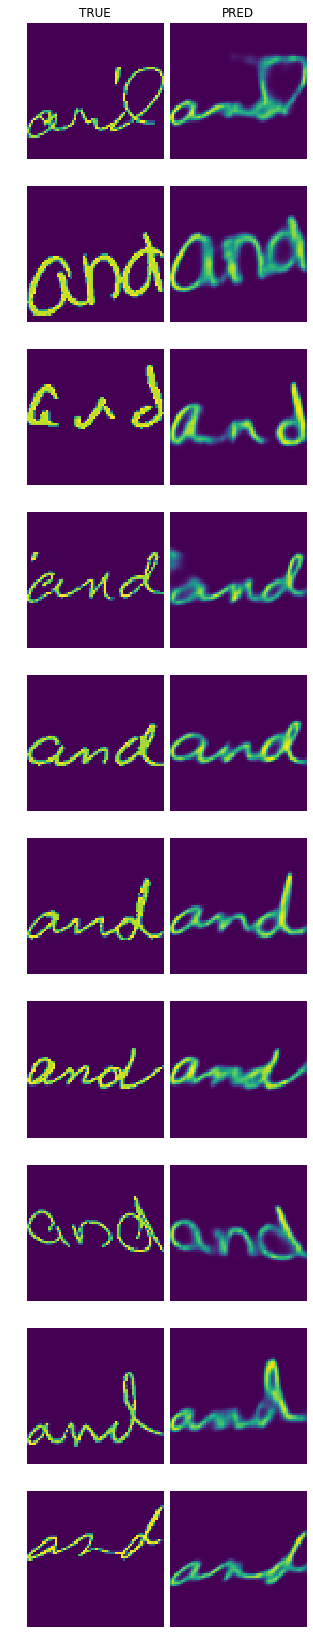

In [19]:

print(vx.shape,vy[0].shape)
py = autoencoder.predict(vx[:10])
f,ax = plt.subplots(len(vx[:10]),2)
f.subplots_adjust(hspace = .00, wspace=.05)
f.set_size_inches(5,len(vx[:10])*3)
ax[0,0].set_title('TRUE')
ax[0,1].set_title('PRED')
for i in range(len(vx[:10])):
#     print(vy[0][i], vy[1][i])
    ax[i,0].imshow(vx[i].reshape((64,64)))
    ax[i,0].axis('off')
    
    ax[i,1].imshow(py[i].reshape((64,64)))
    ax[i,1].axis('off')


In [20]:
encoder = Model(inputs=autoencoder.inputs,outputs=autoencoder.get_layer('encoded').output)


In [21]:
# df_val = pd.DataFrame(vy).T
# df_val.columns = ['identity','id','imagename']
# df_val = df_val.sort_values(by=['identity','imagename'])
# df_val = df_val.drop_duplicates()
# df_val = df_val.drop(columns=['id'])
# df_val

In [41]:
ids = vy[0].reshape(-1,1)
imagenames = vy[1].reshape(-1,1)
preds = encoder.predict(vx).reshape((-1,512))
# print(ids.shape,preds.shape)
# 
data=[]
for i in range(len(vx)):
    data.append([ids[i][0],imagenames[i][0],preds[i]])
df_data = pd.DataFrame(data=data, columns=['identity','imagename','latent'])
# df_outs['ids'] = ids
# df_outs['preds'] = preds 
df_data=df_data.sort_values(by='identity').reset_index()
df_data.head(50)

,index,identity,imagename,latent
0,3130,0001,0001a_num2.png,"[0.0, 0.91986203, 0.0, 0.0, 0.0, 0.0, 0.449139..."
1,1653,0001,0001a_num1.png,"[0.0, 0.036296584, 0.0, 0.010984048, 0.0, 0.40..."
2,2057,0001,0001a_num2.png,"[0.0, 0.91986203, 0.0, 0.0, 0.0, 0.0, 0.449139..."
3,1162,0001,0001a_num1.png,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.49440774, 0.370194..."
4,19,0001,0001a_num1.png,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.4904661, 0.5380608..."
5,4645,0001,0001a_num1.png,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.3102742, 0.3085952..."
6,3686,0001,0001a_num2.png,"[0.0, 0.71615374, 0.0, 0.0, 0.0, 0.0, 0.339797..."
7,4472,0001,0001a_num1.png,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.40876874, 0.433157..."
8,2421,0001,0001a_num2.png,"[0.0, 0.20656404, 0.0, 0.0, 0.0, 0.0, 0.842780..."
9,3038,0002,0002a_num2.png,"[0.0, 0.5048764, 0.0, 0.0, 0.0, 2.6756716, 0.0..."


In [23]:
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm_notebook

In [24]:
cos_dist_out = cosine_similarity(list(df_data['latent'].values))

In [32]:
queried_count, idx_count, tp, tn, fp, fn = 0,0,0,0,0,0
cos_thresh = 0.6
data_result = []
fp_list = []
fn_list = []
r_counter = 0
stop_at = 10
prev_query = ''
prev_given = ''
given_count = 0
# total = cos_dist_out.shape[0]
for row in tqdm_notebook(cos_dist_out):
    c_counter = 0
    given_idx = df_data.iloc[r_counter]['identity']
    given_img = df_data.iloc[r_counter]['imagename']
    for col in row:
        queried_idx = df_data.iloc[c_counter]['identity']
        queried_img = df_data.iloc[c_counter]['imagename']
        if int(given_idx) == int(queried_idx) and cos_dist_out[r_counter][c_counter]>cos_thresh:
            tp += 1
        if int(given_idx) != int(queried_idx) and cos_dist_out[r_counter][c_counter]<cos_thresh:
            tn += 1
        if int(given_idx) != int(queried_idx) and cos_dist_out[r_counter][c_counter]>cos_thresh:
            fp += 1
            fp_list.append(os.path.join(queried_idx,queried_img))
        if int(given_idx) == int(queried_idx) and cos_dist_out[r_counter][c_counter]<cos_thresh:
            fn += 1
            fn_list.append(os.path.join(queried_idx,queried_img))
        if int(given_idx) == int(queried_idx):
            idx_count += 1
#             print('--i--',idx_count,'--i--')
#             print(given_idx,queried_idx)
        if prev_query != queried_idx:
#             print('--q--',queried_count,'--q--')
            queried_count += 1
        c_counter += 1
        prev_query = queried_idx
#         if queried_count == stop_at:
#             break
    precision = tp/(fp+tp)
    recall = tp/(tp+fn)
    f1 = 2*(precision*recall)/(precision+recall)
    total = np.sum((tp,tn,fp,fn))
    accuracy = (tp+tn)/total
    data_result.append([given_idx,given_img, idx_count, tp, tn, fp, fn,precision,recall,f1,accuracy, total, fp_list, fn_list])
    if prev_given != given_idx:
#         print('----',given_count,'-----')
        given_count+=1
    r_counter += 1
    prev_given = given_idx
    queried_count, idx_count, tp, tn, fp, fn = 0, 0, 0, 0, 0, 0
    fp_list = []
    fn_list = []
#     if given_count == stop_at:
#         break

In [33]:
df_cos_dist_out = pd.DataFrame(data_result, columns=['identity','imagename','total_images_identity','TP','TN','FP','FN','precision','recall','f1','accuracy','total_images', 'FP_List','FN_List'])
df_cos_dist_out=df_cos_dist_out.sort_values(by='identity').reset_index().drop(columns=['index'])
df_cos_dist_out.head(50)

,identity,imagename,total_images_identity,TP,TN,FP,FN,precision,recall,f1,accuracy,total_images,FP_List,FN_List
0,0001,0001a_num2.png,9,9,4615,136,0,0.062069,1.000,0.116883,0.971429,4760,"[0002/0002a_num1.png, 0002/0002a_num1.png, 000...",[]
1,0001,0001a_num1.png,9,9,4564,187,0,0.045918,1.000,0.087805,0.960714,4760,"[0002/0002a_num1.png, 0002/0002a_num1.png, 000...",[]
2,0001,0001a_num2.png,9,9,4615,136,0,0.062069,1.000,0.116883,0.971429,4760,"[0002/0002a_num1.png, 0002/0002a_num1.png, 000...",[]
3,0001,0001a_num1.png,9,9,4575,176,0,0.048649,1.000,0.092784,0.963025,4760,"[0002/0002a_num1.png, 0002/0002a_num1.png, 000...",[]
4,0001,0001a_num1.png,9,9,4569,182,0,0.047120,1.000,0.090000,0.961765,4760,"[0002/0002a_num1.png, 0002/0002a_num1.png, 000...",[]
5,0001,0001a_num1.png,9,9,4586,165,0,0.051724,1.000,0.098361,0.965336,4760,"[0002/0002a_num1.png, 0002/0002a_num1.png, 000...",[]
6,0001,0001a_num2.png,9,9,4624,127,0,0.066176,1.000,0.124138,0.973319,4760,"[0002/0002a_num1.png, 0002/0002a_num1.png, 001...",[]
7,0001,0001a_num1.png,9,9,4560,191,0,0.045000,1.000,0.086124,0.959874,4760,"[0002/0002a_num1.png, 0002/0002a_num1.png, 000...",[]
8,0001,0001a_num2.png,9,9,4596,155,0,0.054878,1.000,0.104046,0.967437,4760,"[0002/0002a_num1.png, 0002/0002a_num1.png, 000...",[]
9,0002,0002a_num2.png,8,8,4658,94,0,0.078431,1.000,0.145455,0.980252,4760,"[0001/0001a_num1.png, 0008/0008a_num1.png, 000...",[]


In [53]:
df_cos_dist_out.to_csv('results-DL_AE_Maxpool_1x1x512_Seen.csv')

In [34]:
# print(df_cos_dist_out.keys())
total = df_cos_dist_out.shape[0]
total_images_identity = df_cos_dist_out['total_images_identity']
tps = df_cos_dist_out['TP'].sum()
fps = df_cos_dist_out['FP'].sum()
tns = df_cos_dist_out['TN'].sum()
fns = df_cos_dist_out['FN'].sum()
precision = tps/(fps+tps)
recall = tps/(tps+fns)
f1 = 2*(precision*recall)/(precision+recall)
print('precision:',precision,'\nrecall:',recall,'\nf1:',f1)
acc = df_cos_dist_out['accuracy'].mean()
print('Intra Writer Accuracy (Type 1):',np.mean(df_cos_dist_out['TP']/total_images_identity))
print('Inter Writer Accuracy (Type 2)::',tns/total/total)
print('acc:',acc)

precision: 0.057390901849340134 
recall: 0.8375947527591218 
f1: 0.10742142736611988
Intra Writer Accuracy (Type 1): 0.8436160219263902
Inter Writer Accuracy (Type 2):: 0.9668343513876139
acc: 0.9687168102535131


Text(0.5, 1.0, 'Right Input')

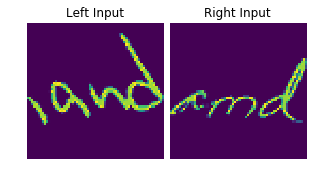

In [52]:
# test_im_shifted=test_im_normal
# test_im_shifted = vx[-2]
# rand = np.random.randint(-12,12)
# test_im_shifted=np.roll(axis=0,a=test_im_shifted,shift=-10)
# test = np.zeros((64,64,1))
# test[0:45]=test_im_shifted
# test_im_normal = vx[1]
# test_im_shifted = vx[2]
# plt.imshow(test_im_shifted.reshape((64,64)))
test_im_normal = vx[29]#255.0-cv2.imread('../Handwriting/cleaned_AND_data_64x64/0005aa_num1.png',0)
test_im_shifted = 255.0-cv2.imread('../Handwriting/cleaned_AND_data_64x64/0005a_num1.png',0)
f,ax = plt.subplots(1,2)
f.subplots_adjust(hspace = .00, wspace=.05)
f.set_size_inches(5,1*3)
ax[0].imshow(test_im_normal.reshape((64,64)))
ax[0].axis('off')

ax[1].imshow(test_im_shifted.reshape((64,64)))
ax[1].axis('off')
ax[0].set_title('Left Input')
ax[1].set_title('Right Input')

In [43]:
py1 = encoder.predict(test_im_normal.reshape((1,64,64,1)))
py2 = encoder.predict(test_im_shifted.reshape((1,64,64,1)))
py1[py1==0].shape,py2[py2==0].shape

((301,), (290,))

In [44]:
py1 = py1.reshape((-1,512))
py2 = py2.reshape((-1,512))
print(py1.shape,py2.shape)
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, euclidean_distances
cosine_similarity(py1,py2), cosine_distances(py1,py2), euclidean_distances(py1,py2)

(1, 512) (1, 512)


(array([[0.64731824]], dtype=float32),
 array([[0.35268176]], dtype=float32),
 array([[3187.9543]], dtype=float32))

In [31]:
val_list_of_writers[:2]

['0901a_num1.png', '1194a_num2.png']

In [51]:
cos_dist_out[28][32]

0.6173053